### Code Artefact
Loading the Environment Varialbes from `.env` file

In [1]:
import os, json, ast, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from pymongo import MongoClient, errors
from dotenv import load_dotenv
import plotly.express as px

# Confidential database is stored as environment varibles
load_dotenv()
mongodb_url = os.getenv('MONGODB_URL')
mongodb_dbname = os.getenv('MONGODB_DBNAME')

Importing and storing the datasets into database

In [2]:
# Helper functions

def import_json(path):
    '''Opens json file in given path and return data in dict'''
    file = open(path, 'r')
    data = json.load(file)
    file.close()
    return data


def remove_non_smoking_data(data):
    '''removes records NOT related to smoking by using the TopicID="TAC01" for filtering'''
    data_df = pd.DataFrame(data['data'])
    data_df = data_df[data_df.iloc[:, 32] == 'TAC01']
    data['data'] = data_df.values.tolist()
    return data


def get_columns_and_data(data):
    '''Extracts useful information from unstructured dict'''
    columns = data['meta']['view']['columns']
    records = data['data']
    data_list = list()
    data_list.append({'u_id': 'columns', 'record': columns})
    for record in records:
        record = {'u_id': record[0], 'record': record}
        data_list.append(record)
    return data_list


def clean_data_create_uid(df):
    # creating unique id from the columns
    df["_id"] = df.apply(
        lambda row: f"{row['Fiscal Year']}-{row['Periods Ending'].split('-')[0].strip()}-{row['Town Code']}-{row['NAICS Code']}",
        axis=1
    )
    df["tax_due"] = df.apply(
        lambda row: {
            "6.35_percent": row["Tax Due at 6.35% Rate"],
            "7.35_percent": row["Tax Due at 7.35% Rate"],
            "7.75_percent": row["Tax Due at 7.75% Rate"]
        },
        axis=1
    )

    # Drop unnecessary columns
    df = df.drop(
        ["Tax Due at 6.35% Rate", "Tax Due at 7.35% Rate", "Tax Due at 7.75% Rate","Georeference"],
        axis=1
    )

    return df


def store_data_in_mongodb(data, collection_name):
    '''Stores given dict data in given mongodb collection'''

    #Establishing connection
    client = MongoClient(mongodb_url)
    project_db = client[mongodb_dbname]

    # Storing into database
    try:
        if collection_name not in project_db.list_collection_names():
            collection = project_db[collection_name]
            collection.insert_many(data)
            print("Data inserted into MongoDB.")
        else:
            print('Data already existing.')
    except errors.DuplicateKeyError:
        print('Data already existing.')
    except errors.BulkWriteError:
        print('Data already existing.')
    except Exception as e:
        print(f"Error inserting raw data: {e}")

    client.close()


def create_alzheimers_dataframe(data):
    '''Extracts column names and data rows from the unstructured data and returns dataframe'''

    data = iter(data)
 
    # extracting column names
    columns = list()
    for column in next(data)['record']:
        columns.append(column['name'])

    # extracting data rows
    data_rows = list()
    for record in data:
        data_rows.append(record['record'])

    return pd.DataFrame(data_rows, columns=columns)


# Loading the tobacco dataset and Saving raw dataset to collection
tobacco_data = pd.read_csv('The_Tax_Burden_on_Tobacco__1970-2019.csv')
store_data_in_mongodb(tobacco_data.to_dict(orient='records'), 'TAX_BURDEN_ON_TOBACCO')

# Loading the Connecticut sales and tax data from csv file and saving to mongodb
connecticut_data = pd.read_csv('Connecticut_Sales_and_Use_Tax_Data.csv')
connecticut_data = clean_data_create_uid(connecticut_data)
store_data_in_mongodb(connecticut_data.to_dict(orient='records'), 'Connecticut_Sales_and_Use_Tax_Data')

# Loading the Income Tax data from csv file and saving to mongodb
income_tax_data = pd.read_csv('Income_Tax_Components_by_Size_of_Income_by_Place_of_Residence__Beginning_Tax_Year_1999.csv')
store_data_in_mongodb(income_tax_data.to_dict(orient='records'), 'Deductions_of_All_Returns')

# Importing from alzheimers file, removeing useless alzheimers data records NOT related to smoking
# for formatting and storing in database and also creating dataframe
alzheimers_data = import_json('Alzheimer_s_Disease_and_Healthy_Aging_Data.json')
alzheimers_data = remove_non_smoking_data(alzheimers_data) # challenge 1
alzheimers_data = get_columns_and_data(alzheimers_data) # challenge 2
store_data_in_mongodb(alzheimers_data, 'Alzheimers_Disease_Unstructured')
alzheimers_df = create_alzheimers_dataframe(alzheimers_data)

Data inserted into MongoDB.
Data inserted into MongoDB.
Data inserted into MongoDB.
Data inserted into MongoDB.


Data Preprocessing and storing Structured Dataset in database

In [3]:
# Helper functions

def clean_and_restructure_tobacco_data(data):

    # Convert Year to integer and Data_Value to numeric
    data['Year'] = pd.to_numeric(data['Year'], errors='coerce')
    data['Data_Value'] = pd.to_numeric(data['Data_Value'], errors='coerce')
    data[['Latitude','Longitude']] = data['GeoLocation'].str.extract(r'\(([^,]+),\s*([^)]+)\)')
    data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
    data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')

    # Handling missing values
    data = data.drop(columns="Data_Value_Unit")
    data_cleaned = data.dropna(subset=['Year', 'Data_Value'])

    # Restructuring the dataset
    structured_data = data_cleaned.pivot_table(
        index=['LocationAbbr', 'LocationDesc', 'Year'],
        columns=['SubMeasureDesc'],
        values='Data_Value',
        aggfunc='mean'
    ).reset_index()

    # Removing the column grouping name
    structured_data.columns.name = None 
    structured_data.rename(columns={
        'State Tax per pack': 'State_Tax_per_Pack',
        'Federal Tax per pack': 'Federal_Tax_per_Pack',
        'Average Retail Price per pack': 'Average_Retail_Price_per_Pack'
    }, inplace=True)

    return (data, data_cleaned, structured_data)


def clean_and_convert_alzheimers_data(data):
    '''Removes useless columns, unrelated rows, missing rows and duplicate rows.
    Makes datatype conversion and renames columns'''

    data['YearStart'] = data['YearStart'].astype(int)
    data['YearEnd'] = data['YearEnd'].astype(int)
    data['Data_Value'] = data['Data_Value'].astype(float)

    # Removing useless columns
    useless_columns = [
        'id', 'position', 'created_at', 'created_meta', 'updated_at', 'updated_meta', 'meta', 'RowId',
        'LocationDesc', 'Datasource', 'Class', 'Topic', 'Question', 'Data_Value_Unit', 'DataValueTypeID',
        'Data_Value_Type', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
        'Low_Confidence_Limit', 'High_Confidence_Limit', 'StratificationCategory1', 'Stratification2',
        'Geolocation', 'ClassID', 'TopicID', 'QuestionID', 'LocationID', 'StratificationCategoryID1',
        'Counties', 'States', 'sid', 'StratificationID1', 'StratificationCategoryID2'
    ]
    data = data.drop(columns=useless_columns)

    # Remove missing rows
    data = data.dropna()
    
    # Remove duplicate rows
    data = data.drop_duplicates()

    # Removing unrelated rows as tax data is till 2019
    data = data[data['YearStart'] <= 2019]
    data = data[data['YearEnd'] <= 2019]

    # Renaming columns
    data = data.rename(columns={
        'YearStart': 'Year',
        'Data_Value': 'Alzheimers_percentage',
        'StratificationID2': 'Stratification2'
    })
    data = data.drop(columns=['YearEnd'])

    return data


def convert_tobacco_data_for_alzheimers_data(data):
    '''Removes useless columns, unrelated rows, missing rows and duplicate rows.
    Makes datatype conversion and renames columns'''

    # Removing useless columns
    useless_columns = [
        'LocationDesc', 'Datasource', 'TopicDesc', 'MeasureDesc', 'Data_Value_Unit',
        'Data_Value_Type', 'GeoLocation', 'Source', 'TopicTypeId', 'TopicId', 'MeasureId',
        'SubMeasureID', 'SubMeasureIdDisplayOrder'
    ]
    data = data.drop(columns=useless_columns)

    # Remove missing rows
    data = data.dropna()
    
    # Remove duplicate rows
    data = data.drop_duplicates()

    data = data[data['Year'] >= 2015]

    return data


def sum_tax_due(tax_due_entry):
    if isinstance(tax_due_entry, dict):
        # If it's already a dictionary, sum the values
        return sum(tax_due_entry.values())
    elif isinstance(tax_due_entry, str):
        try:
            # Convert string representation of dict to actual dict
            tax_dict = ast.literal_eval(tax_due_entry)
            return sum(tax_dict.values())
        except (ValueError, SyntaxError):
            # Handle cases where conversion fails
            return 0
    else:
        # For any other data type (e.g., NaN), return 0 or np.nan
        return 0
    

def clean_and_convert_connecticut_data(data):

    # Dropping few records as the data is not related to connecticut state and removing missing values and duplicates
    data = data[~data['Municipality'].isin(['Out Of State','Out Of Country'])]

    # Apply the function to the 'tax_due' column to create 'Total Tax Due'
    data['Total Tax Due'] = data['tax_due'].apply(sum_tax_due)
    data = data.drop(['tax_due'], axis=1)

    #converting the columns to appropriate datatypes
    columns_to_category= [
        'Fiscal Year', 'Periods Ending', 'Municipality', 'NAICS Code', 
        'NAICS Sector']
    data[columns_to_category] = data[columns_to_category].astype('category')
    data['Calendar Year'] = data['Calendar Year'].astype(int)
    data['Town Code'] = data['Town Code'].astype(int)
    data['Taxpayer Count'] = pd.to_numeric(data['Taxpayer Count'], errors='coerce') 
    data['Retail Sales of Goods'] = pd.to_numeric(data['Retail Sales of Goods'], errors='coerce')

    return data


def clean_and_convert_incometax_data(data):

    data = data.drop_duplicates()

    # Pivot to restructure data
    structured_data = data.pivot_table(
        index=['Tax Year', 'Place of Residence', 'Country', 'State', 'County'],
        columns=['Income Class'],  # Pivoting on Income Class
        values=['Number of All Returns', 'NY AGI of All Returns (in thousands) *',
                'Deductions of All Returns (in thousands)',
                'Dependent Exemptions of All Returns (in thousands)',
                'Taxable Income of All Returns (in thousands)',
                'Tax Before Credits of All Returns (in thousands)',
                'Tax Liability of All Returns (in thousands) **'],
        aggfunc='sum'
    ).reset_index()
    
    # Flatten the column hierarchy after pivoting
    structured_data.columns = ['_'.join(filter(None, col)).strip() for col in structured_data.columns.values]
    
    # Rename columns for better readability
    structured_data.rename(columns={
        'Tax Year_': 'Tax_Year',
        'Place of Residence_': 'Place_of_Residence',
        'Income Class': 'Income_Class'
    }, inplace=True)  

    return structured_data              


# Cleaning, converting datatypes, renaming columns and restructuring tobacco data 
tbc_data, data_cleaned, structured_tobacco_data = clean_and_restructure_tobacco_data(tobacco_data.copy())

# Removing unwanted columns, unrelated rows, missing rows and duplicate rows
alzheimers_df = clean_and_convert_alzheimers_data(alzheimers_df)
tobacco_df = convert_tobacco_data_for_alzheimers_data(tobacco_data.copy())

# Cleaning, filtering, converting datatypes, removing unrealted columns and introducing new columns
structured_connecticut_data = clean_and_convert_connecticut_data(connecticut_data)

# Removing dupliicates and restructuring the incometax data
structured_incometax_data = clean_and_convert_incometax_data(income_tax_data)

# Integrating tobacco dataset to alzheimers dataset
# which is split by gender and ethnicity
tobacco_df_state = tobacco_df[tobacco_df['SubMeasureDesc'] == 'State Tax per pack']
tobacco_df_state = tobacco_df_state.rename(columns={'Data_Value': 'State_Tax'})
tobacco_df_state = tobacco_df_state.drop(columns=['SubMeasureDesc'])

tobacco_df_federal = tobacco_df[tobacco_df['SubMeasureDesc'] == 'Federal and State Tax per pack']
tobacco_df_federal = tobacco_df_federal.rename(columns={'Data_Value': 'Federal_And_State_Tax'})
tobacco_df_federal = tobacco_df_federal.drop(['SubMeasureDesc'], axis=1)

alzheimers_merged_df = pd.merge(alzheimers_df, tobacco_df_state, on=['Year', 'LocationAbbr'], how='left')
alzheimers_merged_df = pd.merge(alzheimers_merged_df, tobacco_df_federal, on=['Year', 'LocationAbbr'], how='left')

# Storing all structured dataset in database
store_data_in_mongodb(structured_tobacco_data.to_dict(orient='records'), 'STRUCTURED_TAX_BURDEN_ON_TOBACCO')
store_data_in_mongodb(alzheimers_merged_df.to_dict(orient='records'), 'Alzheimers_Disease_Structured')
store_data_in_mongodb(structured_connecticut_data.to_dict(orient='records'), 'Processed_Connecticut_sales_data')
store_data_in_mongodb(structured_incometax_data.to_dict(orient='records'), 'Structured_Income_Tax_Data')

C:\Users\rocks\AppData\Local\Temp\ipykernel_66800\2052586071.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Total Tax Due'] = data['tax_due'].apply(sum_tax_due)


Data inserted into MongoDB.
Data inserted into MongoDB.
Data inserted into MongoDB.
Data inserted into MongoDB.


Data patterns in Alzheimers data

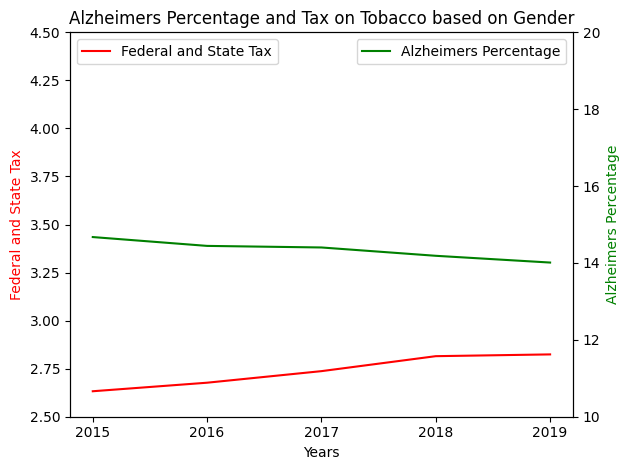

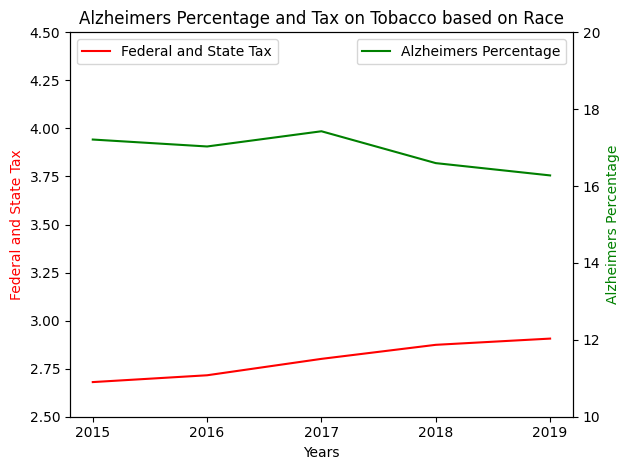

In [4]:
def show_line_plot(data, based_on):
    fig, ax1 = plt.subplots()

    sns.lineplot(x=data['Year'], y=data['Federal_And_State_Tax'], ax=ax1, color='r', errorbar=None, label='Federal and State Tax')
    ax1.set_xlabel('Years')
    ax1.set_ylabel('Federal and State Tax', color='r')

    ax2 = ax1.twinx()
    sns.lineplot(x=data['Year'], y=data['Alzheimers_percentage'], ax=ax2, color='g', errorbar=None, label='Alzheimers Percentage')
    ax2.set_ylabel('Alzheimers Percentage', color='g')

    ax1.set_ylim(2.5, 4.5)
    ax2.set_ylim(10, 20)

    plt.xticks([2015, 2016, 2017, 2018, 2019])

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title(f'Alzheimers Percentage and Tax on Tobacco based on {based_on}')
    fig.tight_layout()
    plt.show()


def show_geo_plot(data, year):
    data = data[data['Year'] == year]
    fig = px.choropleth(data,
        locations='LocationAbbr',
        locationmode='USA-states',
        color='Alzheimers_percentage',
        color_continuous_scale='Reds',
        scope='usa',
        labels={'Alzheimers_percentage': 'Alzheimers Percentage', 'Federal_And_State_Tax': 'Tax'},
        title=f'Alzheimers Percentage by state in {year}',
        width=800
    )
    fig.show()


# splitting the dataset based on gender and race
merged_df_gender = alzheimers_merged_df[alzheimers_merged_df['StratificationCategory2'] == 'Gender']
merged_df_gender = merged_df_gender.drop(columns=['StratificationCategory2'])

merged_df_race = alzheimers_merged_df[alzheimers_merged_df['StratificationCategory2'] == 'Race/Ethnicity']
merged_df_race = merged_df_race.drop(columns=['StratificationCategory2'])


# Plotting line plot to show the trends in alzheimers data and tax on tobacco data
show_line_plot(merged_df_gender, 'Gender')
show_line_plot(merged_df_race, 'Race')

# Plotting geographic map of USA to show the Alzheimers percentage change between 2015 and 2019
show_geo_plot(alzheimers_merged_df, 2015)
show_geo_plot(alzheimers_merged_df, 2019)

Machine Learning Usescases

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


def machine_learning_model(data, column):

    # One Hot Encoding to deal with the categorical data
    enc_df = pd.get_dummies(data)

    # Scaling the data
    X = enc_df.drop(columns=[column])
    y = enc_df[column]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting the data into test and train
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Initializing the XGBoost model, training the model
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predicting on the test set
    y_pred = model.predict(X_test)

    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return (mse, r2)

# Alzheimers Disease prediction based on tax on tobacco
print('Alzheimers Disease prediction based on tax on tobacco:')

mse, r2 = machine_learning_model(merged_df_gender, 'Alzheimers_percentage')
print('\nModel performance of gender data:')
print(f'MSE: {mse}')
print(f'R²: {r2}')

mse, r2 = machine_learning_model(merged_df_race, 'Alzheimers_percentage')
print('\nModel performance of race data:')
print(f'MSE: {mse}')
print(f'R²: {r2}')

Alzheimers Disease prediction based on tax on tobacco:

Model performance of gender data:
MSE: 2.2230111034641222
R²: 0.9260935955527129

Model performance of race data:
MSE: 13.251176855405674
R²: 0.7929081650583893


Data patterns in Connecticut Sales and Use Tax data

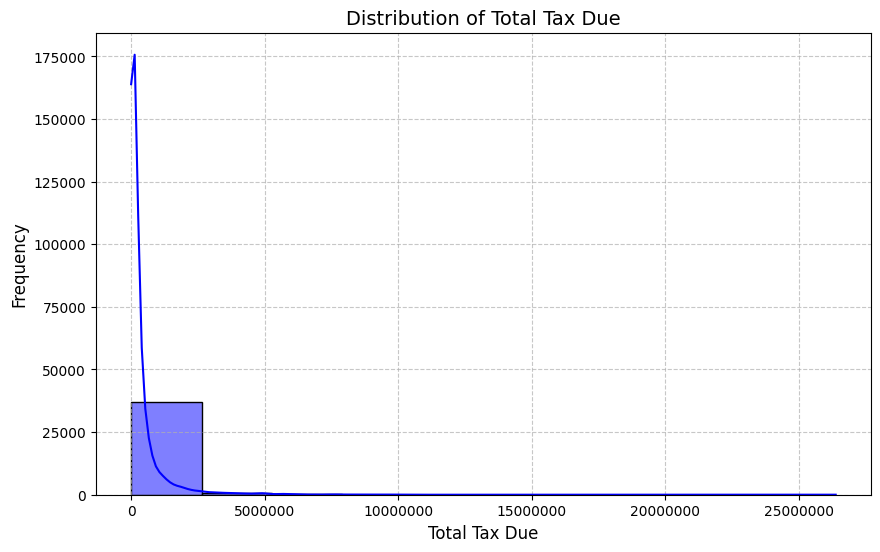

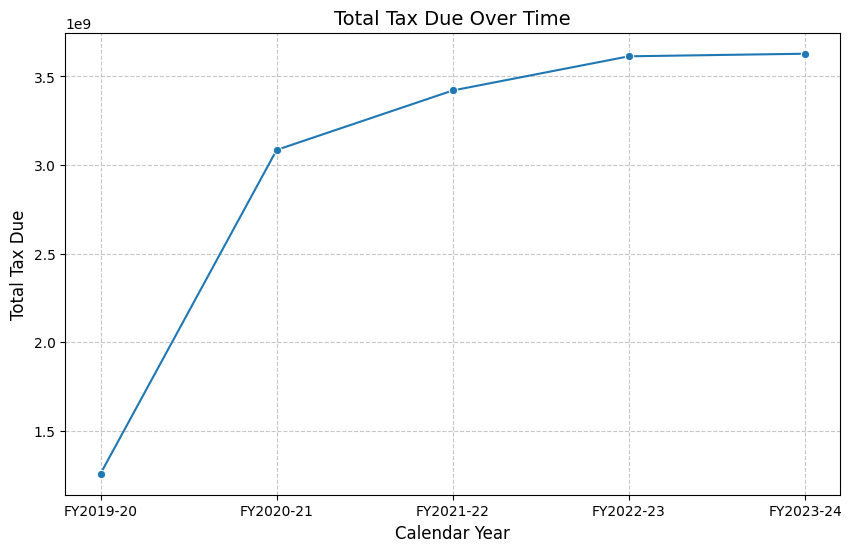

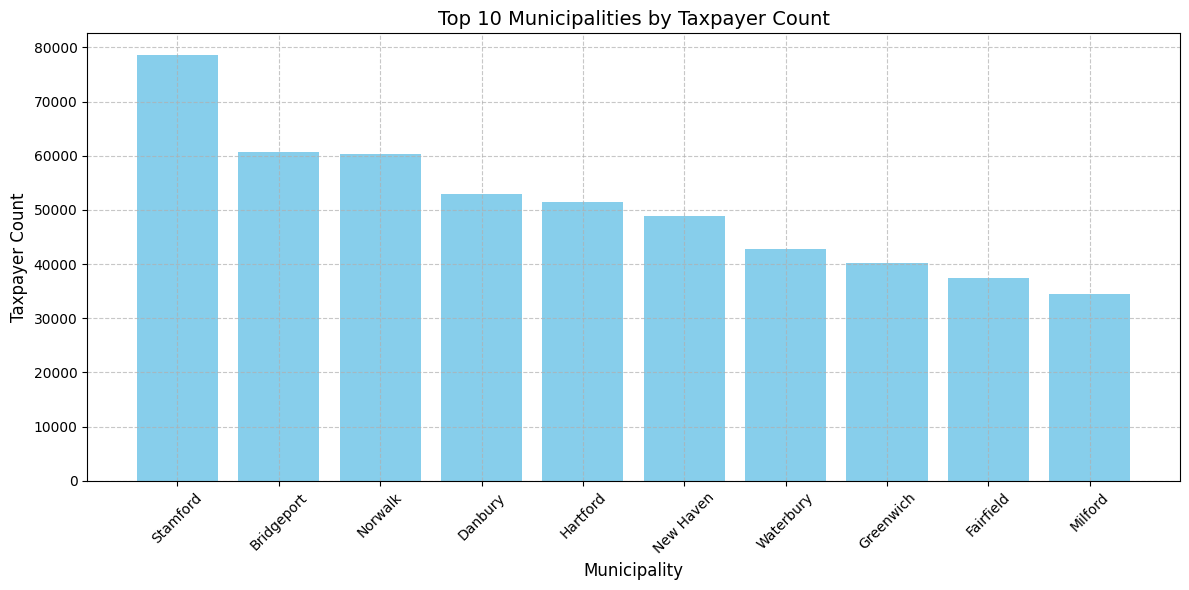

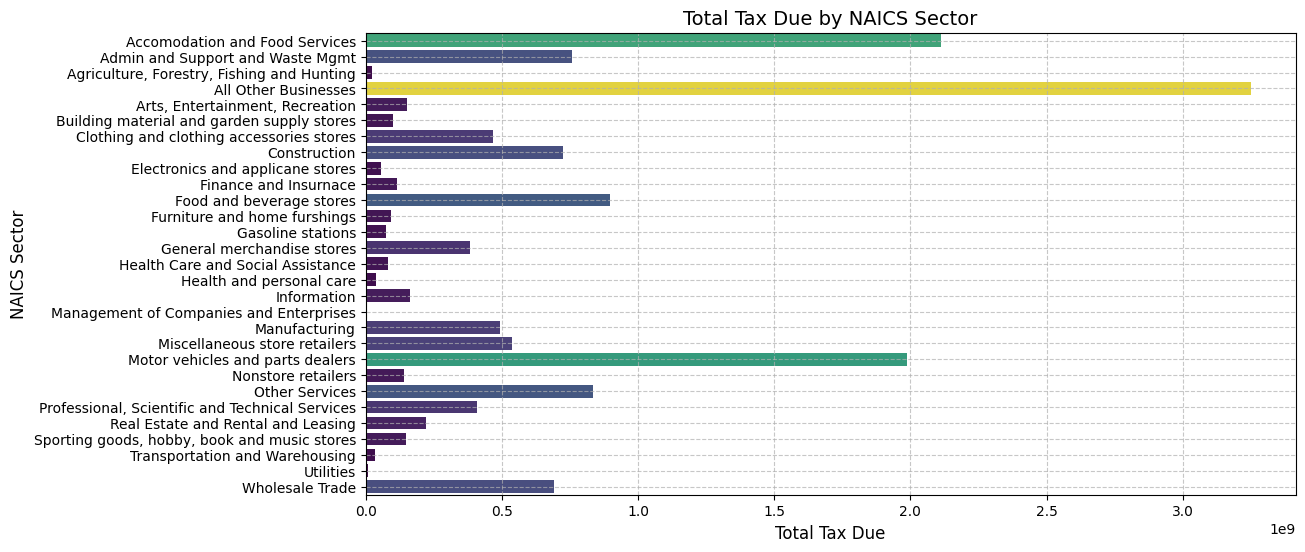

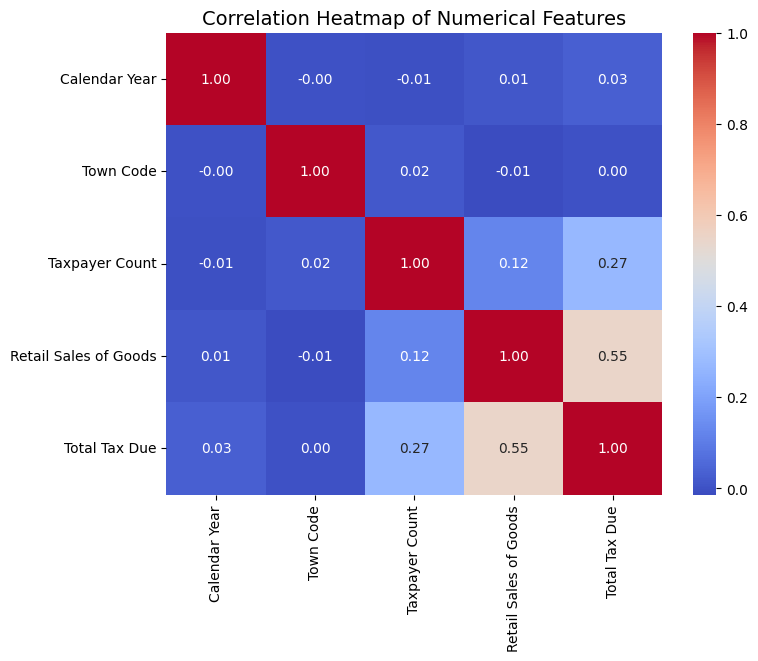

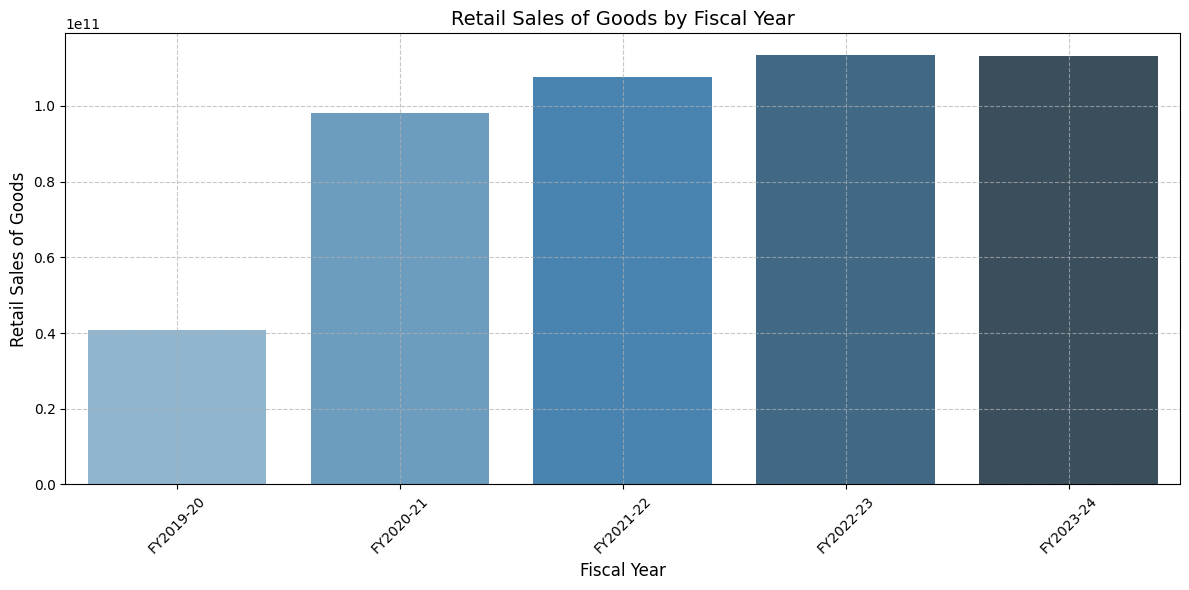

In [6]:
# Visualizations


# Histogram showing the frequency of tax due amount in the data.
plt.figure(figsize=(10, 6))
sns.histplot(structured_connecticut_data['Total Tax Due'], bins=10, kde=True, color='blue')
plt.title('Distribution of Total Tax Due', fontsize=14)
plt.xlabel('Total Tax Due', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# lineplot showing how total tax due amount is varying over the years based on sales and tax data
tax_by_year = structured_connecticut_data.groupby('Fiscal Year', observed=True)['Total Tax Due'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=tax_by_year, x='Fiscal Year', y='Total Tax Due', marker='o')
plt.title('Total Tax Due Over Time', fontsize=14)
plt.xlabel('Calendar Year', fontsize=12)
plt.ylabel('Total Tax Due', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()

# Bar graph showing Top 10 municipalities based on the most no.of taxpayers present.
top_municipalities = (structured_connecticut_data.groupby('Municipality', observed=True)['Taxpayer Count'].sum().nlargest(10).reset_index())
plt.figure(figsize=(12, 6)) 
plt.bar( top_municipalities['Municipality'],top_municipalities['Taxpayer Count'], color='skyblue')
plt.title('Top 10 Municipalities by Taxpayer Count', fontsize=14)
plt.xlabel('Municipality', fontsize=12) 
plt.ylabel('Taxpayer Count', fontsize=12) 
plt.xticks(rotation=45)  
plt.grid(visible=True, linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.show()

#Bar graph representing the total tax due by each NAICS sector by aggregating the based on the sectors
tax_by_sector = structured_connecticut_data.groupby('NAICS Sector', observed=True)['Total Tax Due'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=tax_by_sector.sort_values(by='Total Tax Due', ascending=False), 
            x='Total Tax Due', y='NAICS Sector', hue='Total Tax Due', palette='viridis', legend=False)
plt.title('Total Tax Due by NAICS Sector', fontsize=14)
plt.xlabel('Total Tax Due', fontsize=12)
plt.ylabel('NAICS Sector', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()

# Correlation Heatmap Showing the correlation between the numerical columns present in the data.
numeric_columns= structured_connecticut_data.select_dtypes(include=['int64']).columns
plt.figure(figsize=(8, 6))
sns.heatmap(structured_connecticut_data[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features', fontsize=14)
plt.show()

# Bar Graph Showing how retail sales have varied over time based on the sales and tax data.
sales_by_fiscal_year = structured_connecticut_data.groupby('Fiscal Year', observed=True)['Retail Sales of Goods'].sum().reset_index() 
plt.figure(figsize=(12, 6)) 
sns.barplot(data=sales_by_fiscal_year, x='Fiscal Year', y='Retail Sales of Goods', 
            hue='Fiscal Year', palette="Blues_d", legend=False) 
plt.title('Retail Sales of Goods by Fiscal Year', fontsize=14)
plt.xlabel('Fiscal Year', fontsize=12) 
plt.ylabel('Retail Sales of Goods', fontsize=12) 
plt.xticks(rotation=45) 
plt.grid(visible=True, linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.show()

Machine Learning Prediction for Total Tax in Connecticut sales data

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Scaling the numerical data
scalr = StandardScaler()
structured_connecticut_data[numeric_columns] = scalr.fit_transform(structured_connecticut_data[numeric_columns])
print("\nNumerical Columns after scaling:")
print(structured_connecticut_data[numeric_columns].head())

# adding weights for better results in prediction
weights = compute_sample_weight(class_weight='balanced', y=structured_connecticut_data['Total Tax Due'])
#splitting the training and test data
X = structured_connecticut_data[['Calendar Year','Town Code','Taxpayer Count','Retail Sales of Goods']]
y = structured_connecticut_data['Total Tax Due']
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.2, random_state=70)
# Training the Random Forest Regression model
model = RandomForestRegressor()
model.fit(X_train, y_train, sample_weight=weights_train)

# evaluating the prediction results
RF_y_pred = model.predict(X_test)
#Mean Squared Error (MSE)
RF_MSE = mean_squared_error(y_test, RF_y_pred)
#Mean Absolute Error (MAE)
RF_MAE = mean_absolute_error(y_test, RF_y_pred)
#root mean square error (RMSE)
RF_RMSE = np.sqrt(mean_squared_error(y_test, RF_y_pred))
# r2 Score
RF_R2 = r2_score(y_test, RF_y_pred)
# printing all the metrics
print(f"MSE:{RF_MSE:.2f}, MAE:{RF_MAE:.2f}, RMSE:{RF_RMSE:.2f}, R2:{RF_R2:.2f}")


Numerical Columns after scaling:
   Calendar Year  Town Code  Taxpayer Count  Retail Sales of Goods  \
0      -1.366479  -1.540485       -0.559262              -0.185885   
1       0.174948  -1.085031       -0.655809              -0.224420   
2       0.174948   0.653973        0.374024               0.114686   
3       0.945661  -0.236232       -0.559262              -0.221914   
4       0.945661  -1.064329       -0.366169              -0.194074   

   Total Tax Due  
0      -0.273103  
1      -0.334979  
2      -0.028808  
3      -0.339939  
4      -0.213886  
MSE:0.15, MAE:0.11, RMSE:0.38, R2:0.85


Data visualization of Income Tax dataset

Outliers in numerical attributes 
 Tax Year                                                 0
Number of All Returns                                 3819
NY AGI of All Returns (in thousands) *                4046
Deductions of All Returns (in thousands)              3771
Dependent Exemptions of All Returns (in thousands)    3686
Taxable Income of All Returns (in thousands)          3991
Tax Before Credits of All Returns (in thousands)      4015
Tax Liability of All Returns (in thousands) **        4052
Place of Residence Sort Order                            0
Income Class Sort Order                                  0
dtype: int64
outliers percentage in numerical attributes
 Tax Year                                               0.000000
Number of All Returns                                 16.090162
NY AGI of All Returns (in thousands) *                17.046556
Deductions of All Returns (in thousands)              15.887929
Dependent Exemptions of All Returns (in thousands)    15.5298

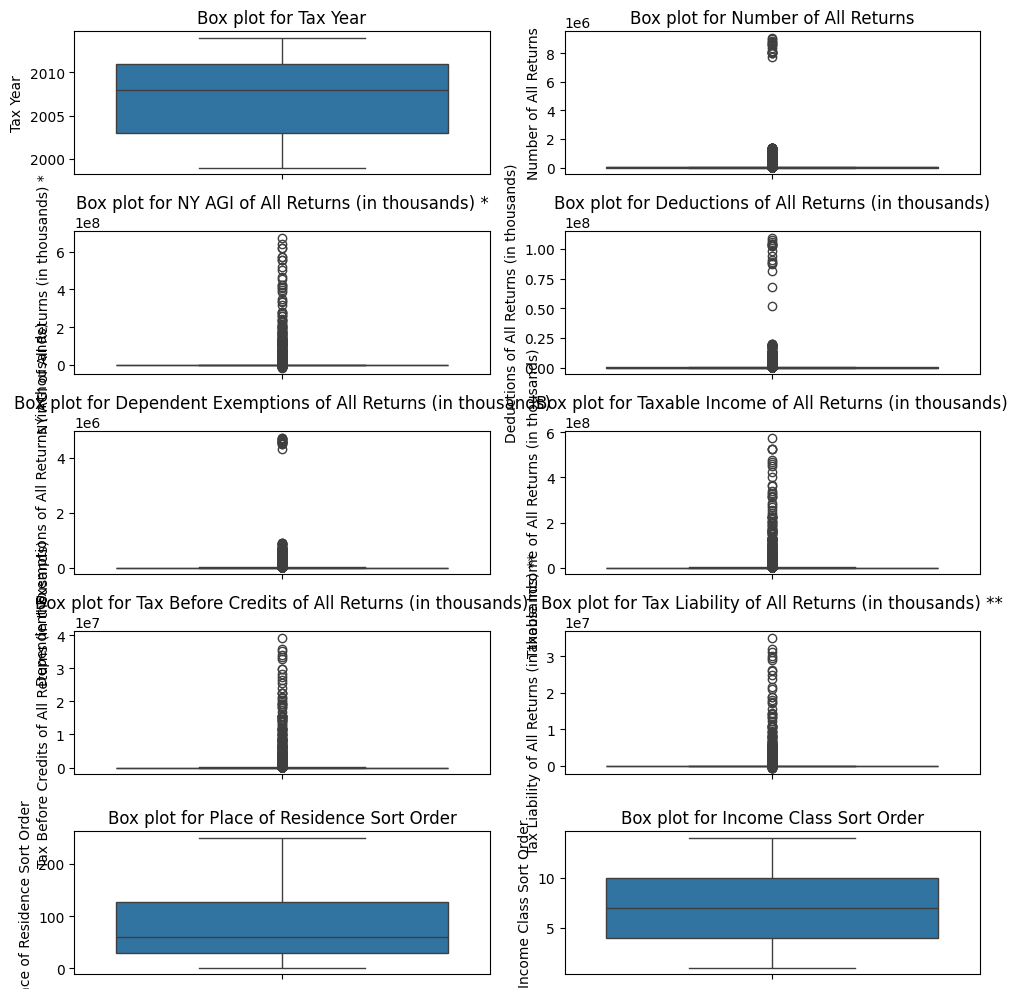

In [8]:
num_columns = income_tax_data.select_dtypes(include=['float64','int64']).columns

# Finding the income tax dataset outliers Using the Interquartile Range
def outliers():
    Q1 = income_tax_data[num_columns].quantile(0.25)
    Q3 = income_tax_data[num_columns].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((income_tax_data[num_columns] < (Q1 - 1.5 * IQR )) | (income_tax_data[num_columns] > (Q3 + 1.5 * IQR))).sum()
    outliers_percentage = (outliers / len(income_tax_data)) * 100
    print("Outliers in numerical attributes \n",outliers)
    print("outliers percentage in numerical attributes\n",outliers_percentage)

def visualize_outliers():
    plt.figure(figsize=(10,10))
    for i, col in enumerate(num_columns, 1):
        plt.subplot(5,2,i)
        sns.boxplot(income_tax_data[col])
        plt.title(f"Box plot for {col}")
        plt.tight_layout()
    plt.show

# Visualizing outliers for income tax data
outliers()
visualize_outliers()

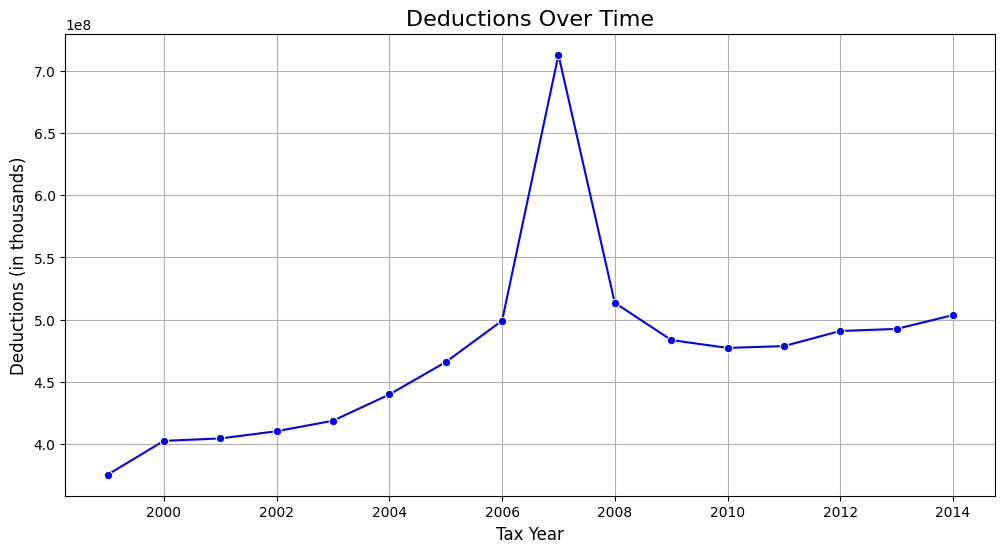

Forecasted Deductions for the next 5 periods:
2015-01-01    5.025581e+08
2016-01-01    5.023016e+08
2017-01-01    5.022398e+08
2018-01-01    5.022249e+08
2019-01-01    5.022213e+08
Freq: YS-JAN, Name: predicted_mean, dtype: float64


c:\Users\rocks\OneDrive - National College of Ireland\Documents\PAI\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

c:\Users\rocks\OneDrive - National College of Ireland\Documents\PAI\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

c:\Users\rocks\OneDrive - National College of Ireland\Documents\PAI\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency YS-JAN will be used.

C:\Users\rocks\AppData\Local\Temp\ipykernel_66800\554390995.py:26: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



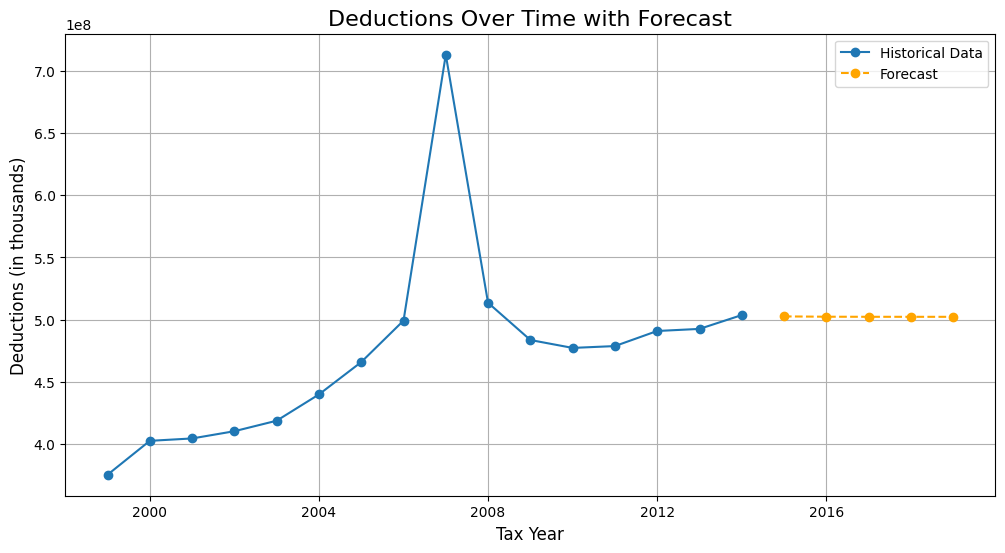

In [9]:
from statsmodels.tsa.arima.model import ARIMA

data = income_tax_data.drop(columns=["Disclosure"])

# Preparing the data for prediction
def prepare_data(data):
    data['Tax Year'] = pd.to_datetime(data['Tax Year'], format='%Y')   
    data.set_index('Tax Year', inplace=True)
    deductions_time_series = data['Deductions of All Returns (in thousands)'].groupby(data.index).sum()
    return deductions_time_series

# Plotting the time series data
def plot_time_series(time_series):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=time_series, marker='o', color='b')
    plt.title('Deductions Over Time', fontsize=16)
    plt.xlabel('Tax Year', fontsize=12)
    plt.ylabel('Deductions (in thousands)', fontsize=12)
    plt.grid(True)
    plt.show()
    
def plot_deduction_tax(forecast, deductions_time_series):
    # Plot the time series data and predictions
    plt.figure(figsize=(12, 6))
    plt.plot(deductions_time_series, label='Historical Data', marker='o')
    forecast_index = pd.date_range(start=deductions_time_series.index[-1] + pd.DateOffset(1), periods=5, freq='Y')
    plt.plot(forecast_index, forecast, label='Forecast', marker='o', linestyle='--', color='orange')
    plt.title('Deductions Over Time with Forecast', fontsize=16)
    plt.xlabel('Tax Year', fontsize=12)
    plt.ylabel('Deductions (in thousands)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

# Forcasting tax for next 5 years using ARIMA
def forecast_time_series(time_series):
    model = ARIMA(time_series, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=5)
    print("Forecasted Deductions for the next 5 periods:")
    print(forecast)
    return forecast


deductions_time_series = prepare_data(data)
plot_time_series(deductions_time_series)
forecast = forecast_time_series(deductions_time_series)
plot_deduction_tax(forecast, deductions_time_series)

Data trends in Tobacco Tax dataset

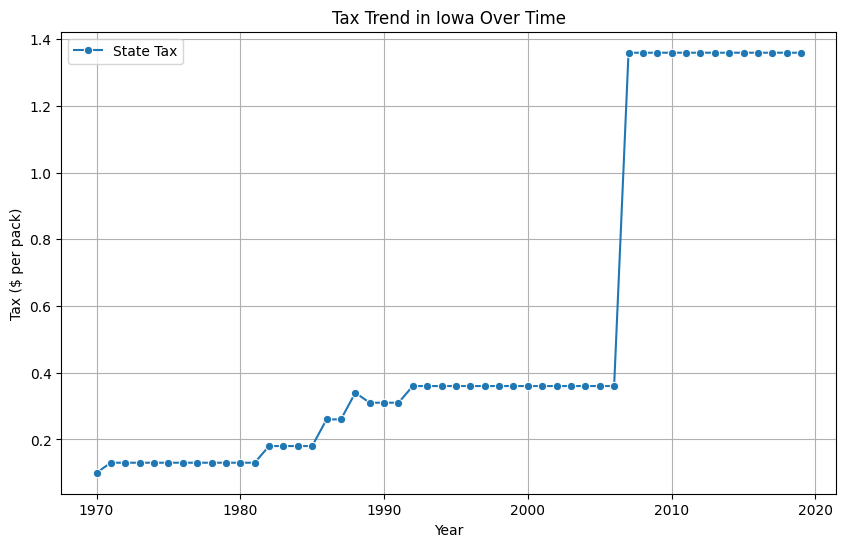

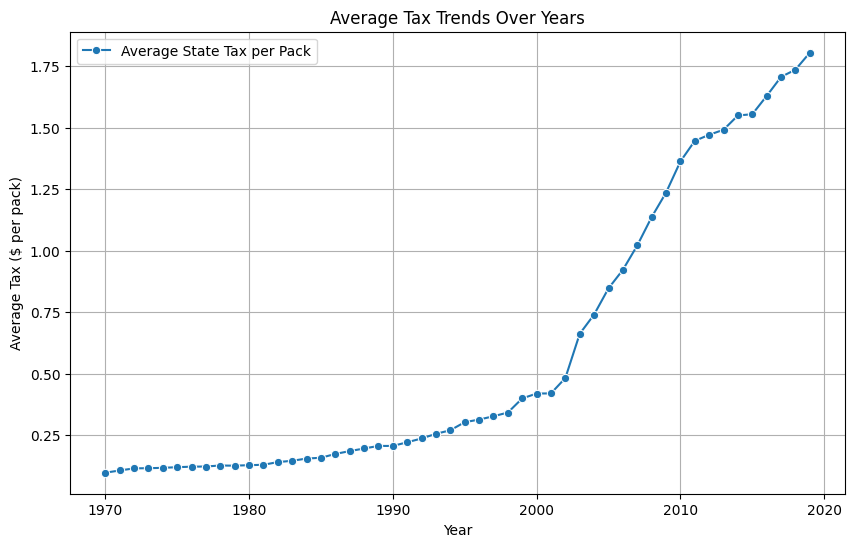

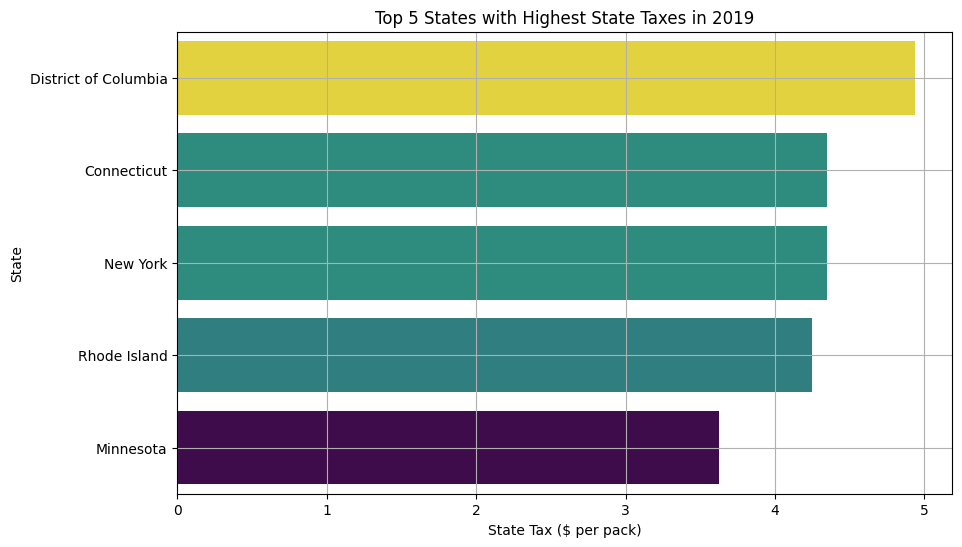

In [10]:
#Analyzing and visualizing the trends of tax
state = 'Iowa'
state_data = structured_tobacco_data[structured_tobacco_data['LocationDesc'] == state]

if 'State_Tax_per_Pack' in state_data.columns:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Year', y='State_Tax_per_Pack', data=state_data, marker='o', label='State Tax')
    plt.title(f'Tax Trend in {state} Over Time')
    plt.xlabel('Year')
    plt.ylabel('Tax ($ per pack)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Required columns for visualization are missing in the state data.")

#Processed outputs
available_tax_columns = [col for col in ['State_Tax_per_Pack', 'Federal_Tax_per_Pack'] if col in structured_tobacco_data.columns]

if available_tax_columns:
    average_tax_per_year = structured_tobacco_data.groupby('Year')[available_tax_columns].mean().reset_index()

    # Visualizing average tax trends across years
    plt.figure(figsize=(10, 6))
    for col in available_tax_columns:
        sns.lineplot(x='Year', y=col, data=average_tax_per_year, marker='o', label=f'Average {col.replace("_", " ")}')
    plt.title('Average Tax Trends Over Years')
    plt.xlabel('Year')
    plt.ylabel('Average Tax ($ per pack)')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("No tax-related columns are available for analysis.")

# Top 5 states with highest state taxes in 2019
data_2019 = structured_tobacco_data[structured_tobacco_data['Year'] == 2019]
if 'State_Tax_per_Pack' in data_2019.columns:
    top_5_states = data_2019.nlargest(5, 'State_Tax_per_Pack')[['LocationDesc', 'State_Tax_per_Pack']]

    # Visualizing top 5 states with highest state taxes in 2019
    plt.figure(figsize=(10, 6))
    sns.barplot(x='State_Tax_per_Pack', y='LocationDesc', data=top_5_states, hue='State_Tax_per_Pack', palette='viridis', legend=False)
    plt.title('Top 5 States with Highest State Taxes in 2019')
    plt.xlabel('State Tax ($ per pack)')
    plt.ylabel('State')
    plt.grid(True)
    plt.show()


Outliers in numerical attributes 
 Year                           0
Data_Value                  2563
SubMeasureIdDisplayOrder       0
Latitude                     600
Longitude                    600
dtype: int64
outliers percentage in numerical attributes
 Year                         0.000000
Data_Value                  16.751634
SubMeasureIdDisplayOrder     0.000000
Latitude                     3.921569
Longitude                    3.921569
dtype: float64


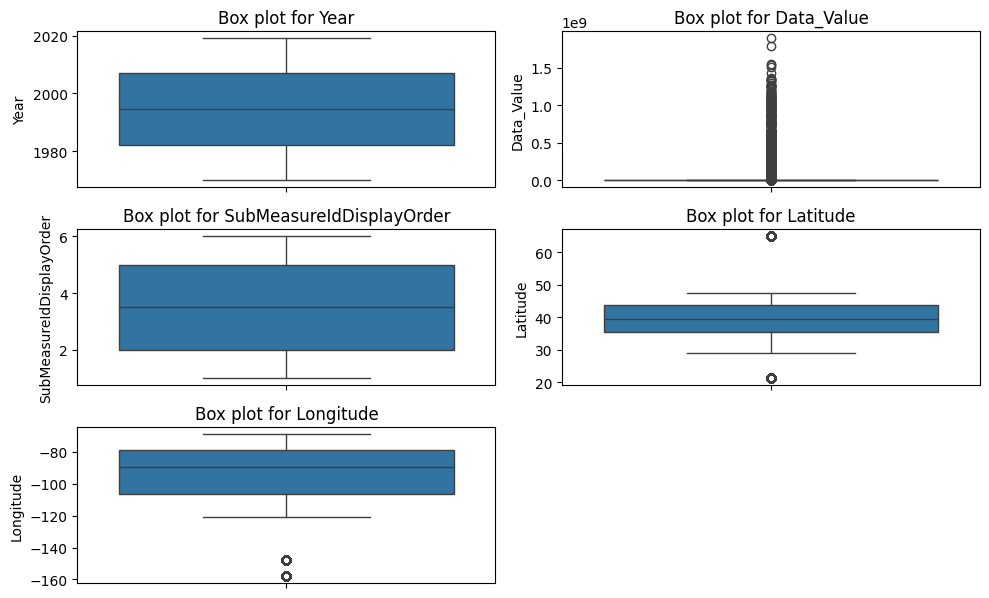

In [11]:
#Visualizing outliers
num_columns = data_cleaned.select_dtypes(include=['float64','int64']).columns

# Finding the income tax dataset outliers Using the Interquartile Range
def outliers():
    Q1 = data_cleaned[num_columns].quantile(0.25)
    Q3 = data_cleaned[num_columns].quantile(0.75)
    IQR = Q3 -Q1
    outliers = ((data_cleaned[num_columns] < (Q1 - 1.5 * IQR )) | (data_cleaned[num_columns] > (Q3 + 1.5 * IQR))).sum()
    outliers_percentage = (outliers / len(data_cleaned)) * 100
    print("Outliers in numerical attributes \n",outliers)
    print("outliers percentage in numerical attributes\n",outliers_percentage)

def visualize_outliers():
    plt.figure(figsize=(10,10))
    for i, col in enumerate(num_columns, 1):
        plt.subplot(5,2,i)
        sns.boxplot(data_cleaned[col])
        plt.title(f"Box plot for {col}")
        plt.tight_layout()
    plt.show
    
# Visualizing outliers for income tax data
outliers()
visualize_outliers()

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Data Scaling for Tobacco Dataset usind MinMaxScaler
scaler = MinMaxScaler()

data_cleaned['Data_Value'] = pd.to_numeric(data_cleaned['Data_Value'], errors='coerce')
tax_percentage = data_cleaned[data_cleaned['SubMeasureDesc'] == 'Federal and State tax as a Percentage of Retail Price']
tax_amount = tbc_data[data_cleaned['SubMeasureDesc'] == 'Federal and State Tax per pack']
merged_data = pd.merge(
    tax_percentage[['LocationDesc', 'Year', 'Data_Value']].rename(columns={'Data_Value': 'Tax_Percentage'}),
    tax_amount[['LocationDesc', 'Year', 'Data_Value']].rename(columns={'Data_Value': 'Tax_Amount'}),
    on=['LocationDesc', 'Year']
)
merged_data['Retail_Price'] = merged_data['Tax_Amount'] / (merged_data['Tax_Percentage'] / 100)
print(merged_data[['LocationDesc', 'Year', 'Tax_Percentage', 'Tax_Amount', 'Retail_Price']])
merged_data = merged_data.drop_duplicates()
print(merged_data)

merged_data['Scaled_Retail_Price'] = scaler.fit_transform(merged_data[['Retail_Price']])

print(merged_data[['LocationDesc', 'Year', 'Tax_Percentage', 'Tax_Amount', 'Retail_Price', 'Scaled_Retail_Price']])

       LocationDesc  Year  Tax_Percentage  Tax_Amount  Retail_Price
0     West Virginia  2012            32.8       1.560      4.756098
1            Oregon  1990            27.5       0.440      1.600000
2           Vermont  2017            48.6       4.090      8.415638
3            Nevada  1997            29.4       0.590      2.006803
4          Missouri  2004            18.1       0.560      3.093923
...             ...   ...             ...         ...           ...
2545       Missouri  2000            18.1       0.510      2.817680
2546           Utah  1988            28.8       0.390      1.354167
2547      Minnesota  2007            40.8       1.883      4.615196
2548    Mississippi  2008            16.5       0.570      3.454545
2549        Wyoming  1985            24.5       0.240      0.979592

[2550 rows x 5 columns]
       LocationDesc  Year  Tax_Percentage  Tax_Amount  Retail_Price
0     West Virginia  2012            32.8       1.560      4.756098
1            Oregon  19

c:\Users\rocks\OneDrive - National College of Ireland\Documents\PAI\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

04:10:31 - cmdstanpy - INFO - Chain [1] start processing
04:10:31 - cmdstanpy - INFO - Chain [1] done processing


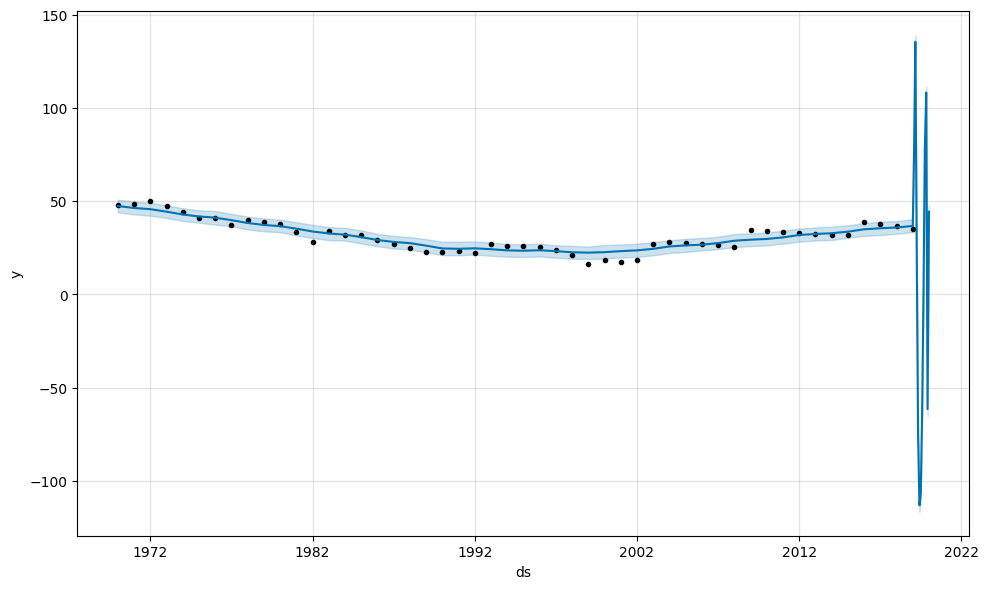

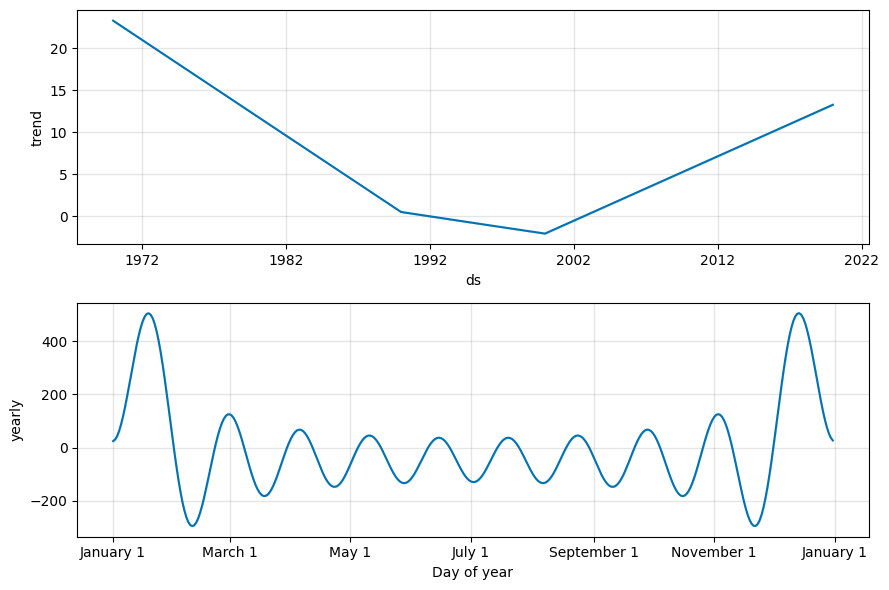

04:10:31 - cmdstanpy - INFO - Chain [1] start processing
04:10:32 - cmdstanpy - INFO - Chain [1] done processing


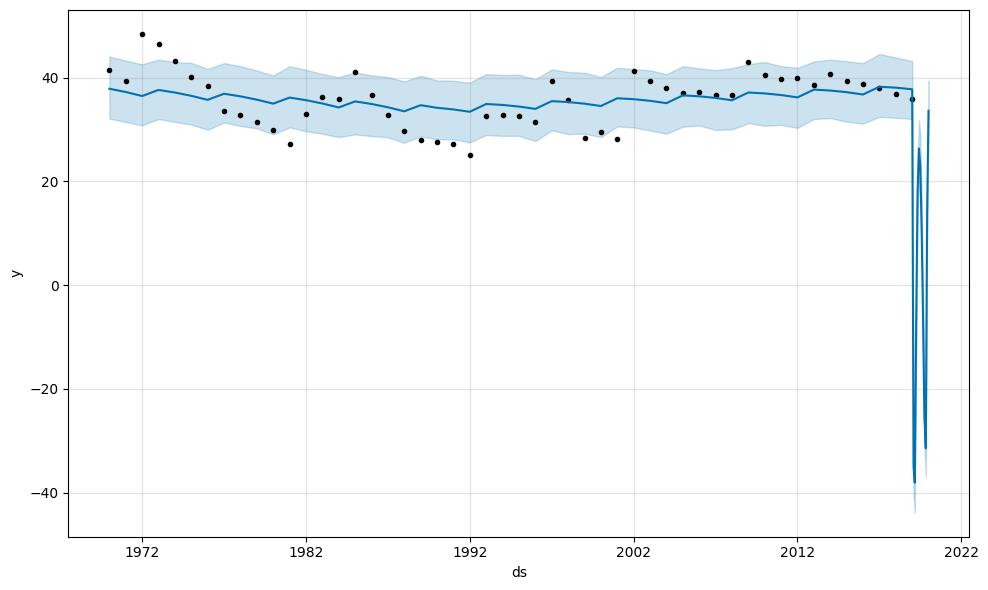

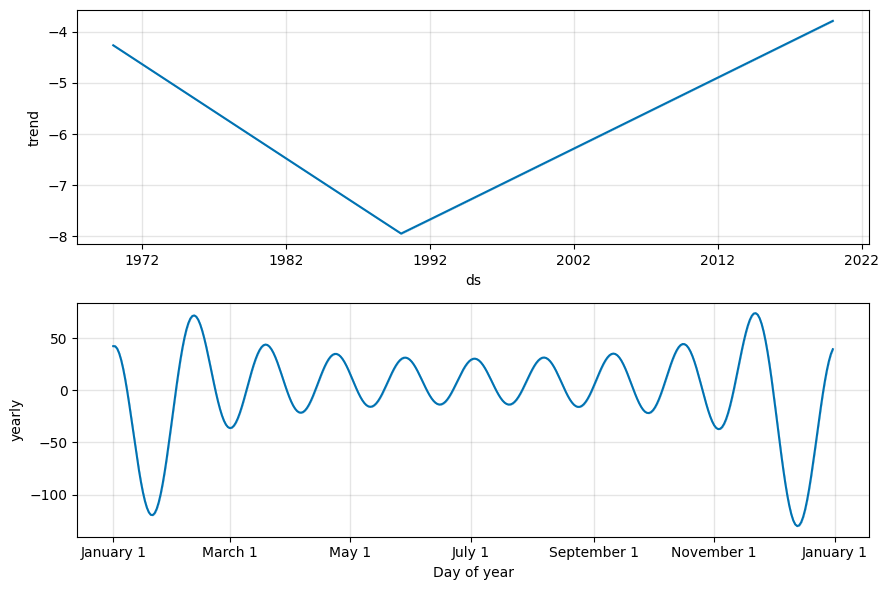

04:10:32 - cmdstanpy - INFO - Chain [1] start processing
04:10:32 - cmdstanpy - INFO - Chain [1] done processing


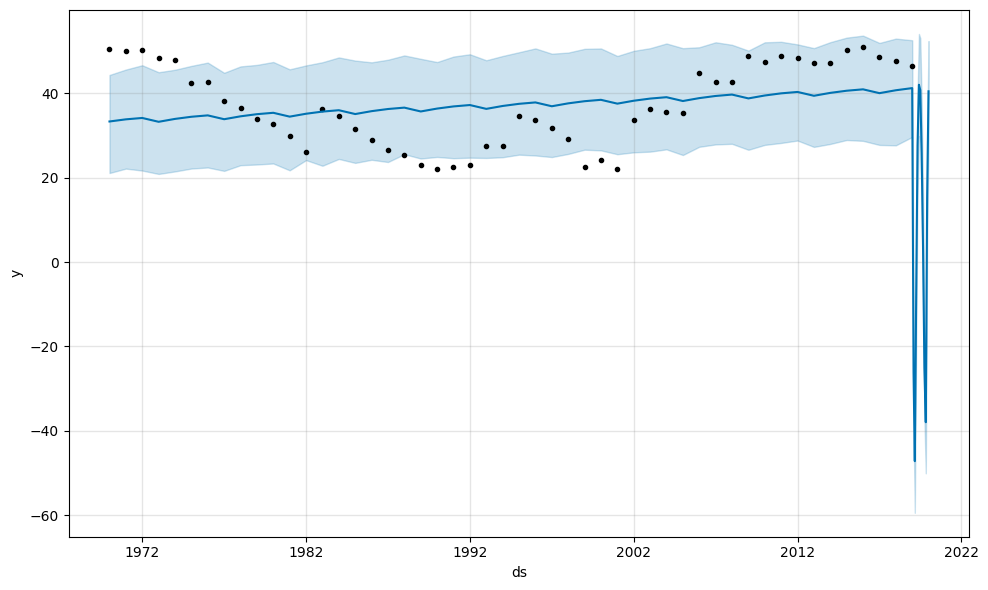

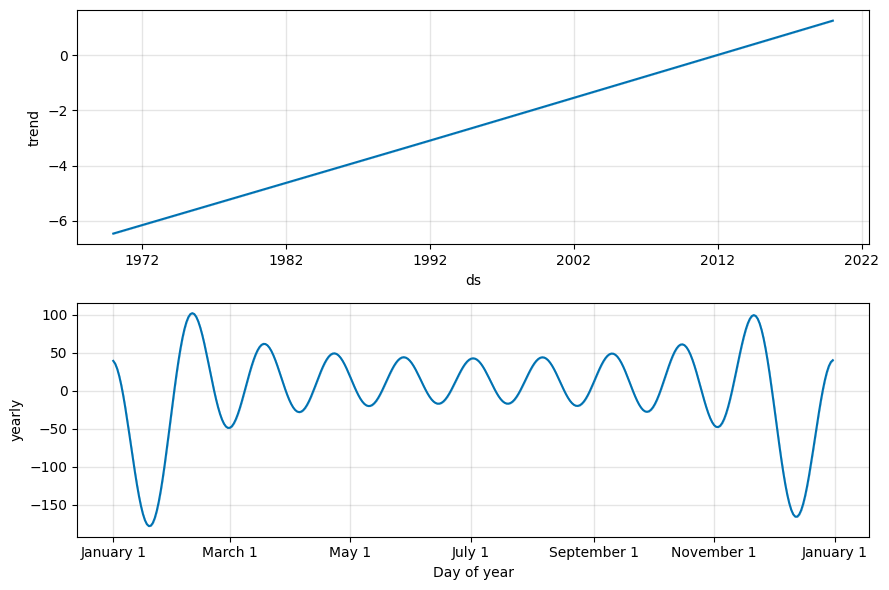

04:10:33 - cmdstanpy - INFO - Chain [1] start processing
04:10:33 - cmdstanpy - INFO - Chain [1] done processing


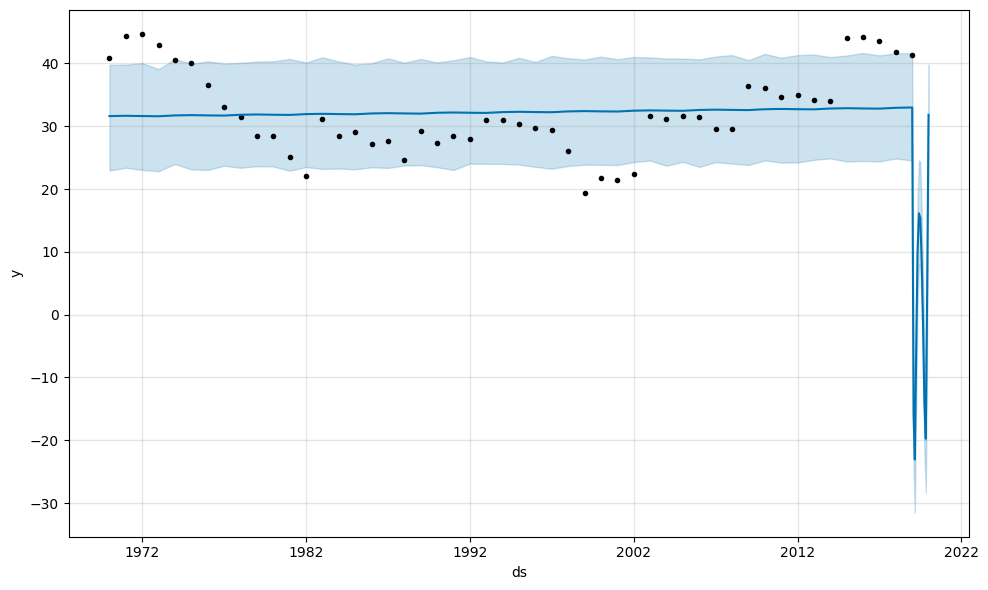

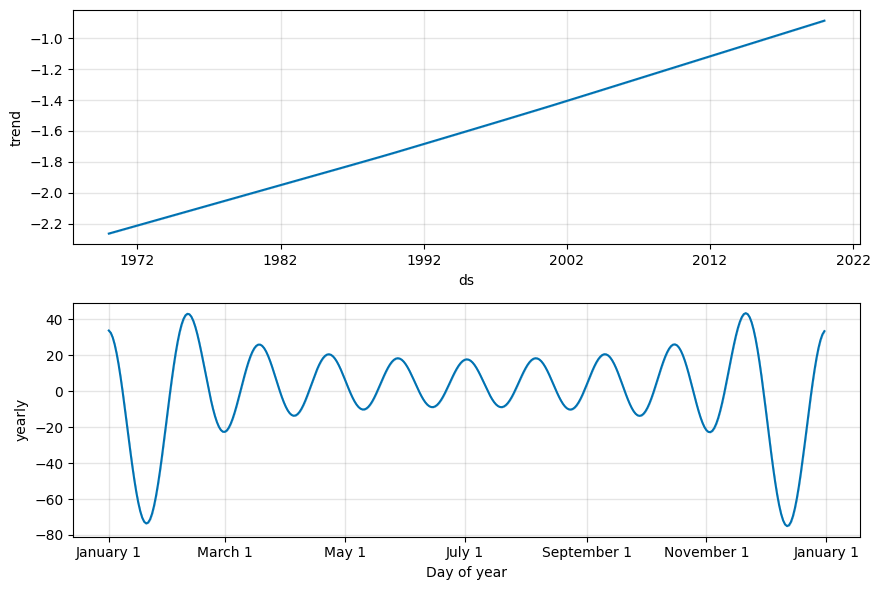

04:10:33 - cmdstanpy - INFO - Chain [1] start processing
04:10:34 - cmdstanpy - INFO - Chain [1] done processing


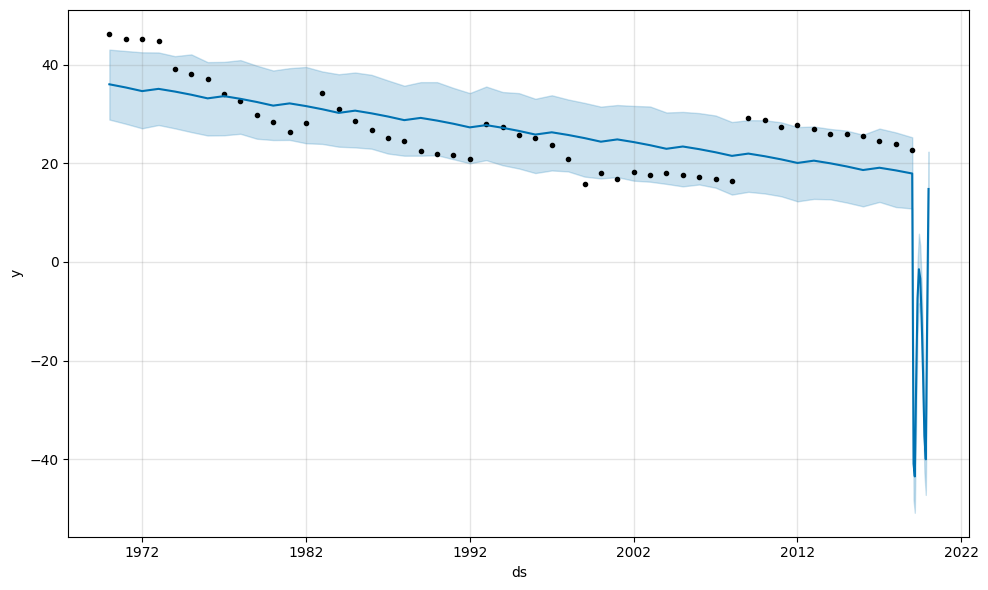

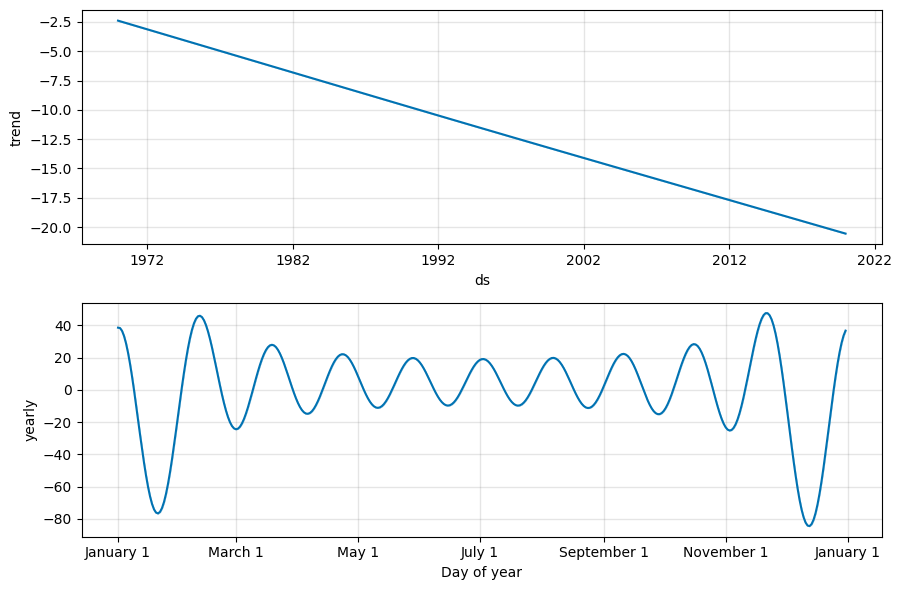

04:10:34 - cmdstanpy - INFO - Chain [1] start processing
04:10:34 - cmdstanpy - INFO - Chain [1] done processing


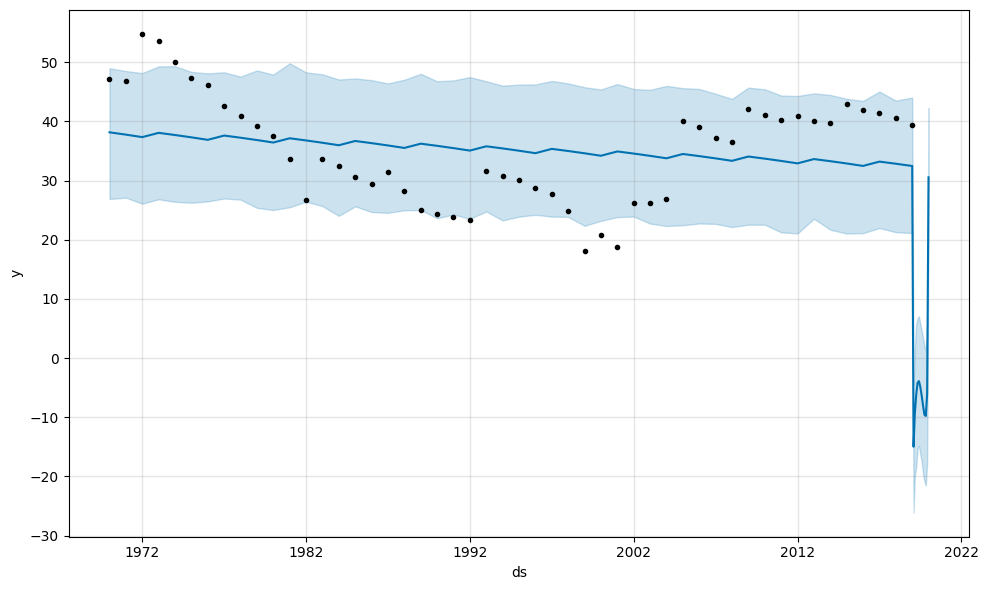

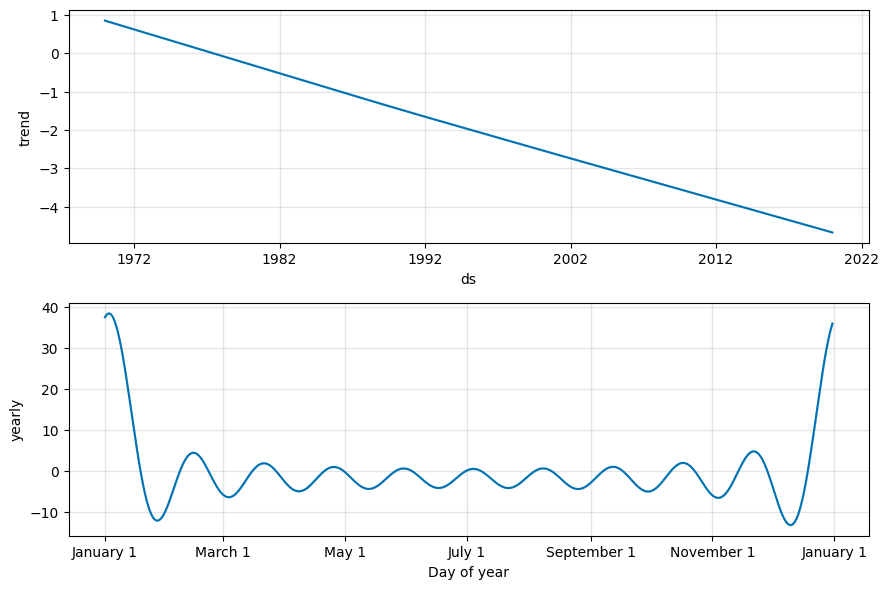

04:10:35 - cmdstanpy - INFO - Chain [1] start processing
04:10:35 - cmdstanpy - INFO - Chain [1] done processing


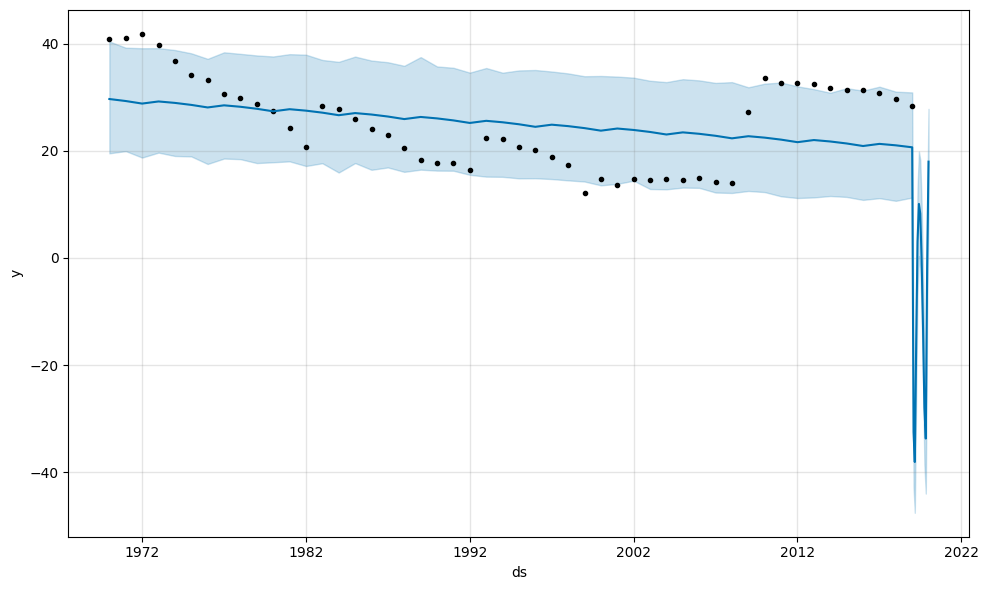

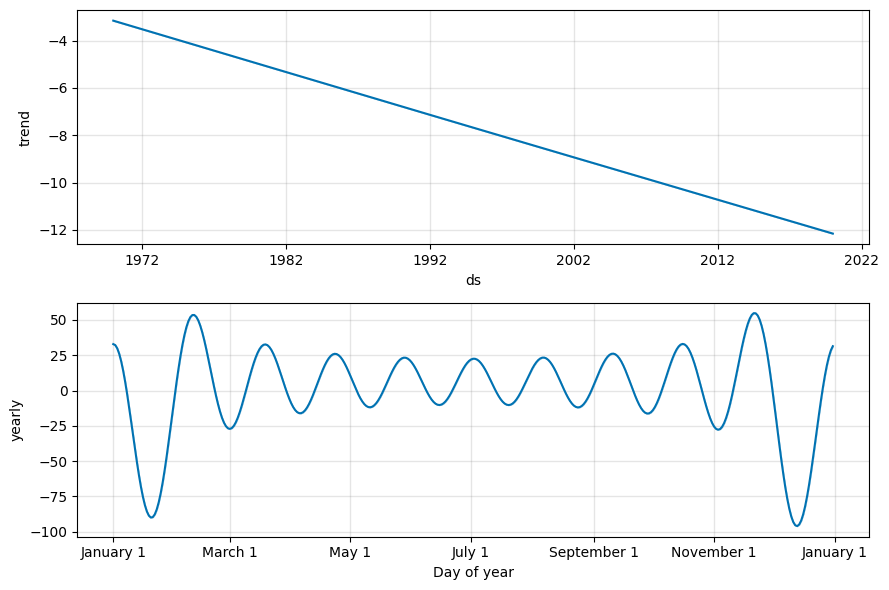

04:10:36 - cmdstanpy - INFO - Chain [1] start processing
04:10:36 - cmdstanpy - INFO - Chain [1] done processing


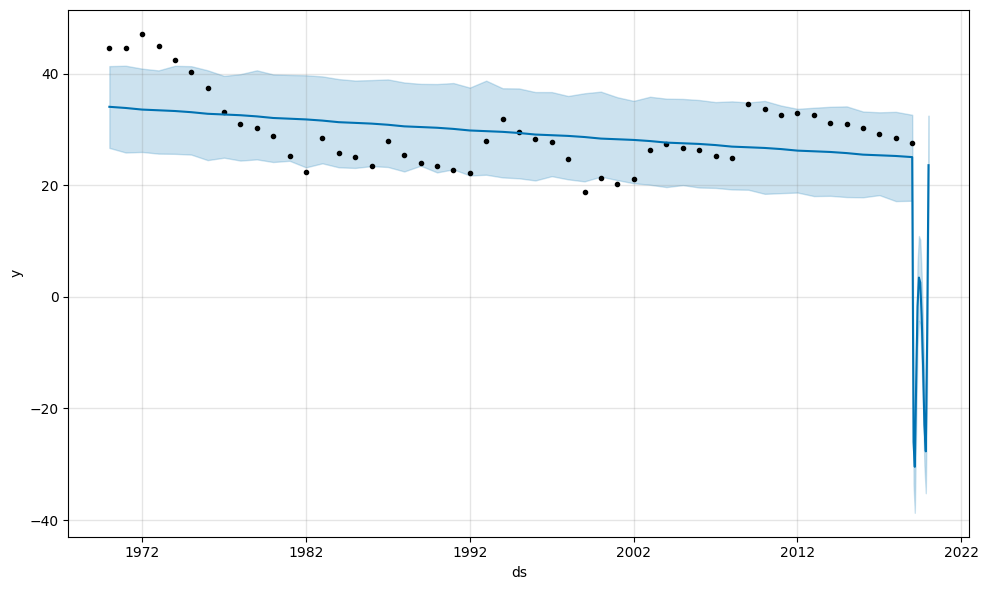

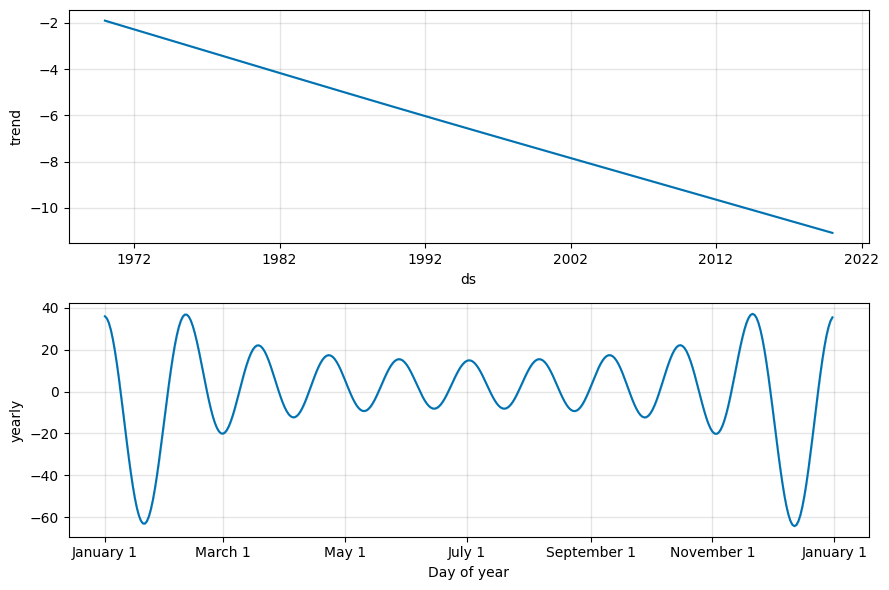

04:10:36 - cmdstanpy - INFO - Chain [1] start processing
04:10:36 - cmdstanpy - INFO - Chain [1] done processing


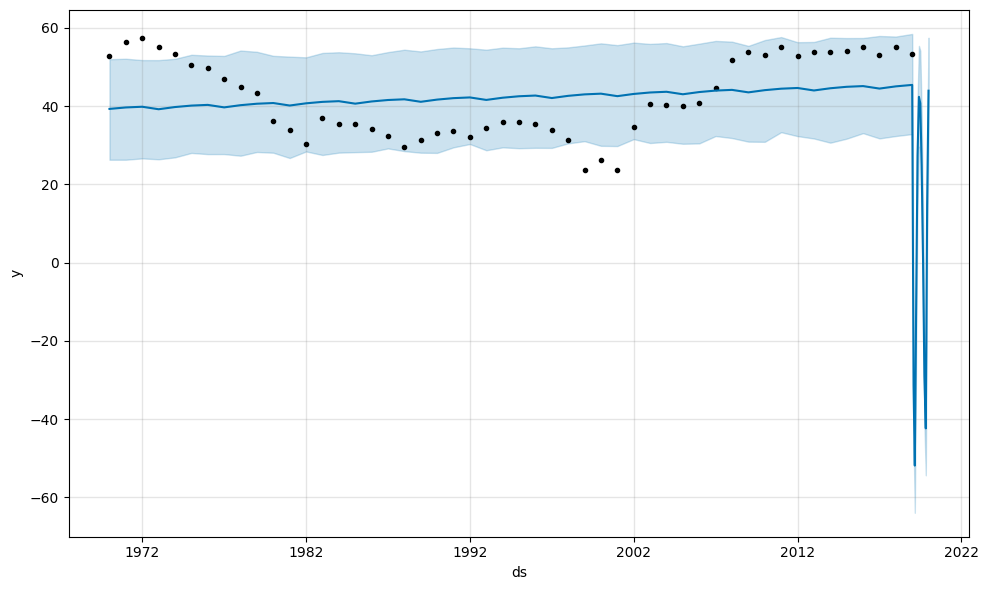

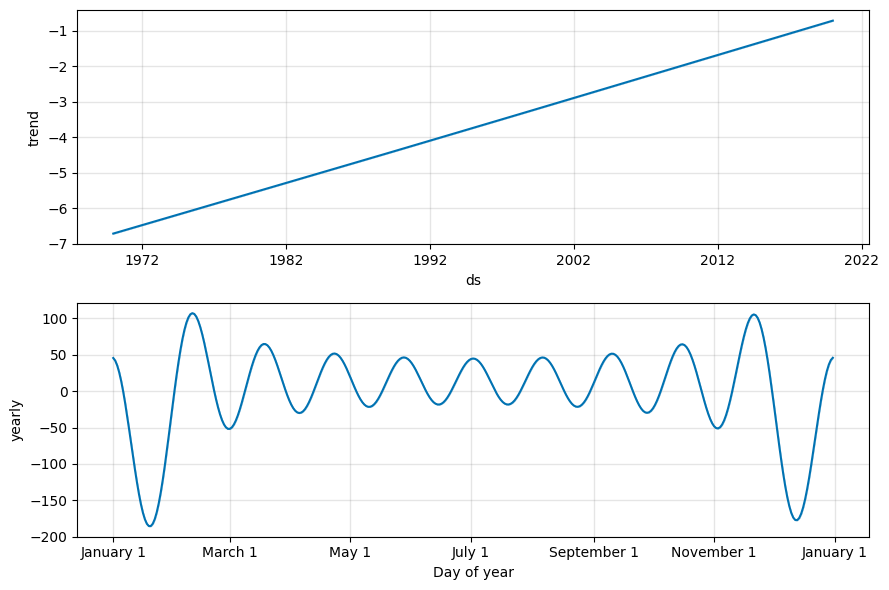

04:10:37 - cmdstanpy - INFO - Chain [1] start processing
04:10:37 - cmdstanpy - INFO - Chain [1] done processing


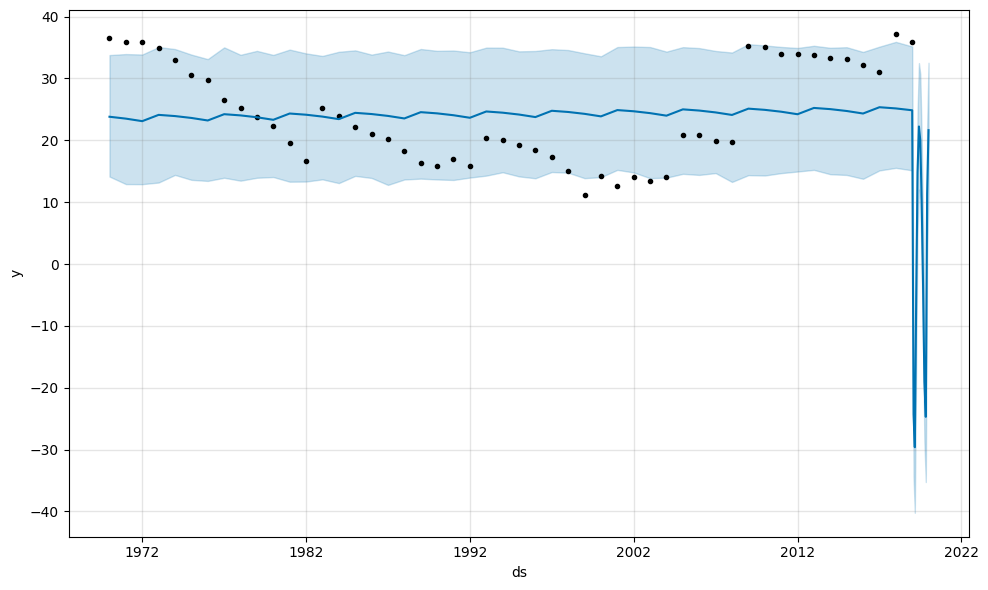

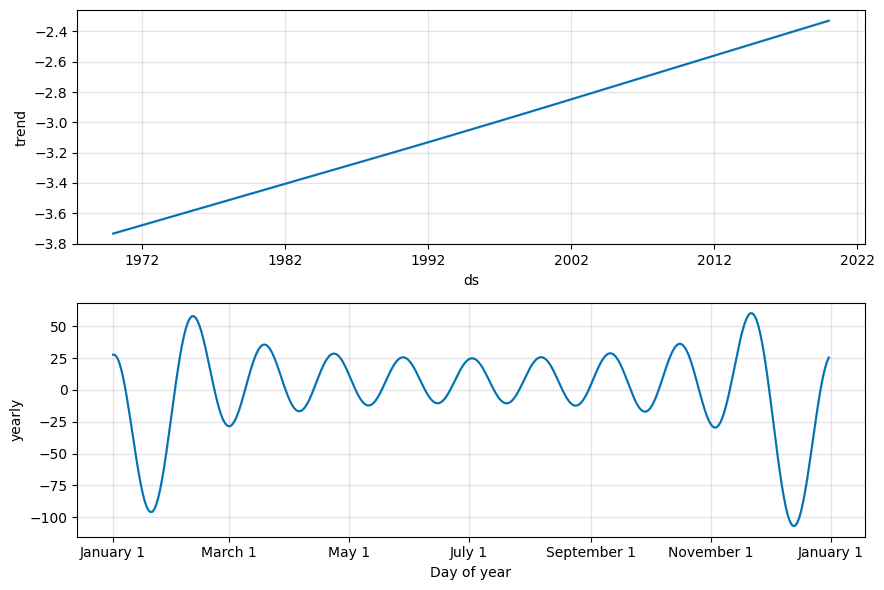

04:10:38 - cmdstanpy - INFO - Chain [1] start processing
04:10:38 - cmdstanpy - INFO - Chain [1] done processing


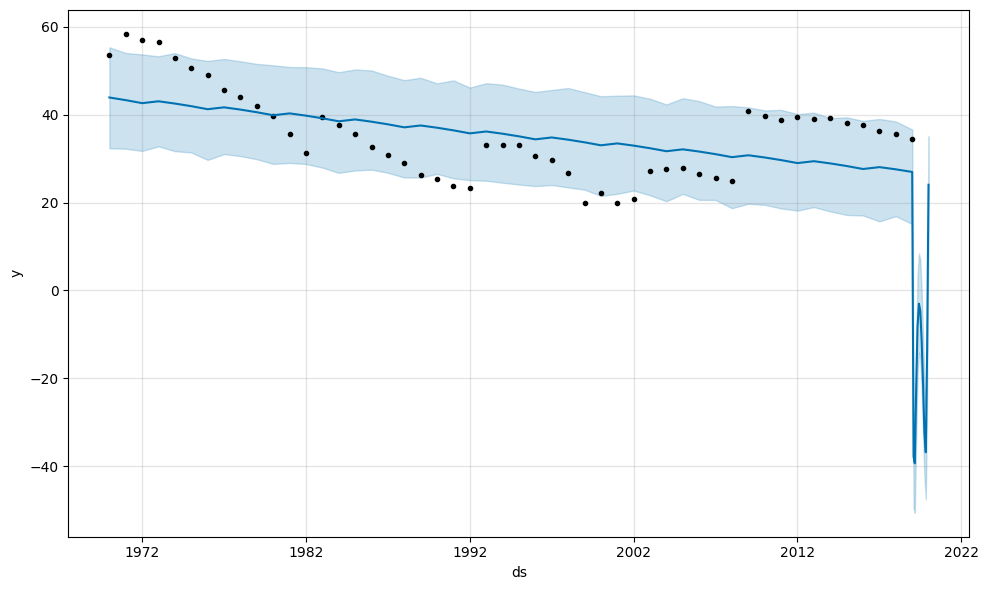

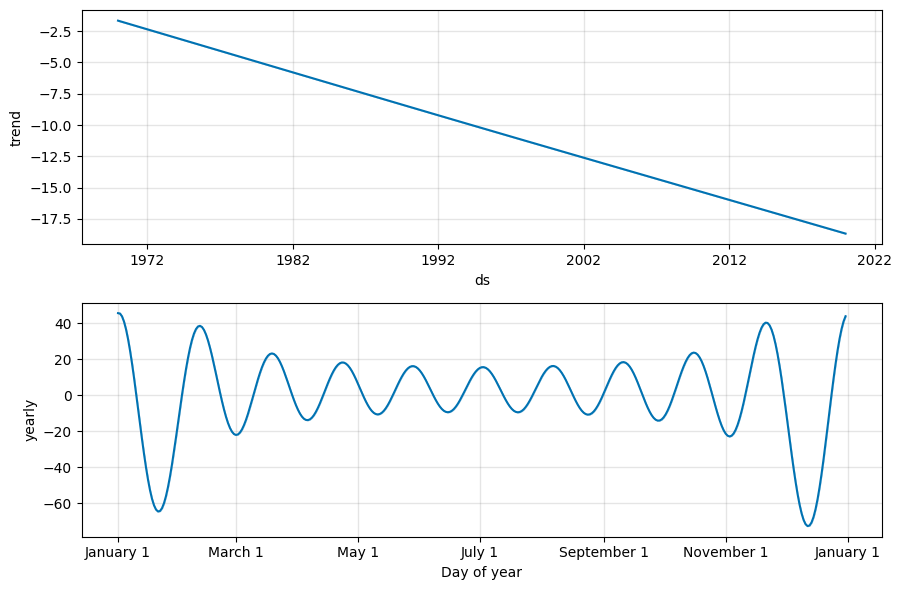

04:10:38 - cmdstanpy - INFO - Chain [1] start processing
04:10:38 - cmdstanpy - INFO - Chain [1] done processing


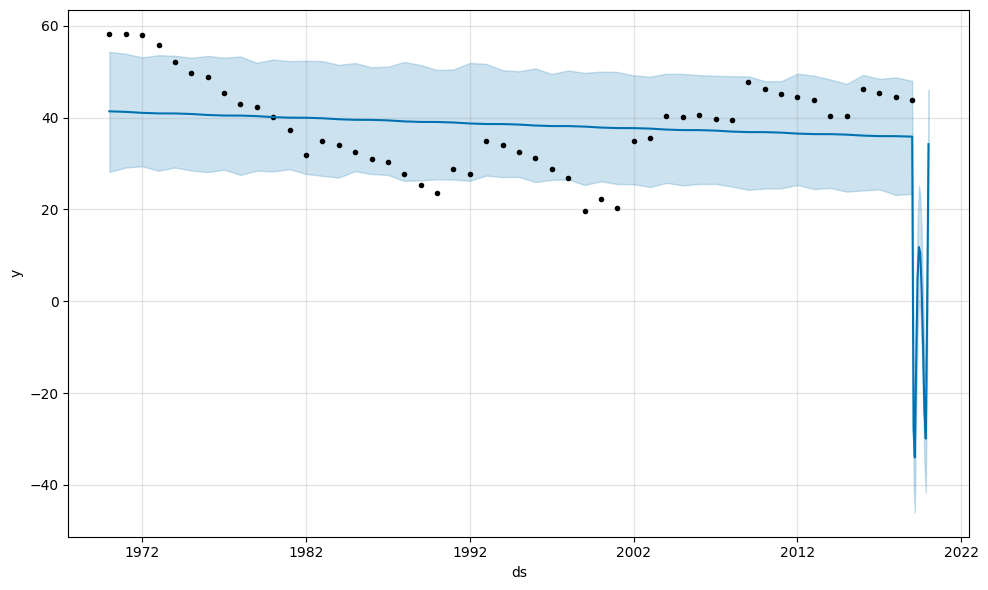

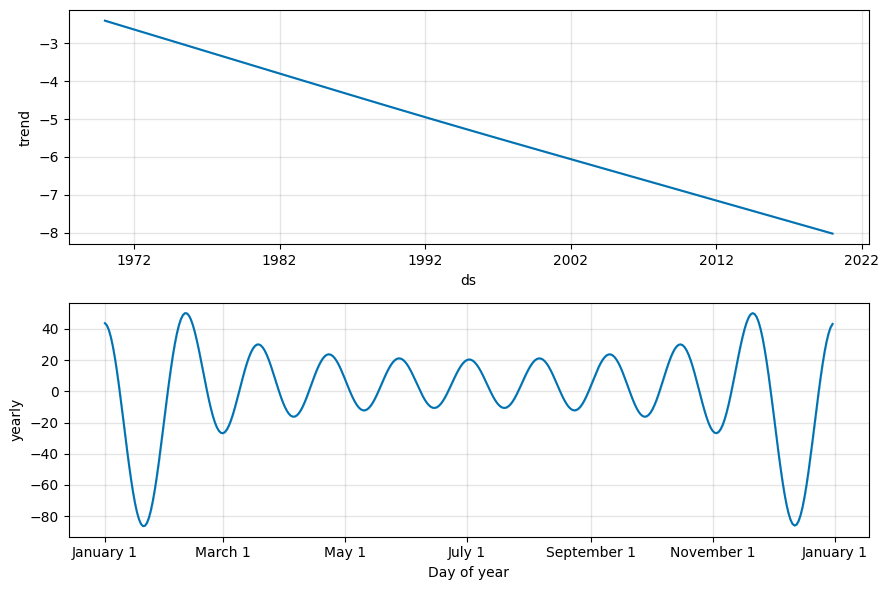

04:10:39 - cmdstanpy - INFO - Chain [1] start processing
04:10:39 - cmdstanpy - INFO - Chain [1] done processing


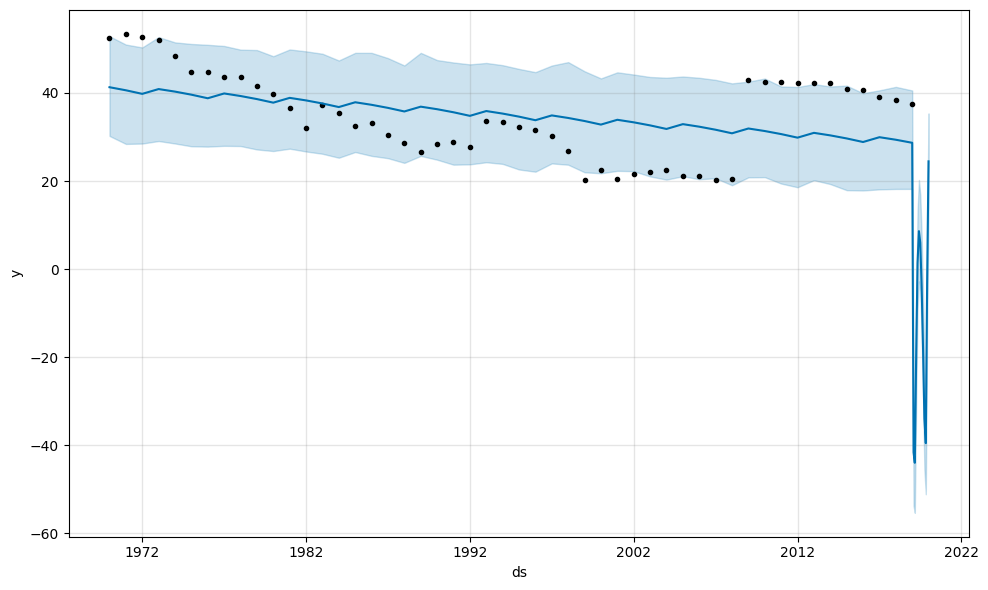

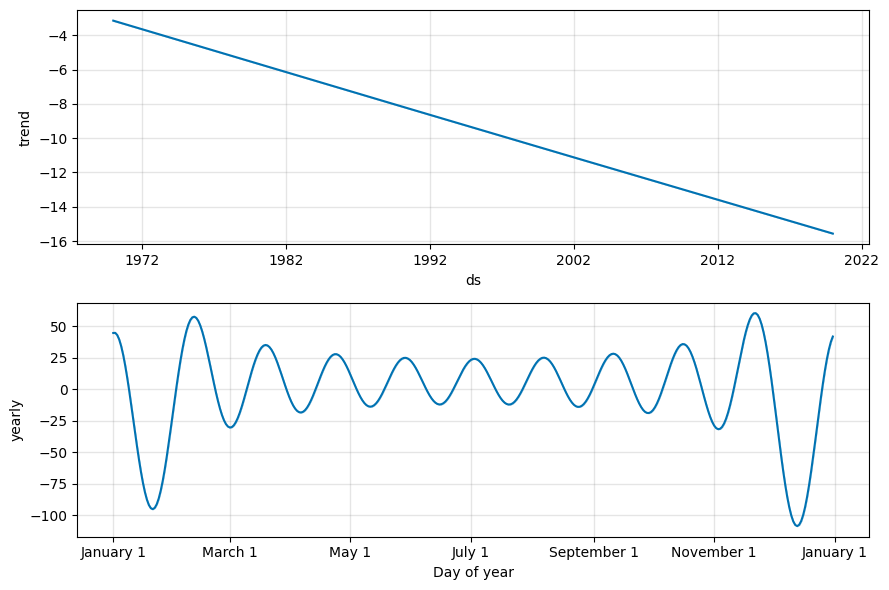

04:10:40 - cmdstanpy - INFO - Chain [1] start processing
04:10:40 - cmdstanpy - INFO - Chain [1] done processing


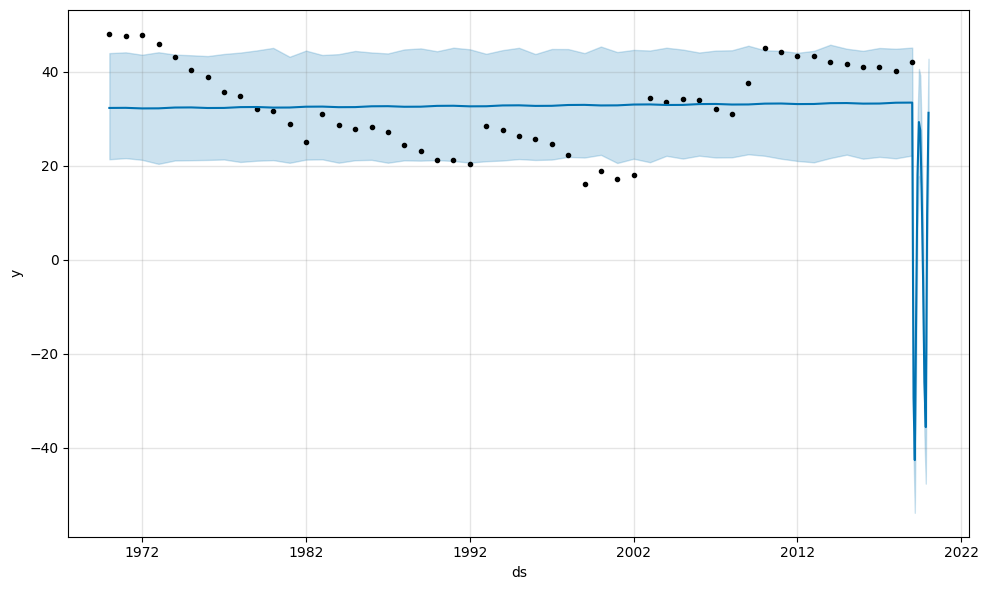

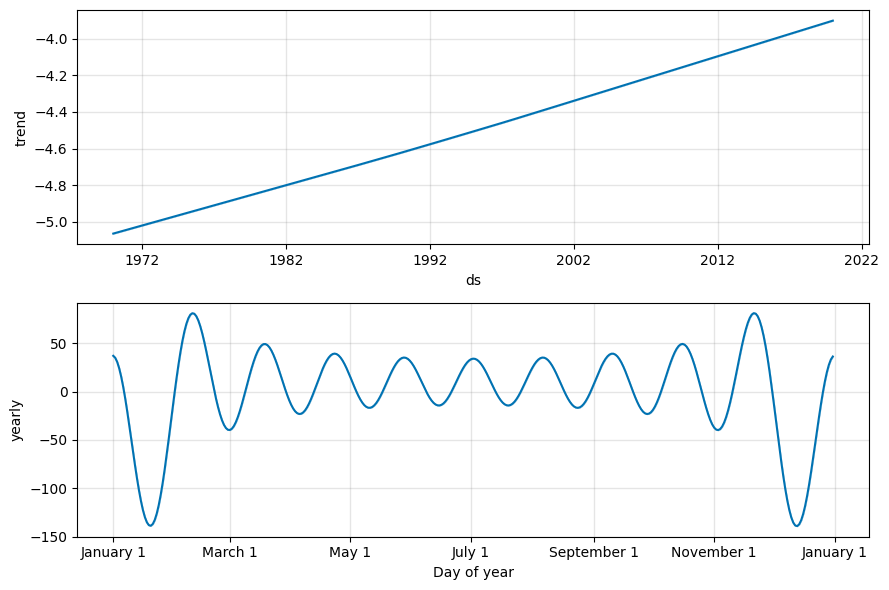

04:10:40 - cmdstanpy - INFO - Chain [1] start processing
04:10:41 - cmdstanpy - INFO - Chain [1] done processing


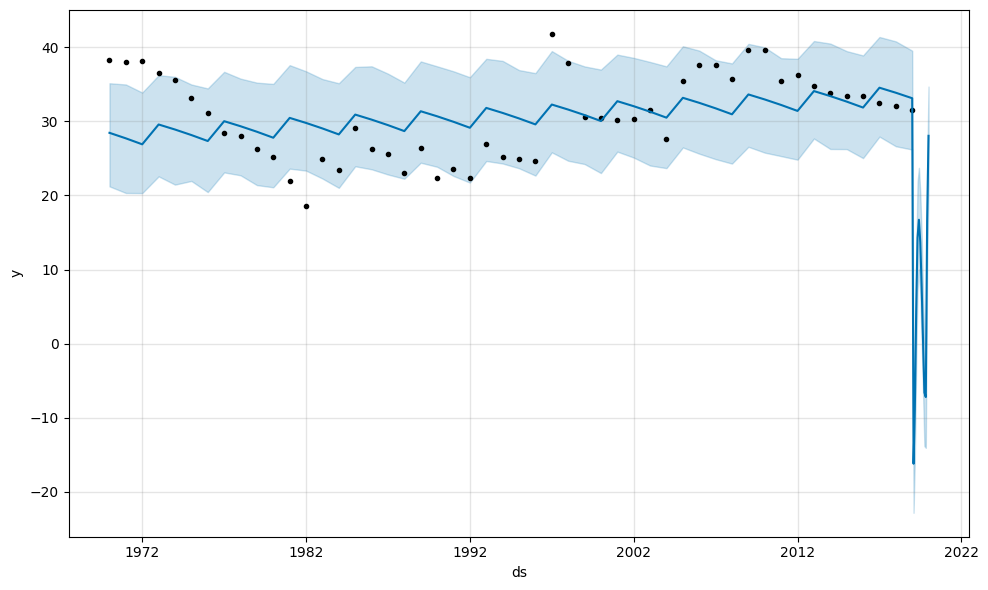

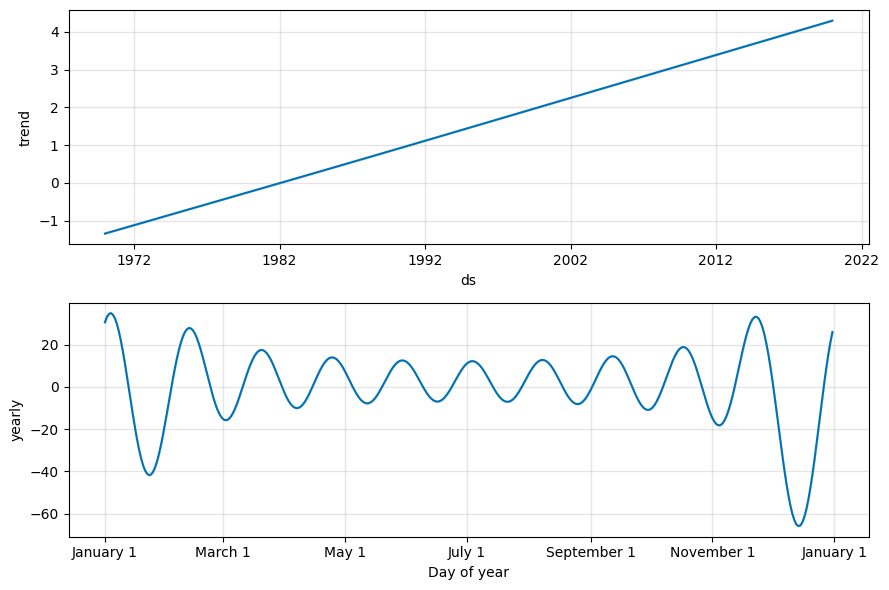

04:10:41 - cmdstanpy - INFO - Chain [1] start processing
04:10:41 - cmdstanpy - INFO - Chain [1] done processing


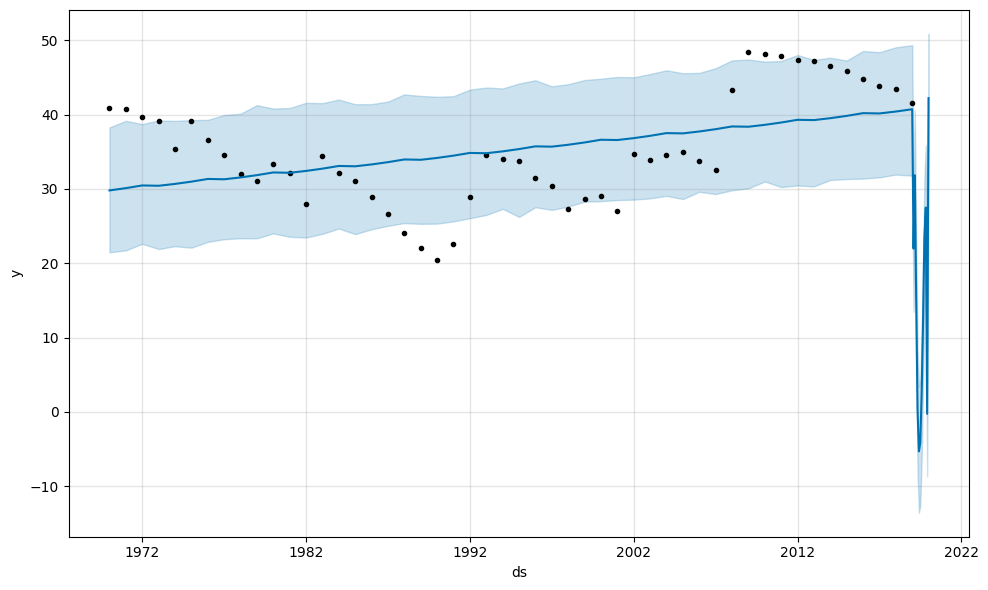

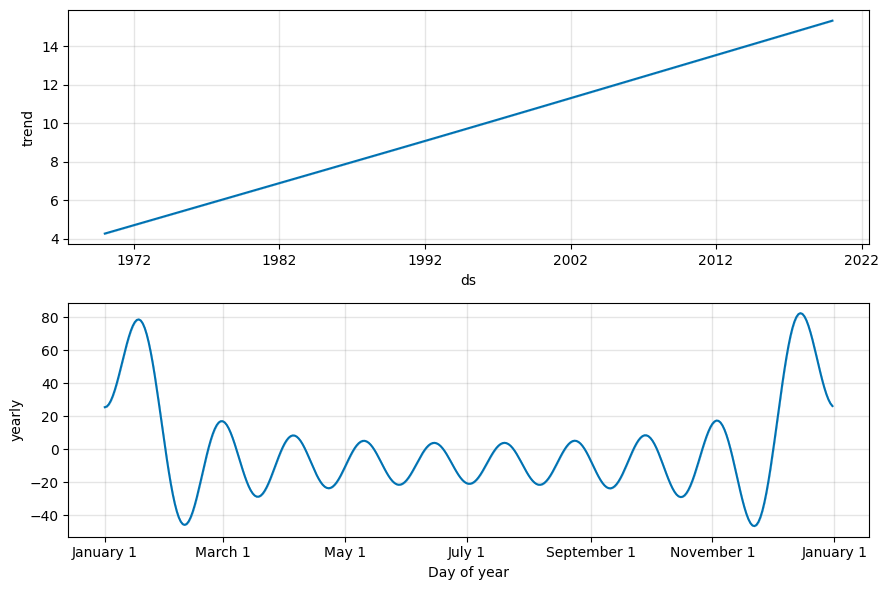

04:10:42 - cmdstanpy - INFO - Chain [1] start processing
04:10:42 - cmdstanpy - INFO - Chain [1] done processing


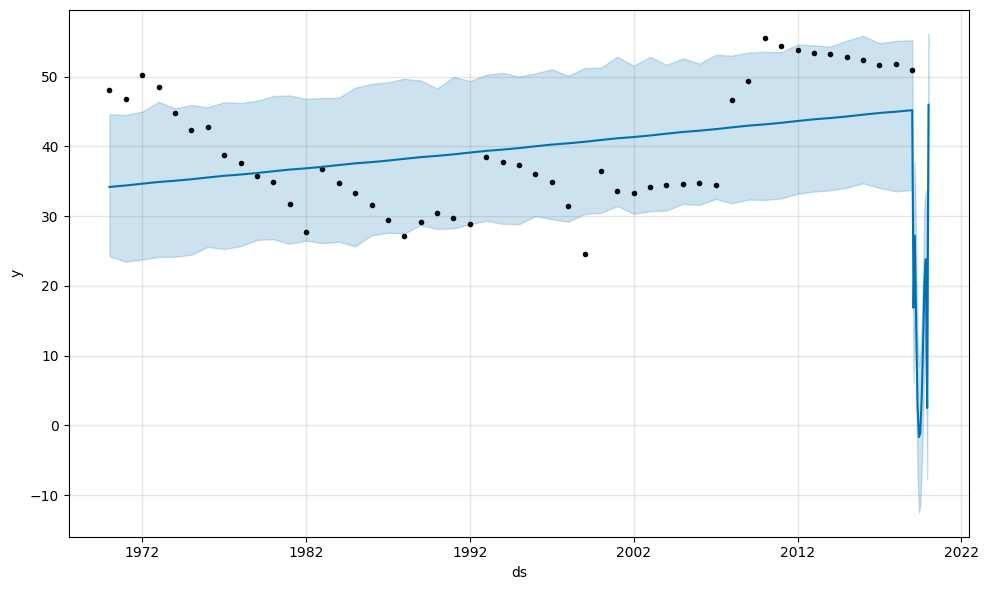

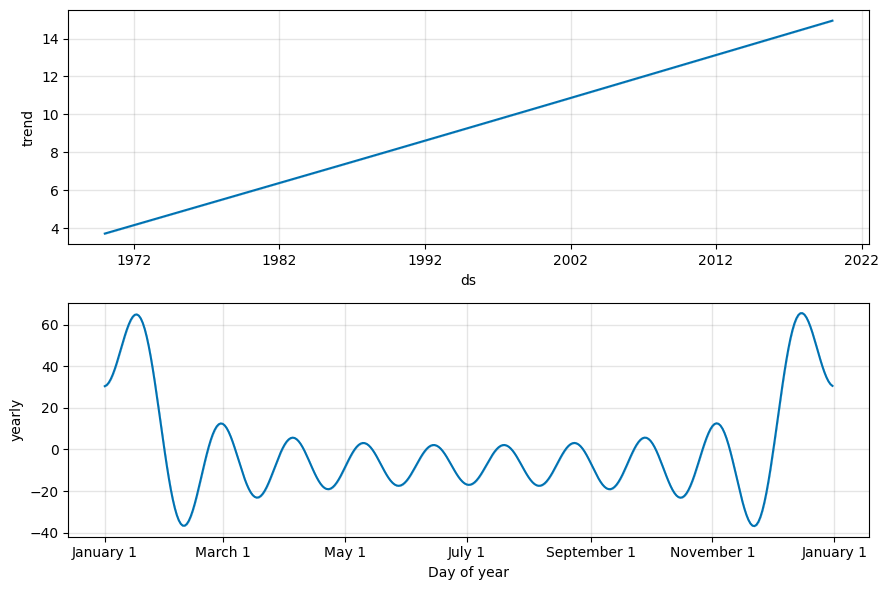

04:10:42 - cmdstanpy - INFO - Chain [1] start processing
04:10:43 - cmdstanpy - INFO - Chain [1] done processing


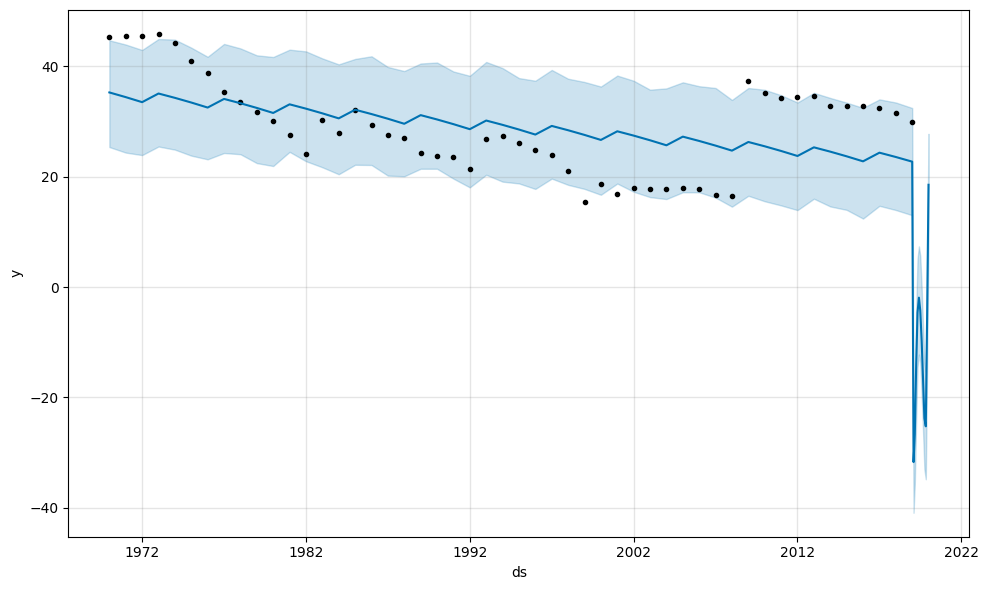

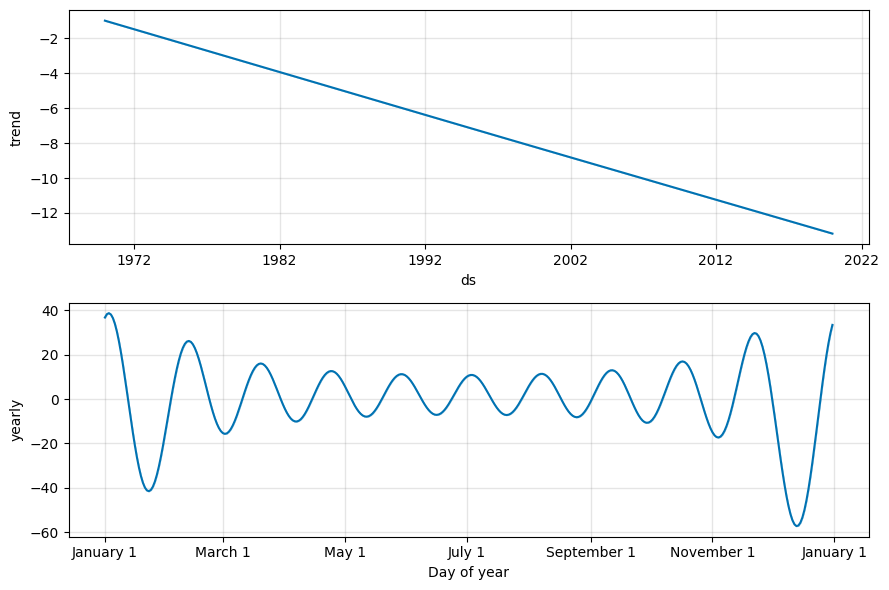

04:10:43 - cmdstanpy - INFO - Chain [1] start processing
04:10:43 - cmdstanpy - INFO - Chain [1] done processing


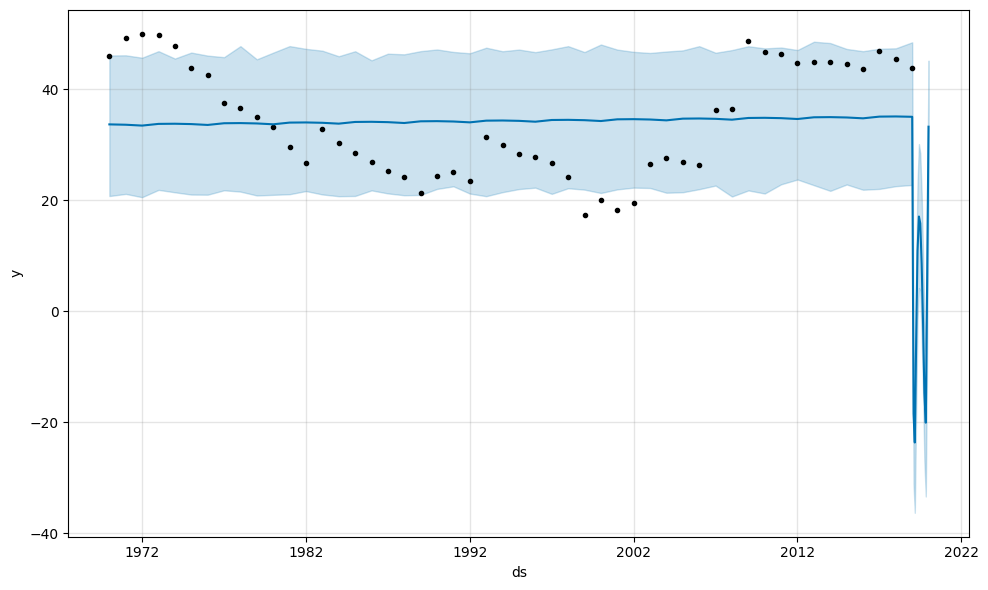

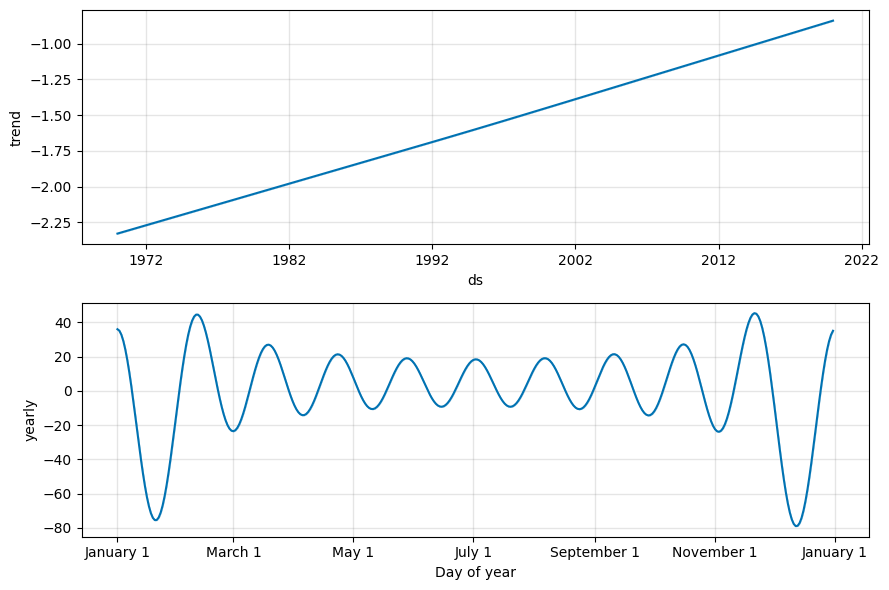

04:10:44 - cmdstanpy - INFO - Chain [1] start processing
04:10:44 - cmdstanpy - INFO - Chain [1] done processing


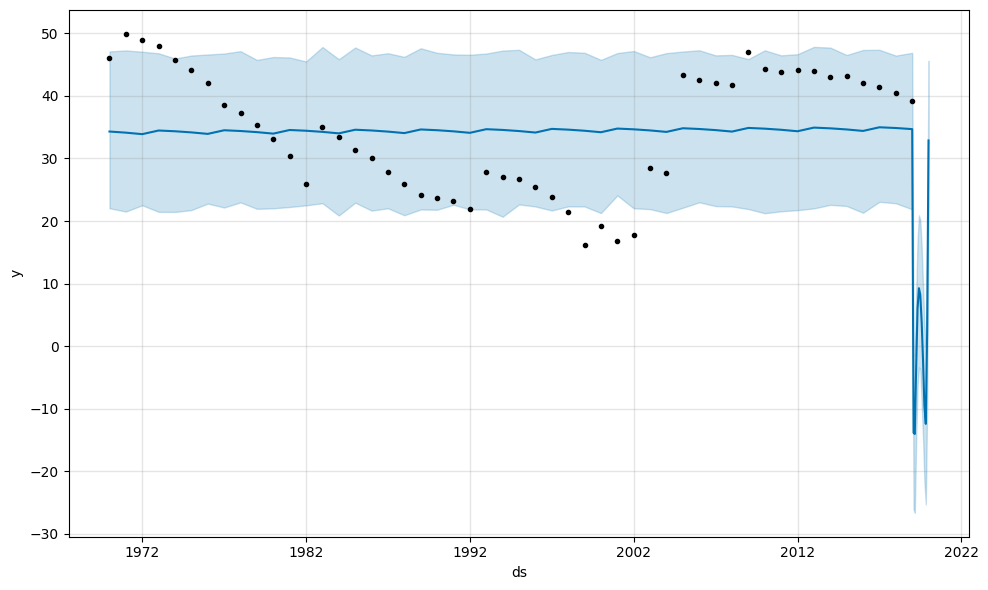

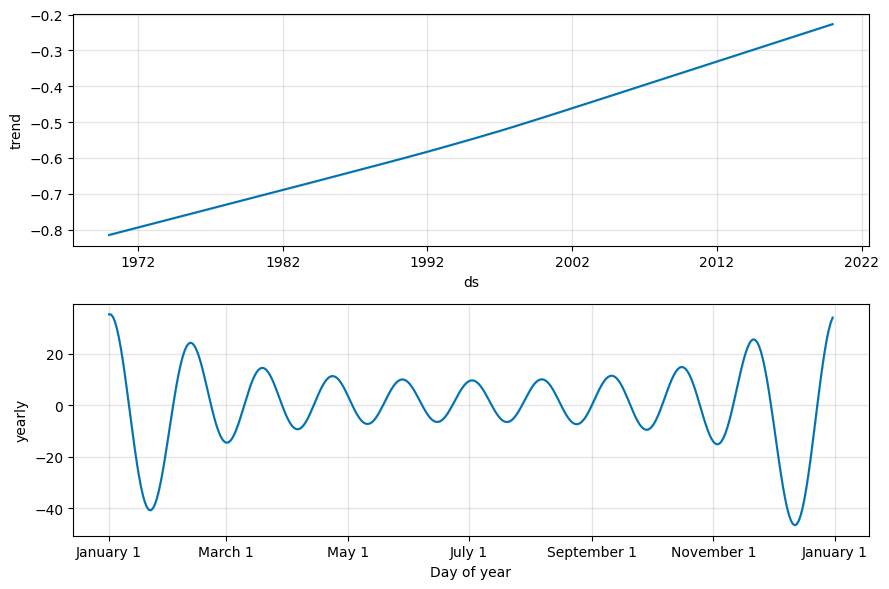

04:10:45 - cmdstanpy - INFO - Chain [1] start processing
04:10:45 - cmdstanpy - INFO - Chain [1] done processing


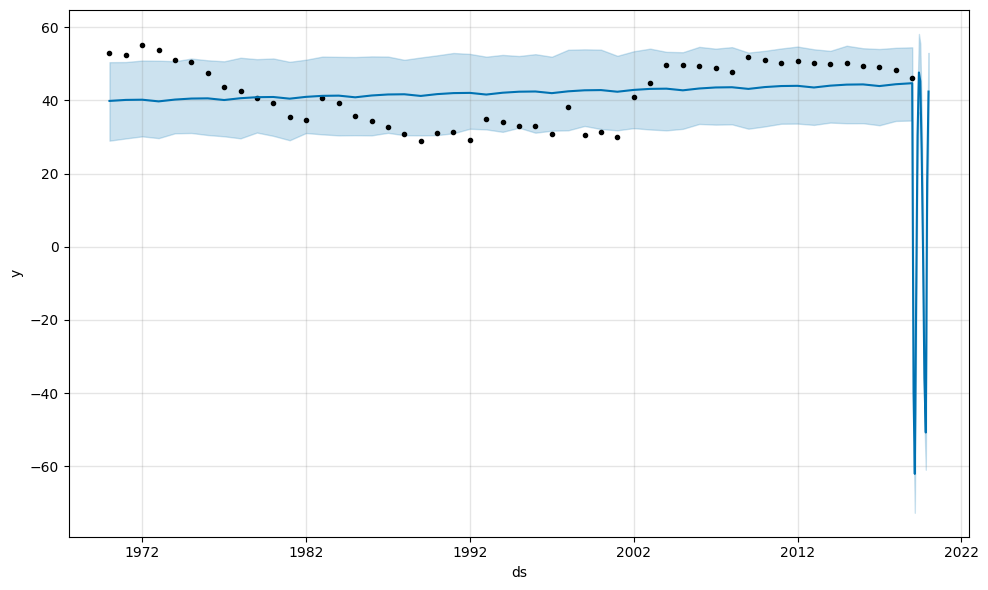

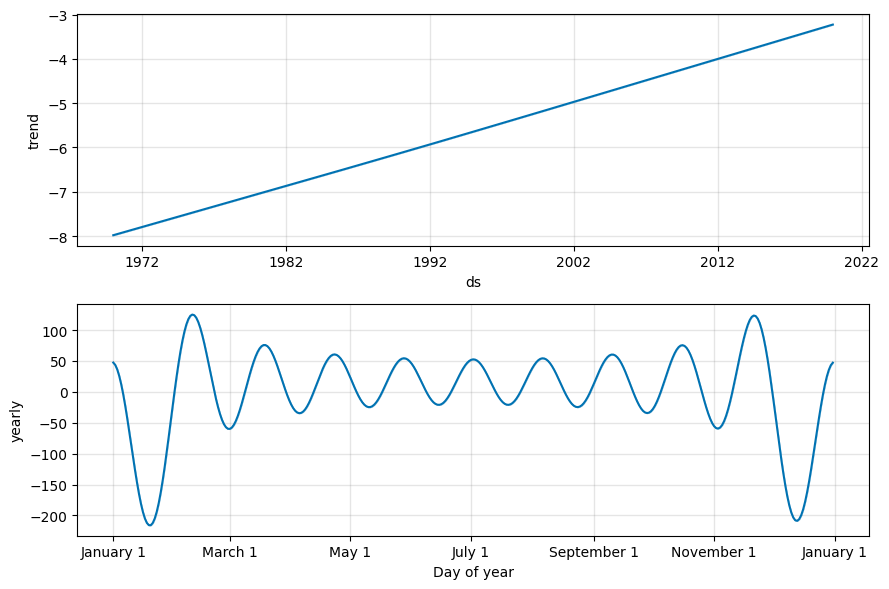

04:10:45 - cmdstanpy - INFO - Chain [1] start processing
04:10:45 - cmdstanpy - INFO - Chain [1] done processing


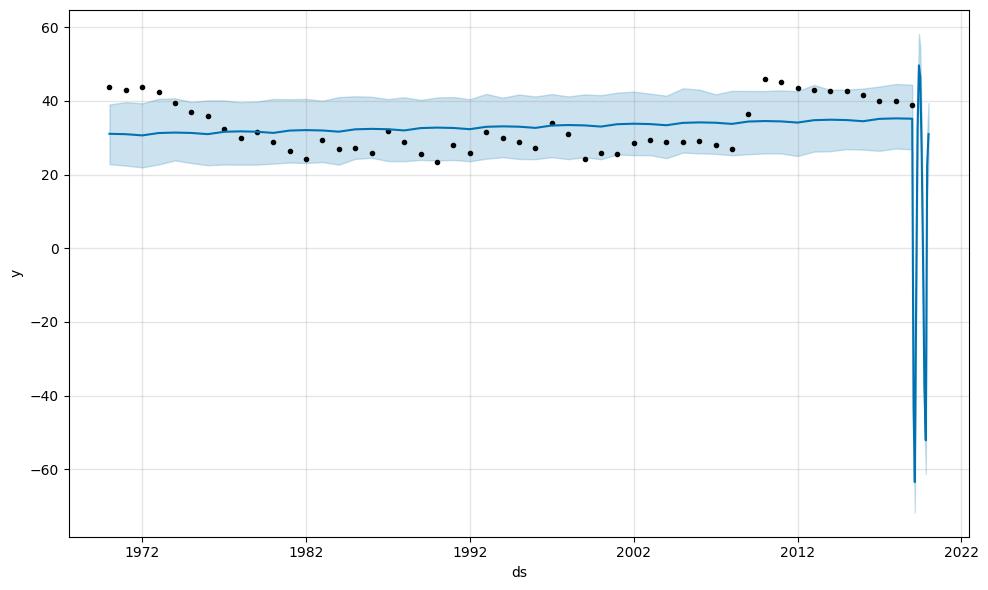

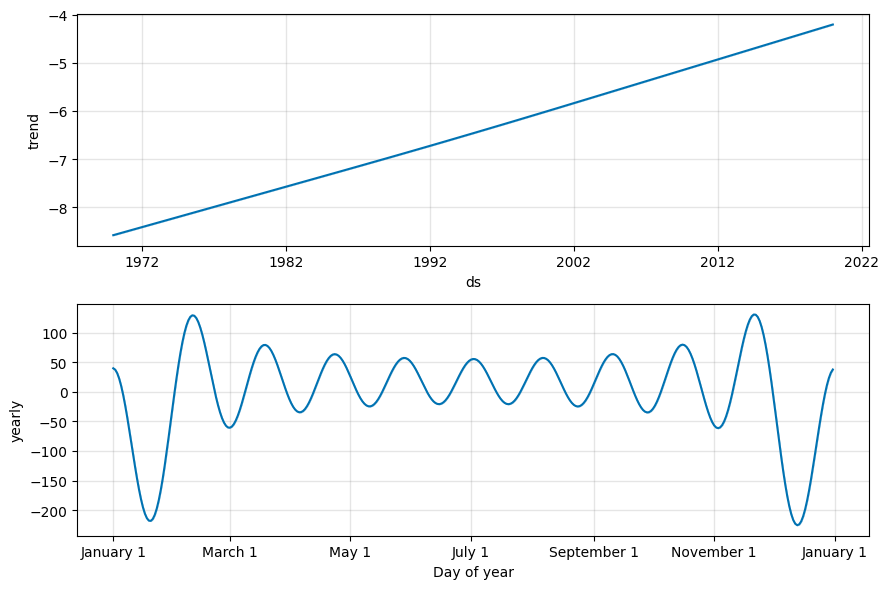

04:10:46 - cmdstanpy - INFO - Chain [1] start processing
04:10:46 - cmdstanpy - INFO - Chain [1] done processing


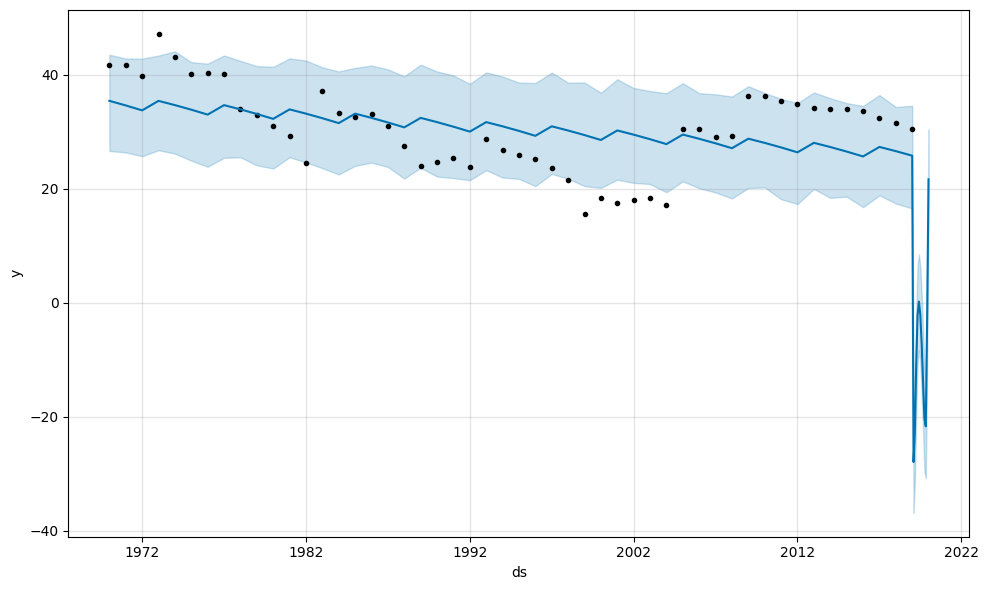

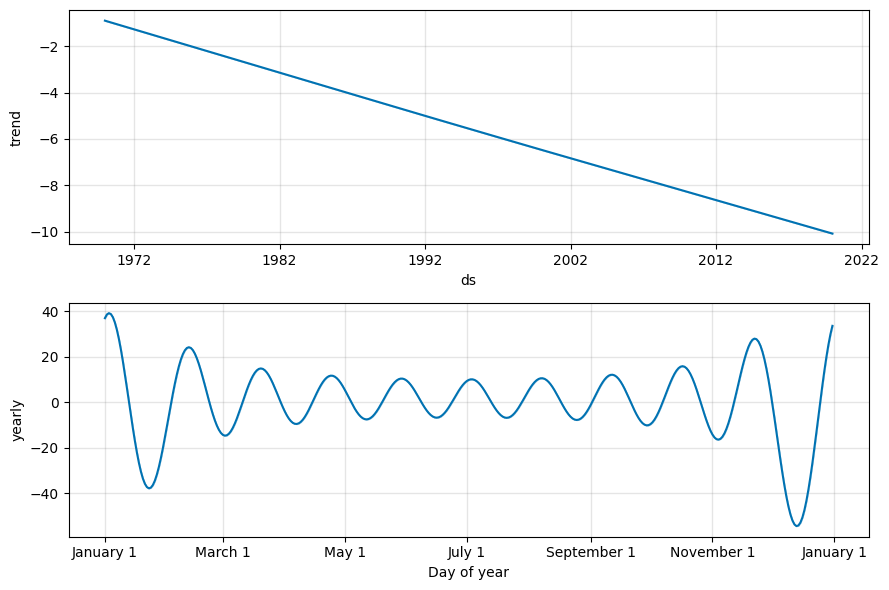

04:10:47 - cmdstanpy - INFO - Chain [1] start processing
04:10:47 - cmdstanpy - INFO - Chain [1] done processing


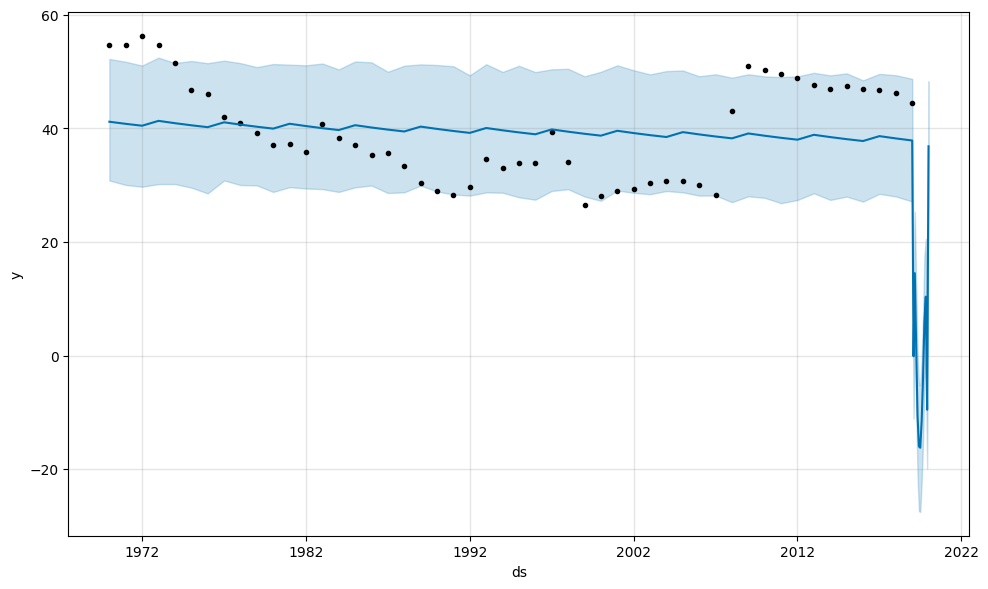

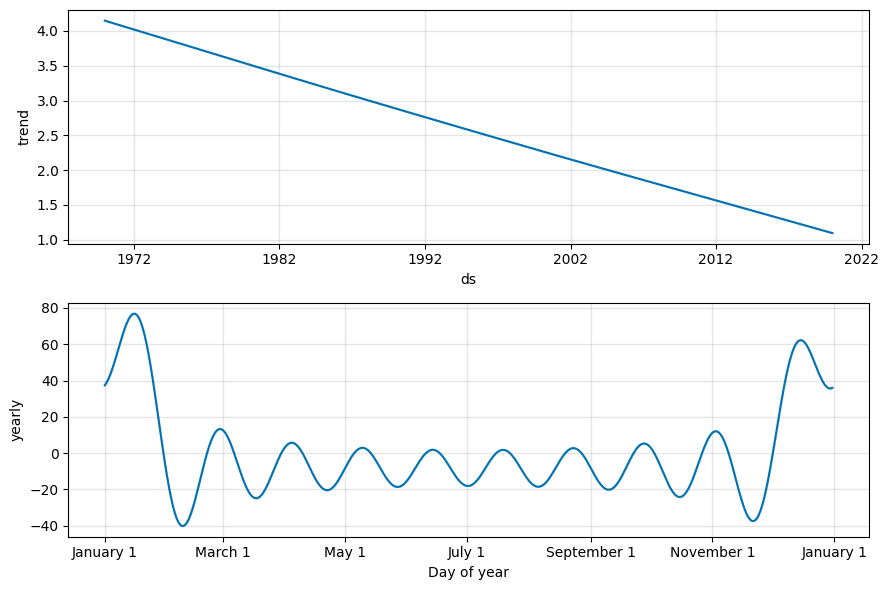

04:10:47 - cmdstanpy - INFO - Chain [1] start processing
04:10:47 - cmdstanpy - INFO - Chain [1] done processing


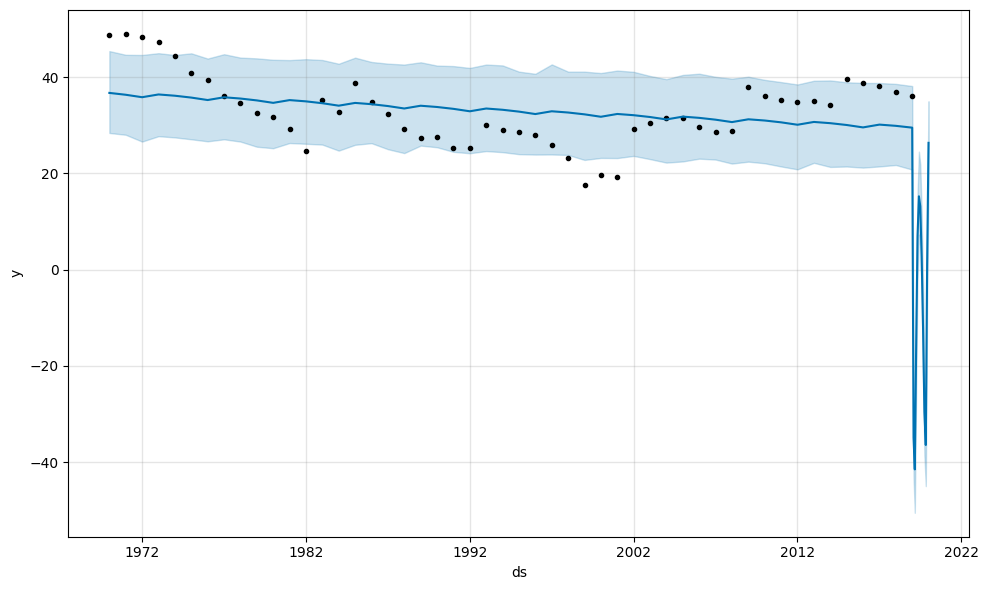

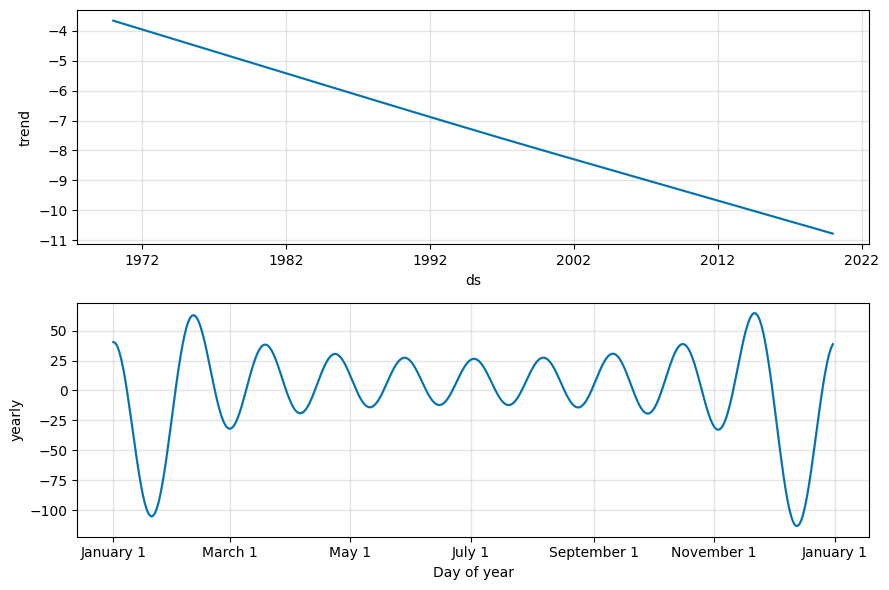

04:10:48 - cmdstanpy - INFO - Chain [1] start processing
04:10:48 - cmdstanpy - INFO - Chain [1] done processing


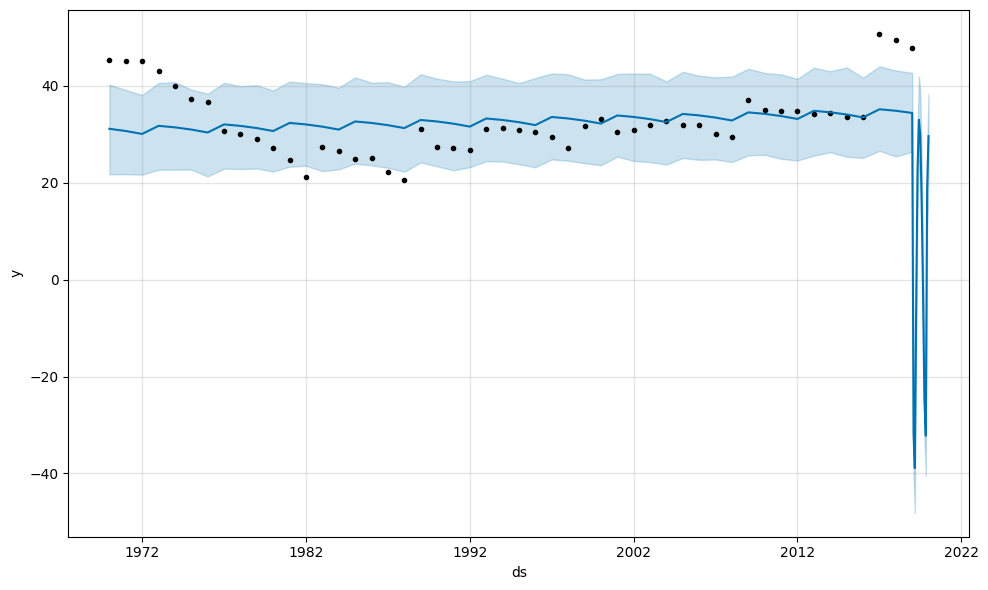

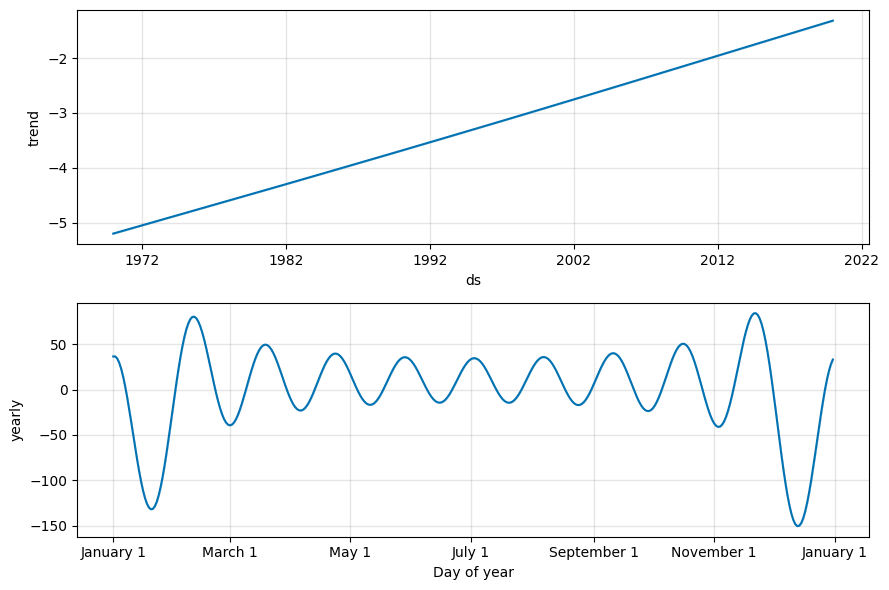

04:10:48 - cmdstanpy - INFO - Chain [1] start processing
04:10:49 - cmdstanpy - INFO - Chain [1] done processing


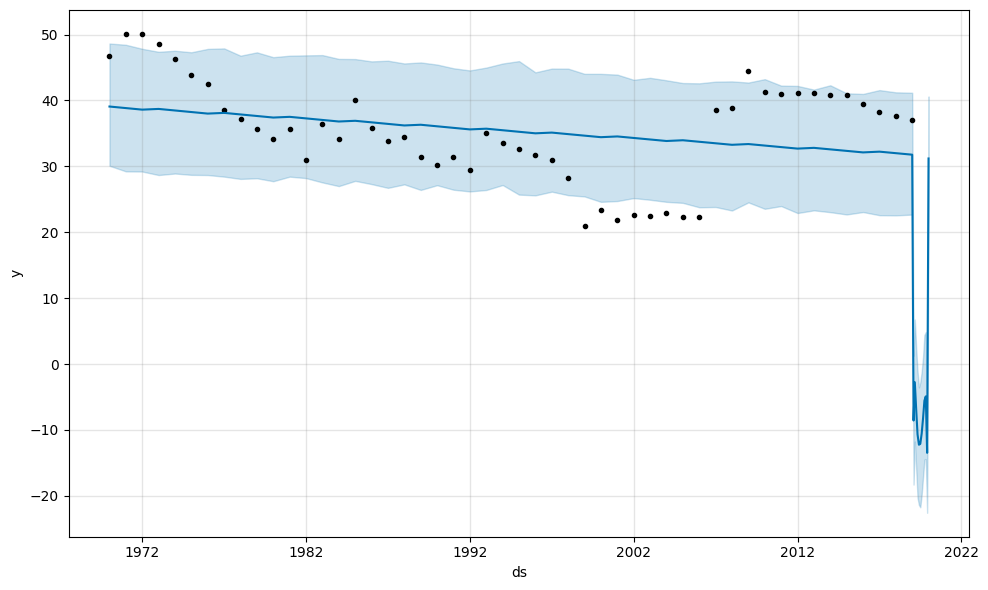

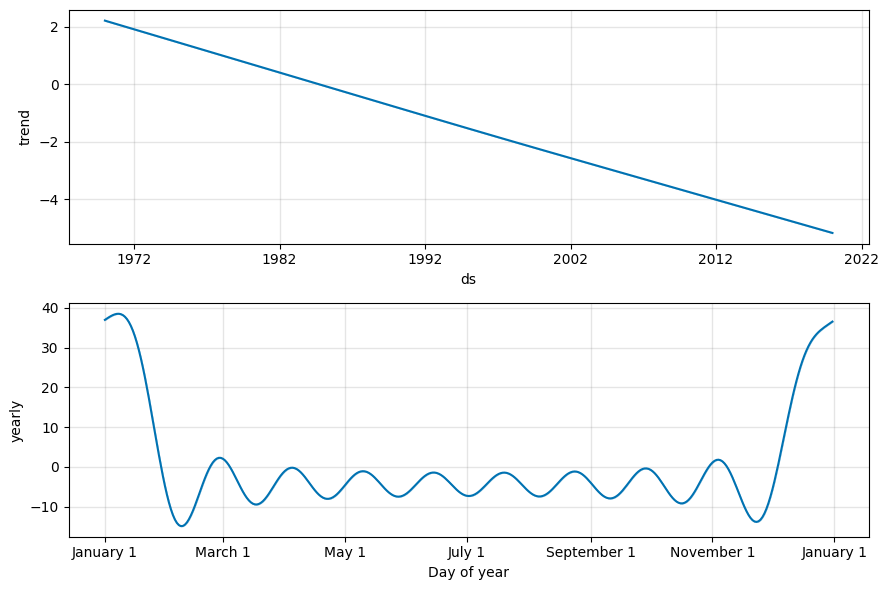

04:10:49 - cmdstanpy - INFO - Chain [1] start processing
04:10:50 - cmdstanpy - INFO - Chain [1] done processing


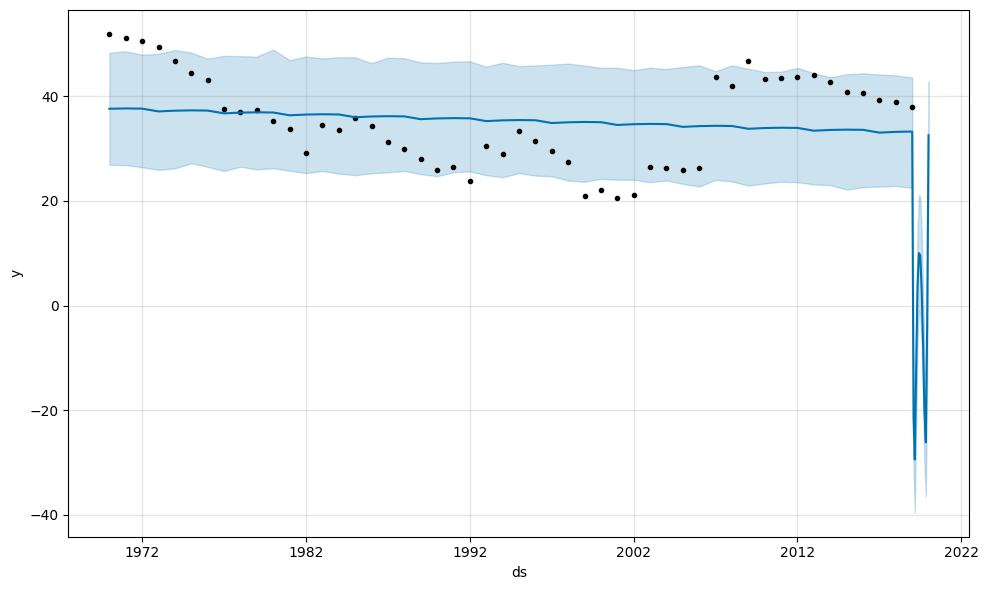

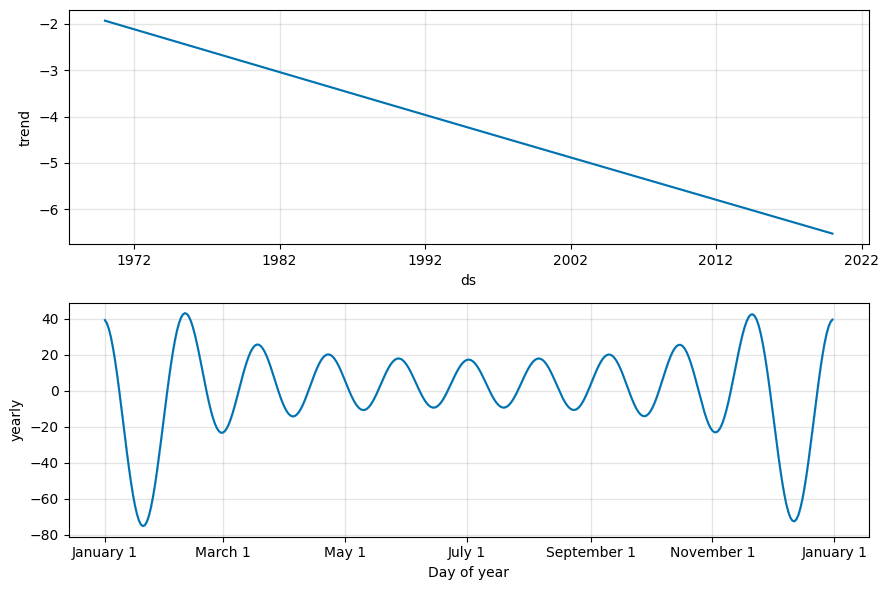

04:10:50 - cmdstanpy - INFO - Chain [1] start processing
04:10:50 - cmdstanpy - INFO - Chain [1] done processing


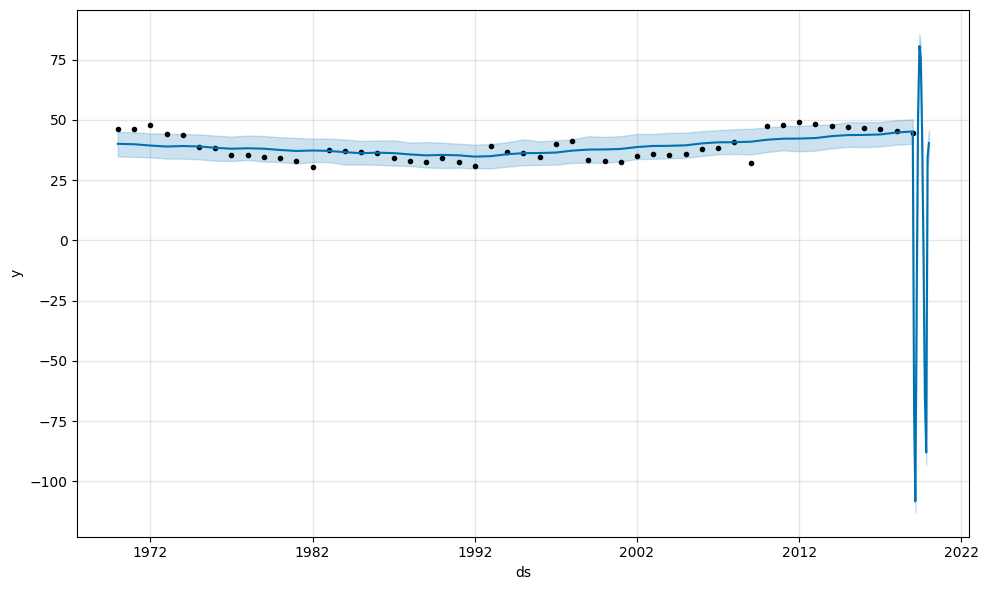

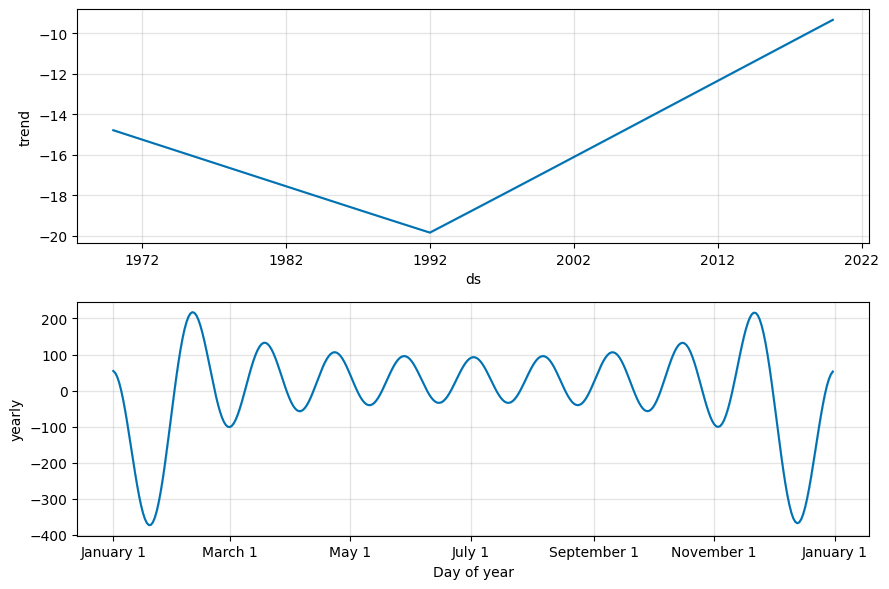

04:10:51 - cmdstanpy - INFO - Chain [1] start processing
04:10:51 - cmdstanpy - INFO - Chain [1] done processing


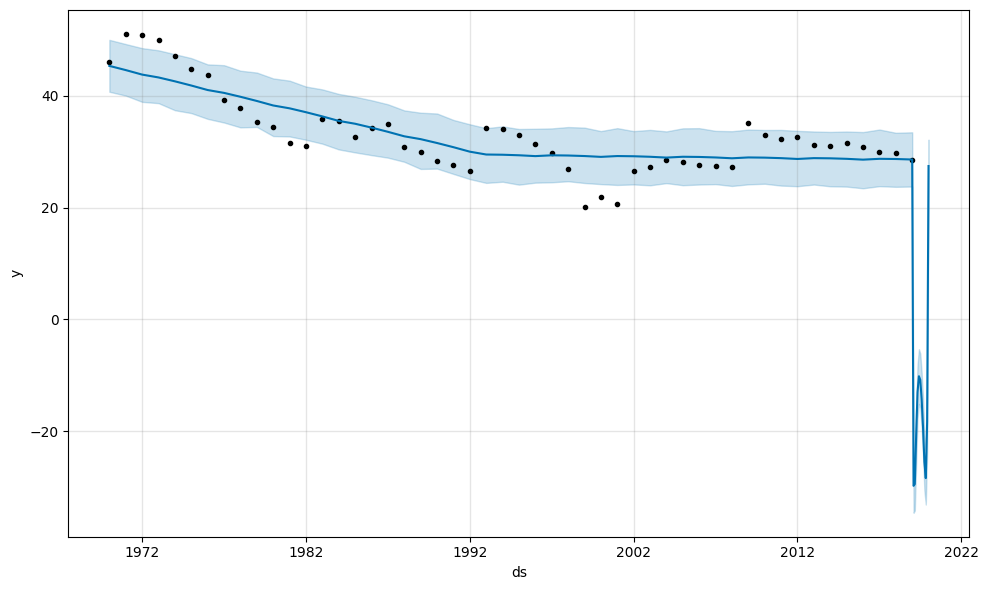

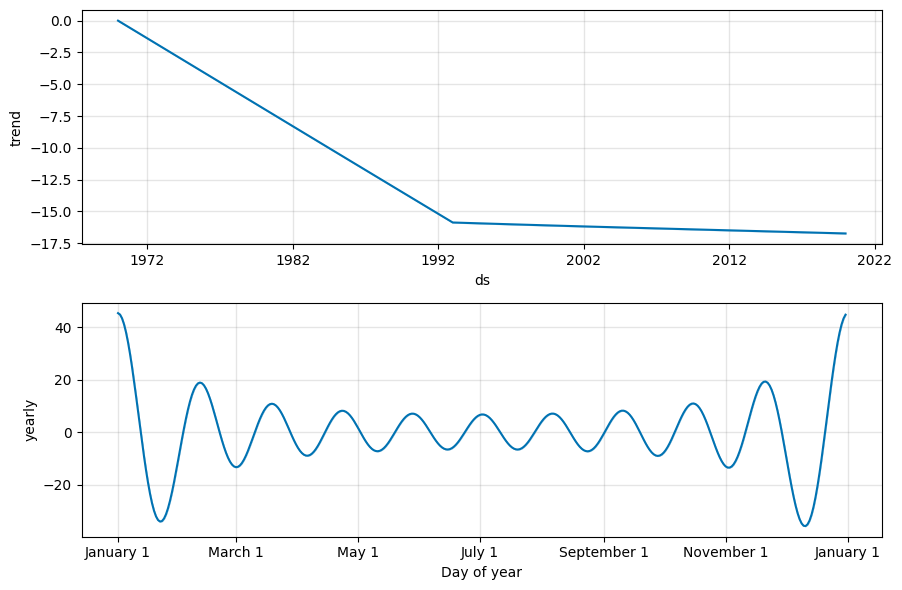

04:10:51 - cmdstanpy - INFO - Chain [1] start processing
04:10:51 - cmdstanpy - INFO - Chain [1] done processing


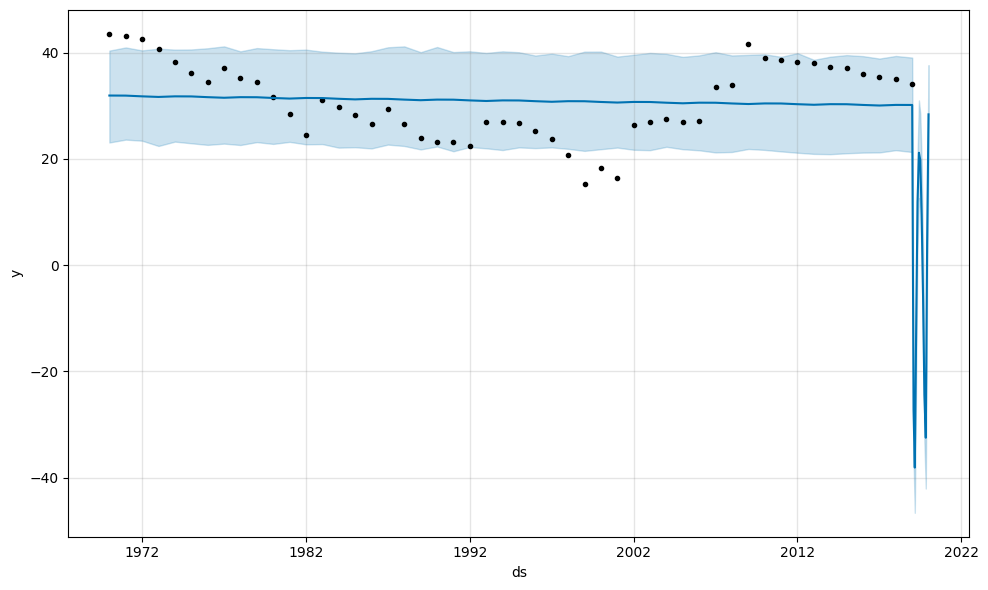

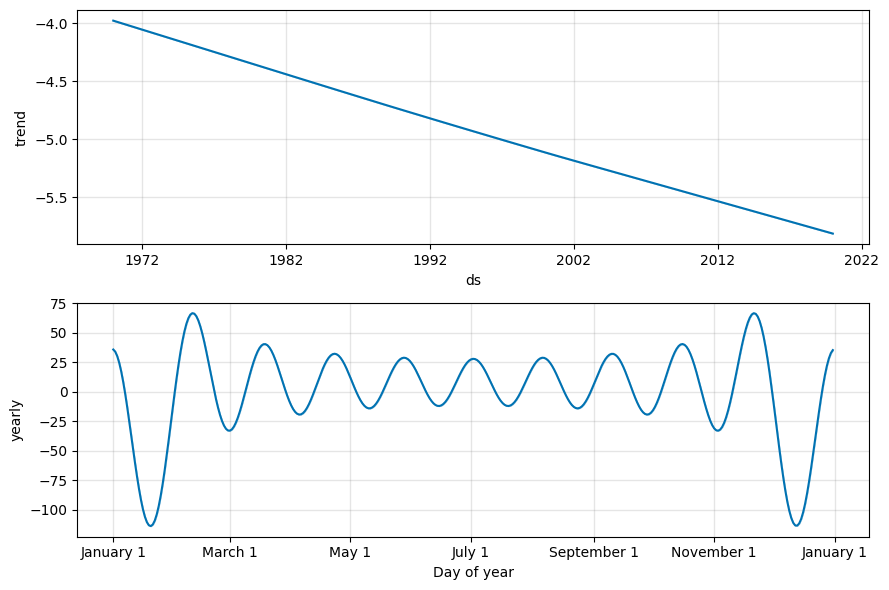

04:10:52 - cmdstanpy - INFO - Chain [1] start processing
04:10:52 - cmdstanpy - INFO - Chain [1] done processing


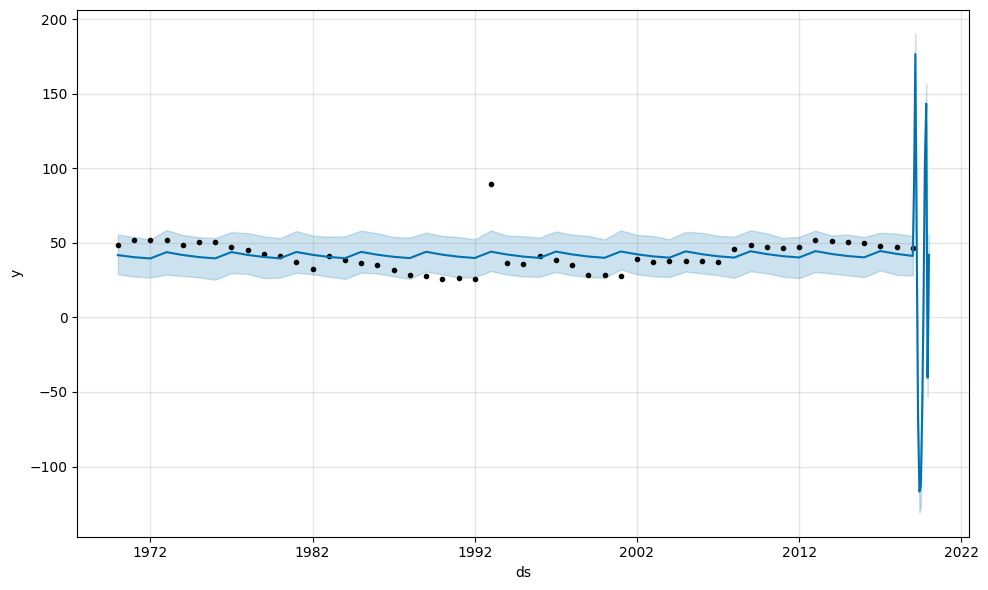

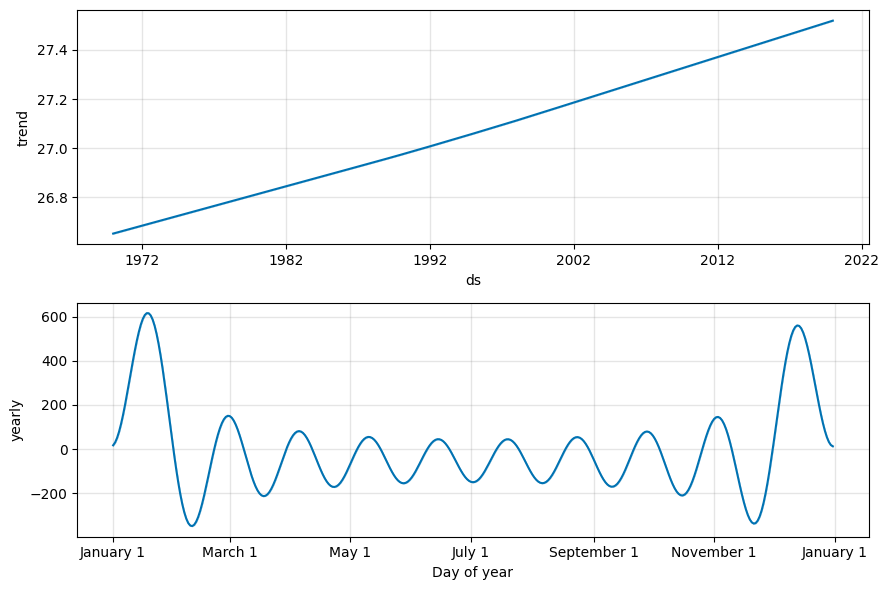

04:10:53 - cmdstanpy - INFO - Chain [1] start processing
04:10:53 - cmdstanpy - INFO - Chain [1] done processing


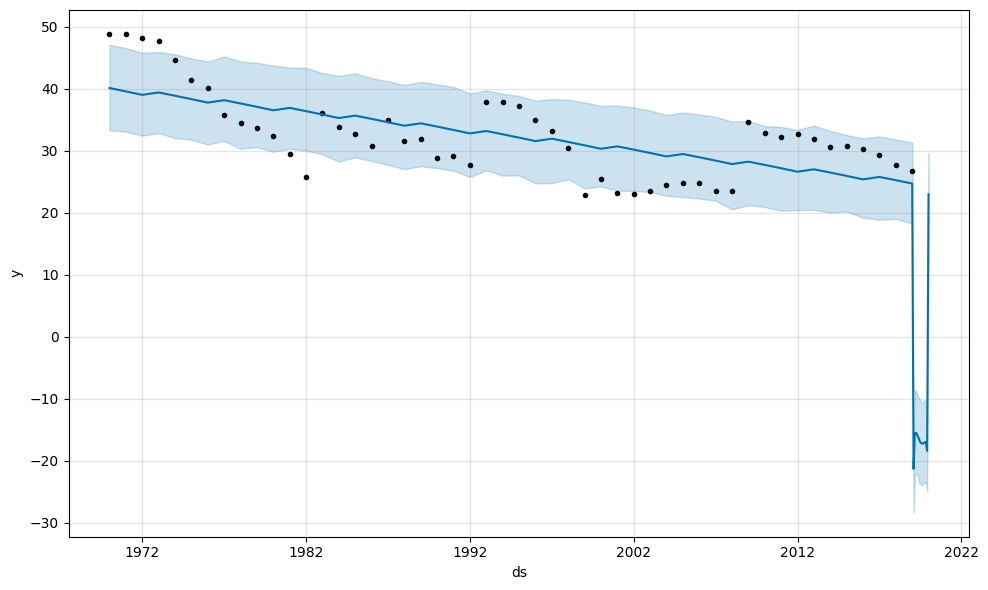

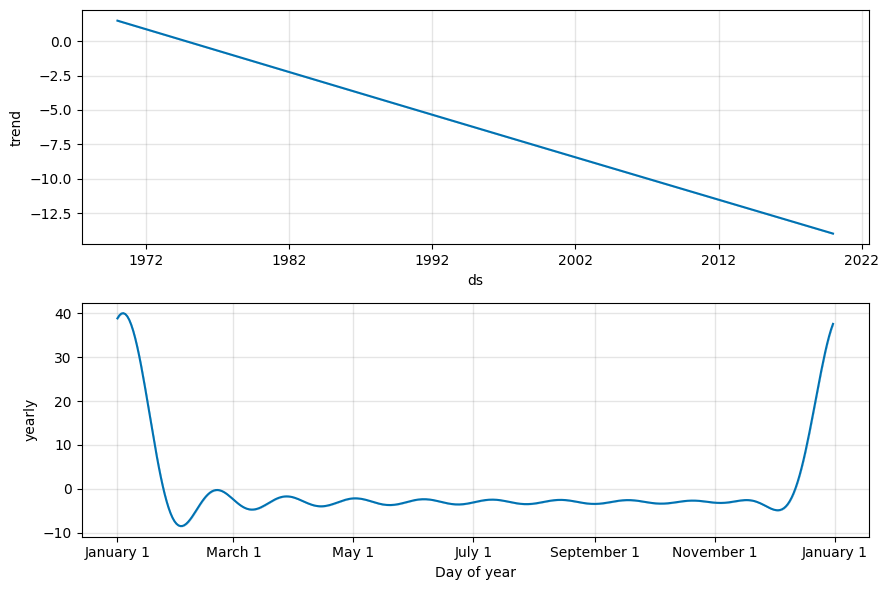

04:10:53 - cmdstanpy - INFO - Chain [1] start processing
04:10:53 - cmdstanpy - INFO - Chain [1] done processing


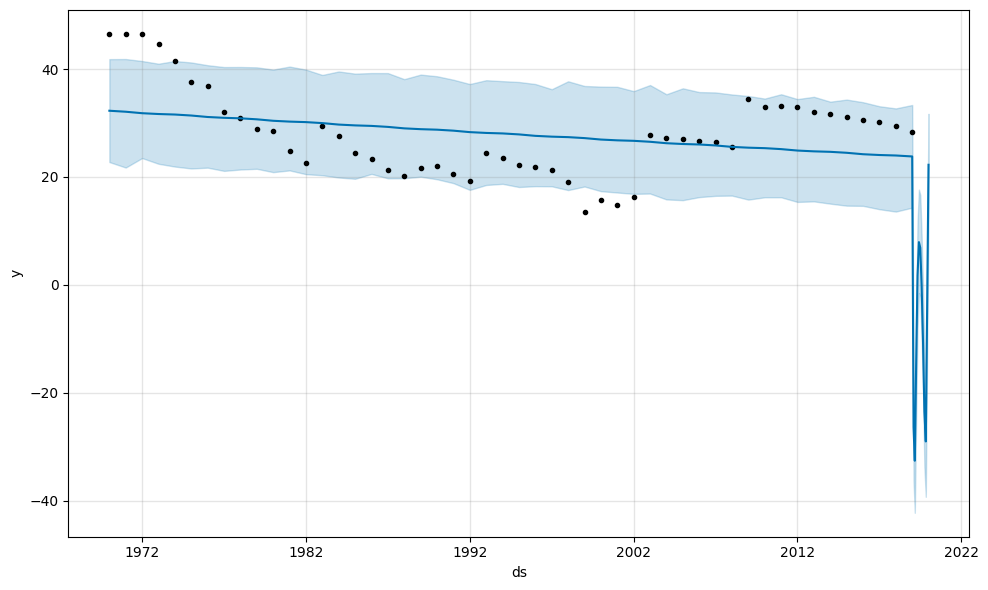

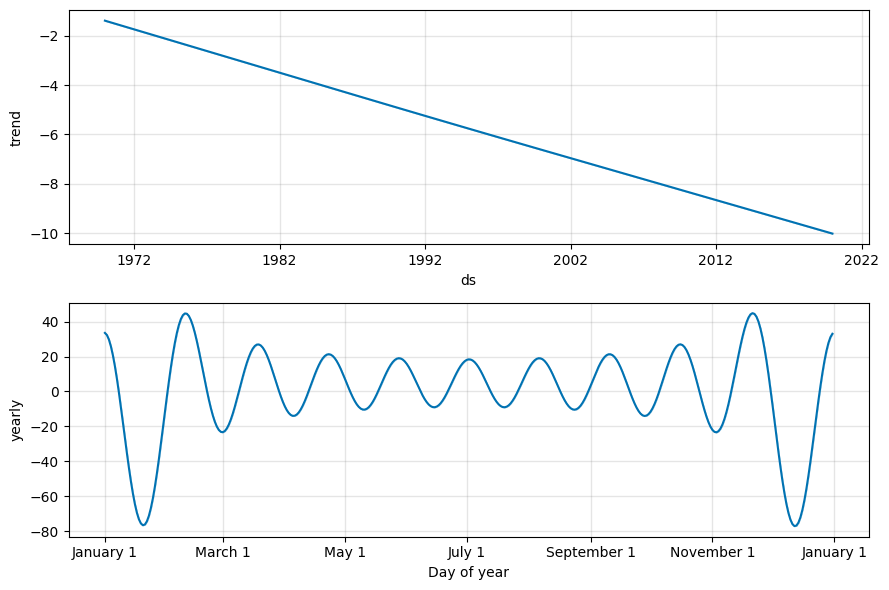

04:10:54 - cmdstanpy - INFO - Chain [1] start processing
04:10:54 - cmdstanpy - INFO - Chain [1] done processing


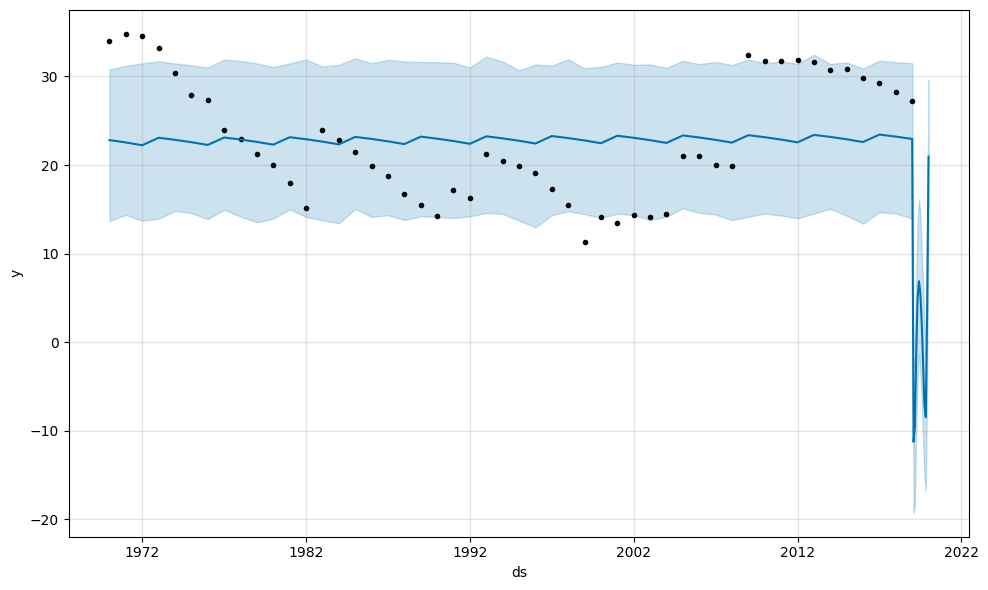

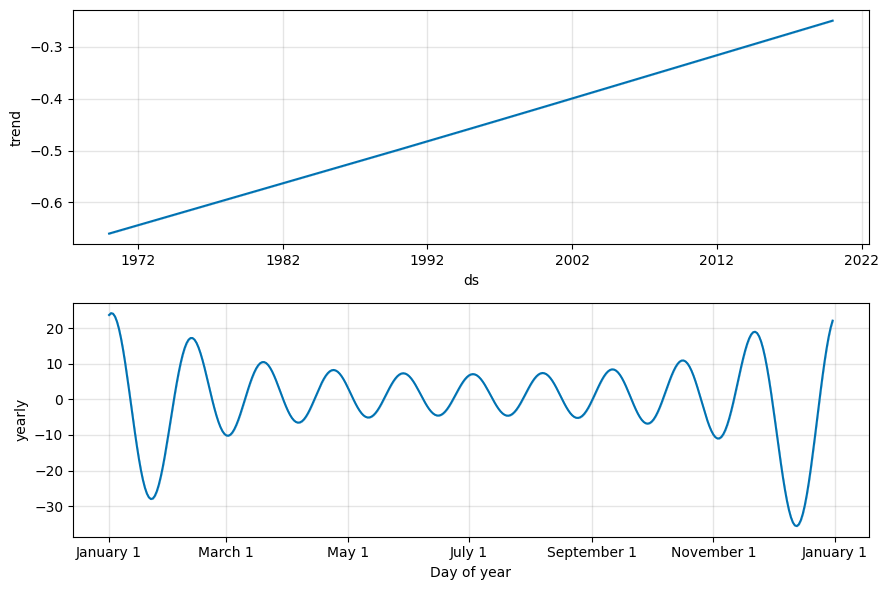

04:10:55 - cmdstanpy - INFO - Chain [1] start processing
04:10:55 - cmdstanpy - INFO - Chain [1] done processing


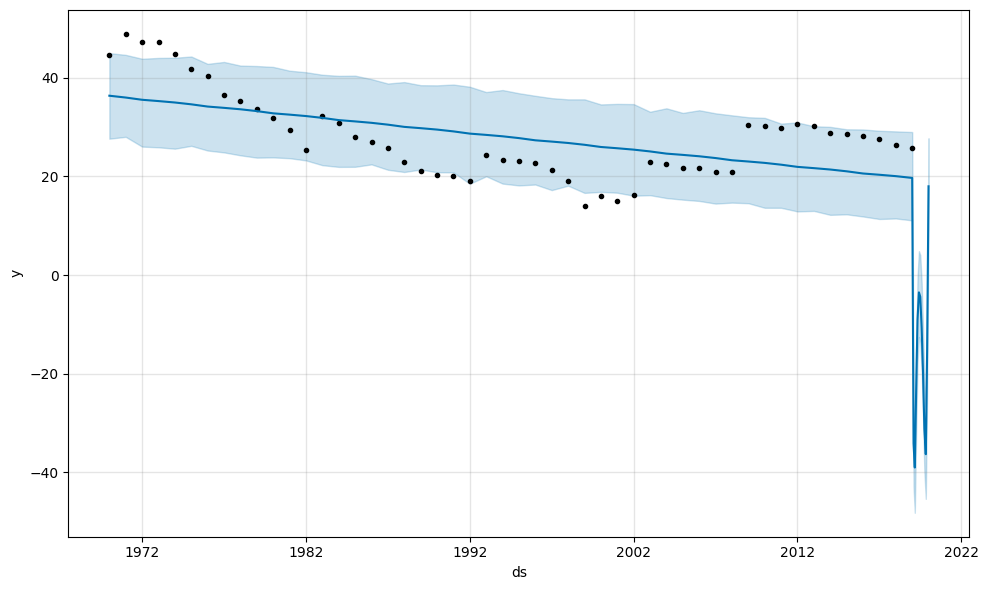

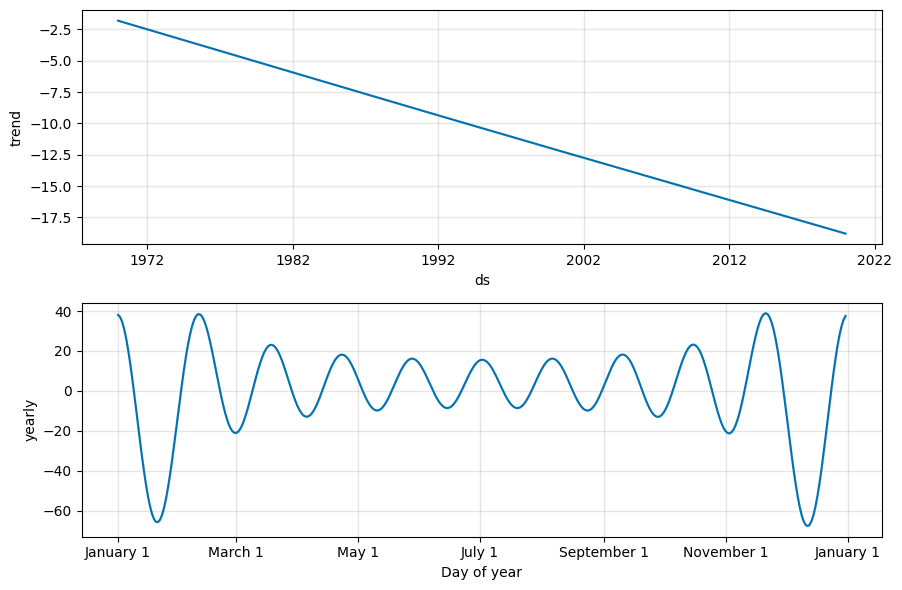

04:10:55 - cmdstanpy - INFO - Chain [1] start processing
04:10:56 - cmdstanpy - INFO - Chain [1] done processing


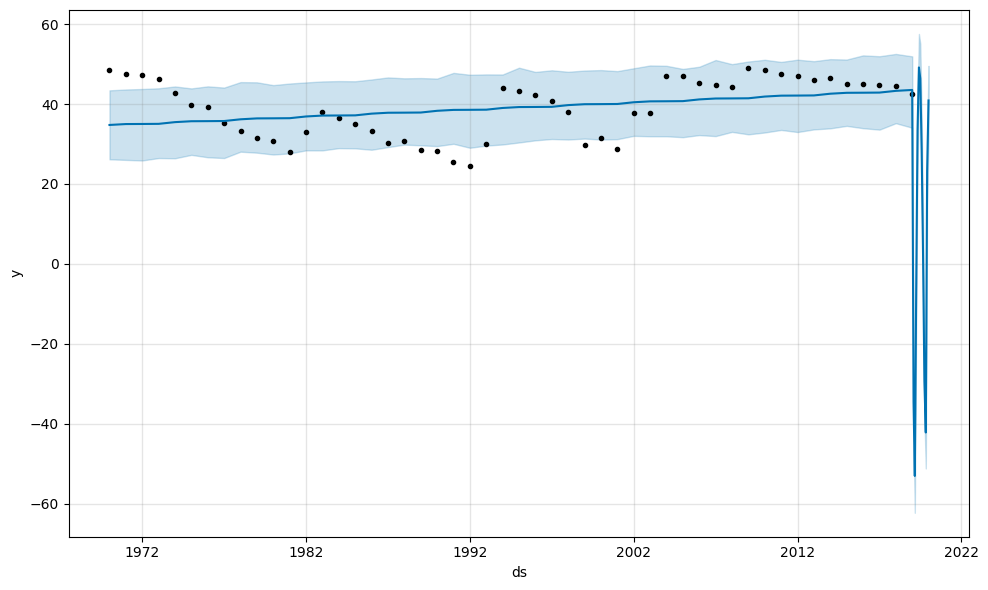

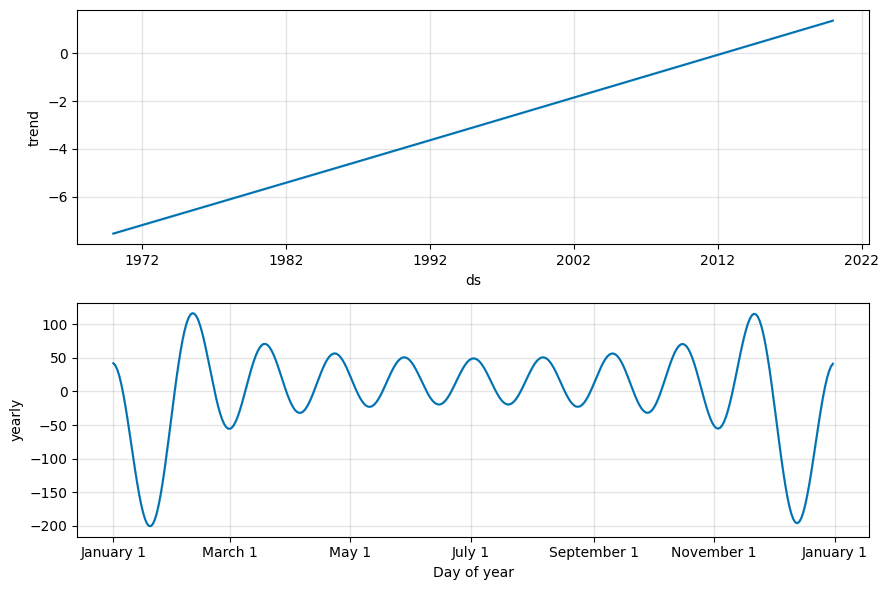

04:10:56 - cmdstanpy - INFO - Chain [1] start processing
04:10:56 - cmdstanpy - INFO - Chain [1] done processing


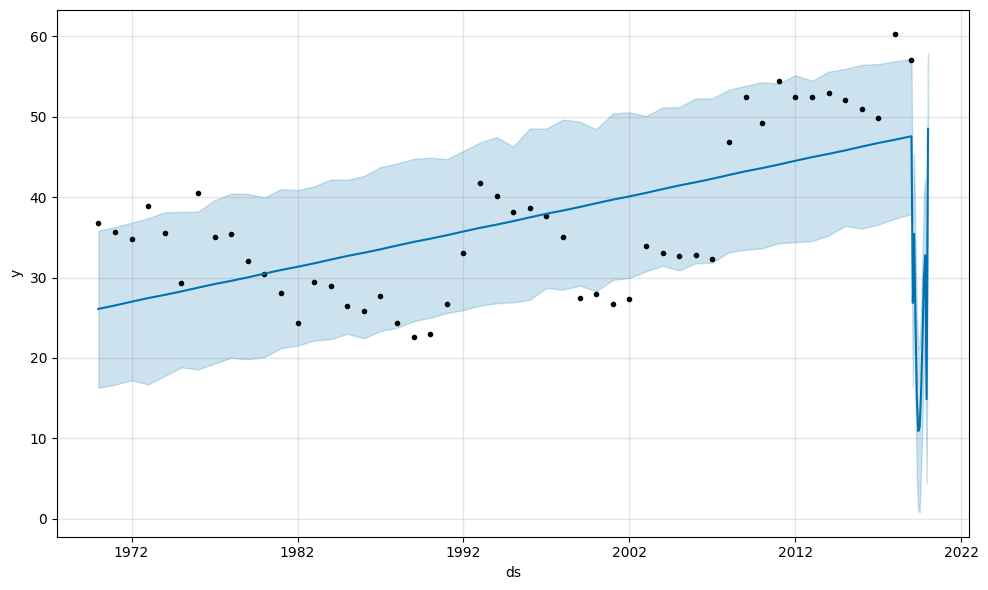

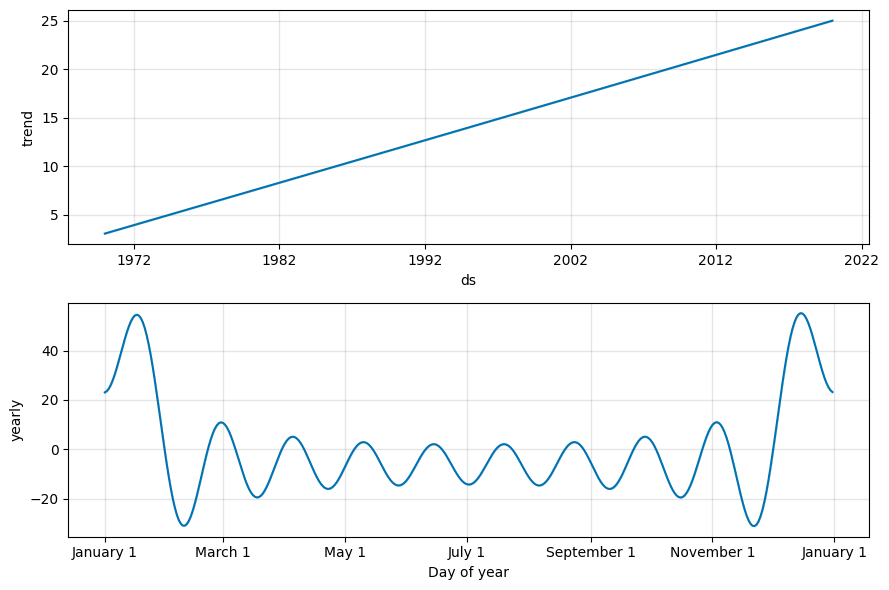

04:10:57 - cmdstanpy - INFO - Chain [1] start processing
04:10:57 - cmdstanpy - INFO - Chain [1] done processing


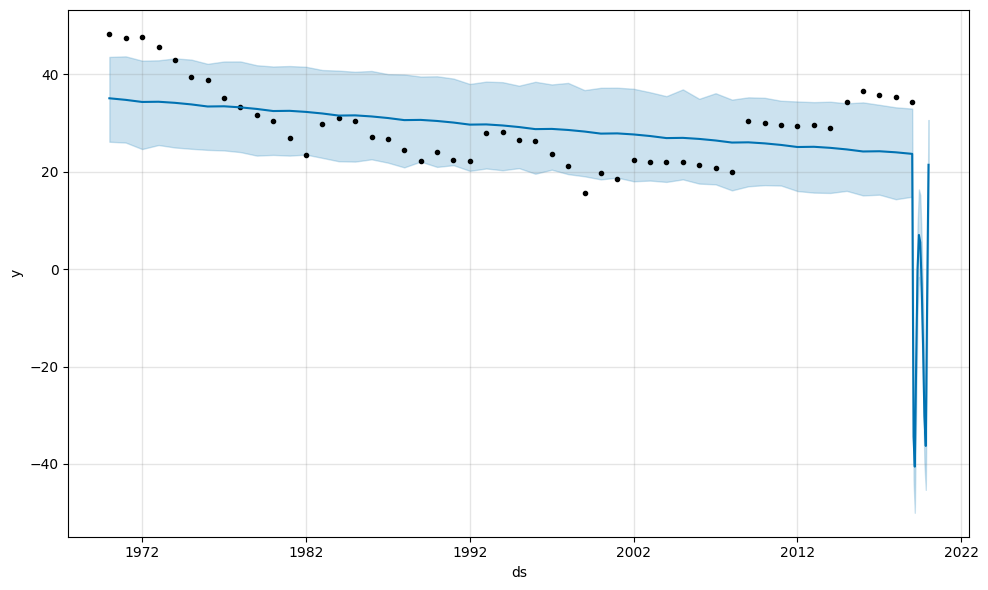

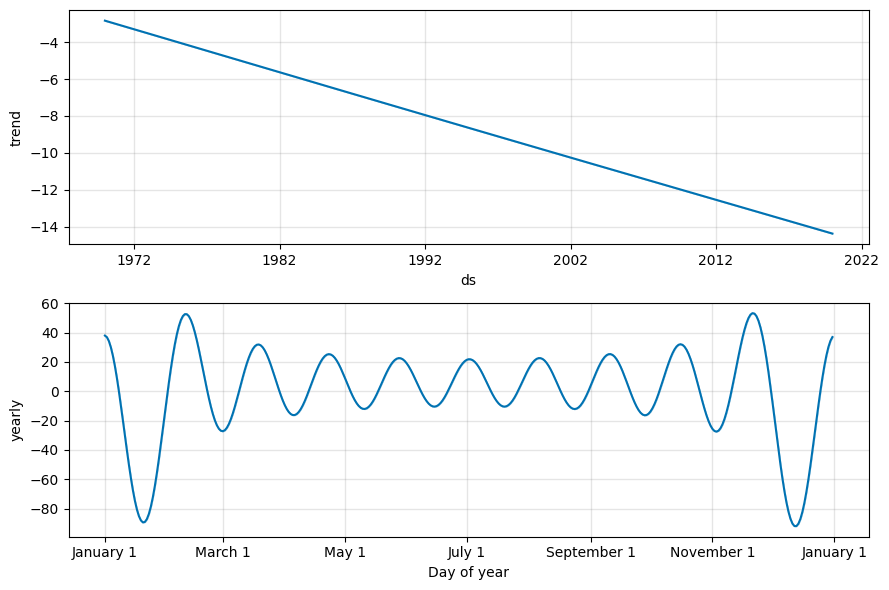

04:10:57 - cmdstanpy - INFO - Chain [1] start processing
04:10:57 - cmdstanpy - INFO - Chain [1] done processing


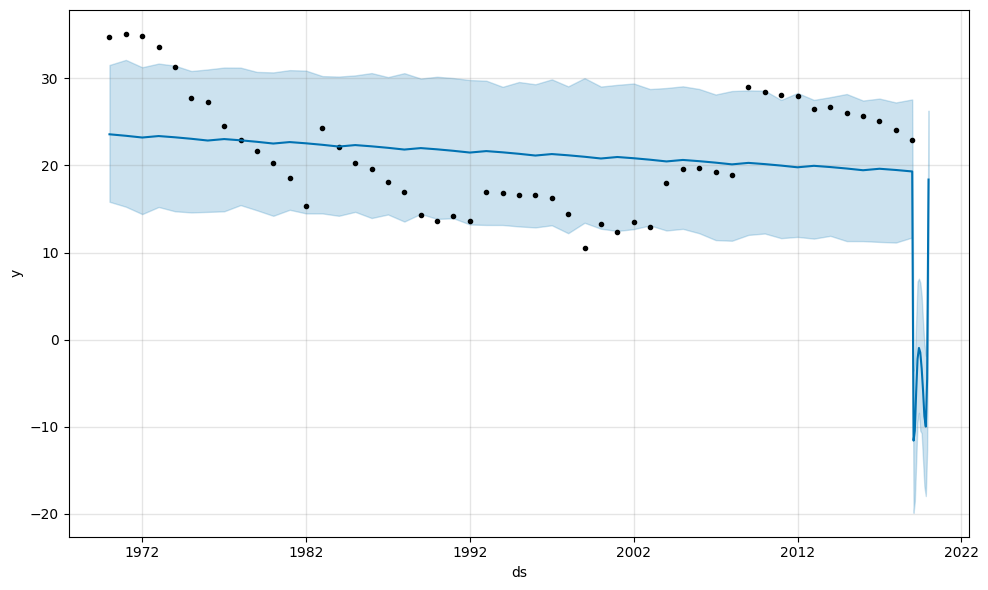

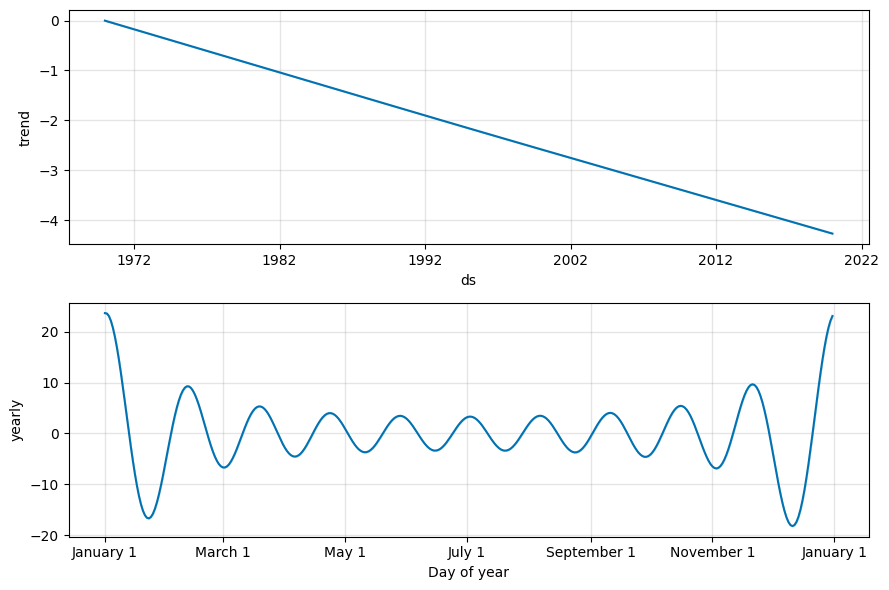

04:10:58 - cmdstanpy - INFO - Chain [1] start processing
04:10:58 - cmdstanpy - INFO - Chain [1] done processing


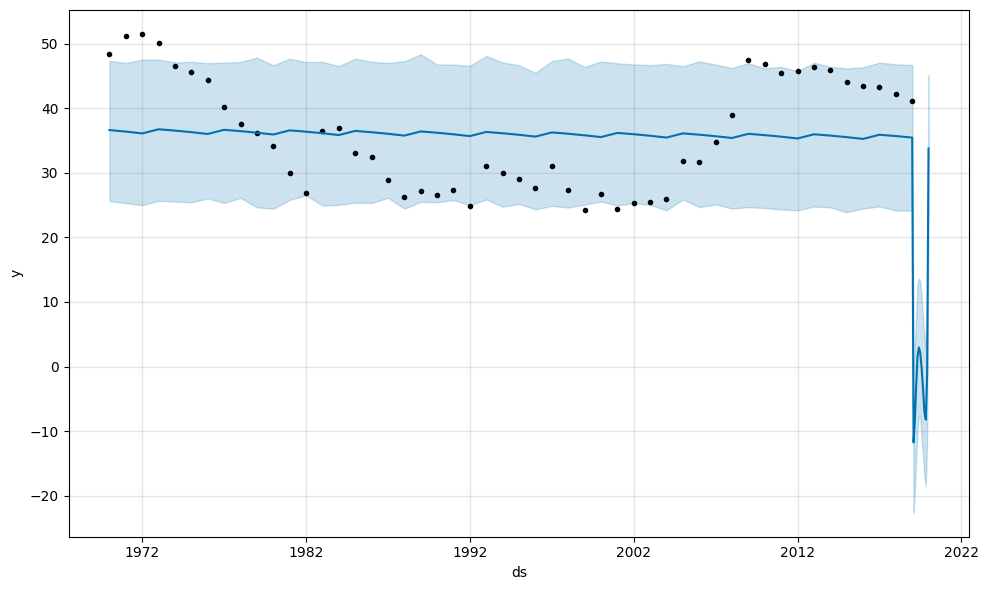

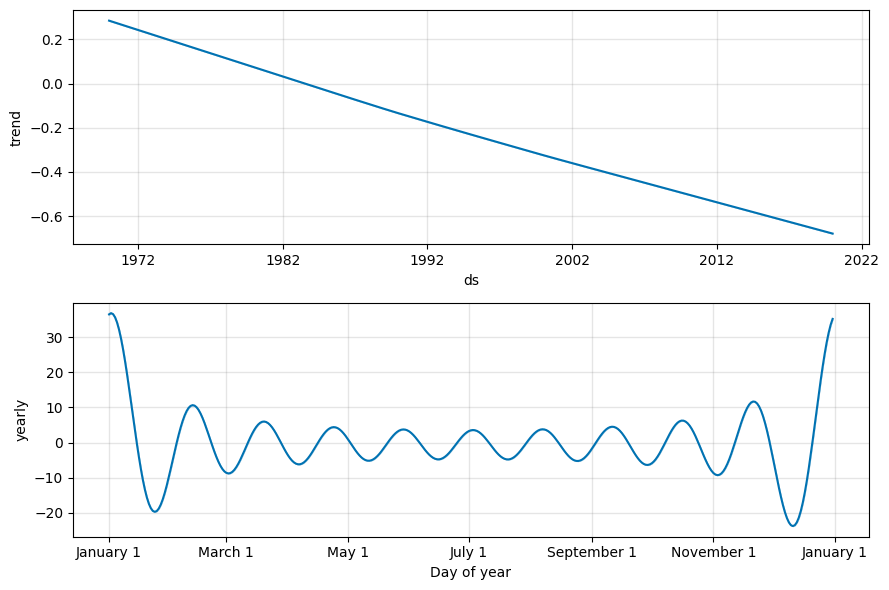

04:10:59 - cmdstanpy - INFO - Chain [1] start processing
04:10:59 - cmdstanpy - INFO - Chain [1] done processing


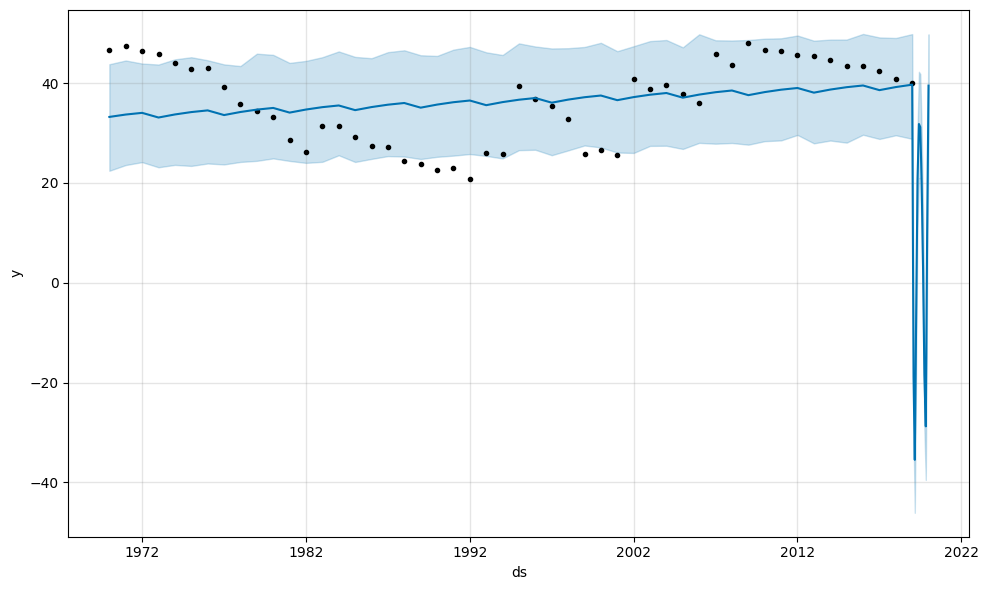

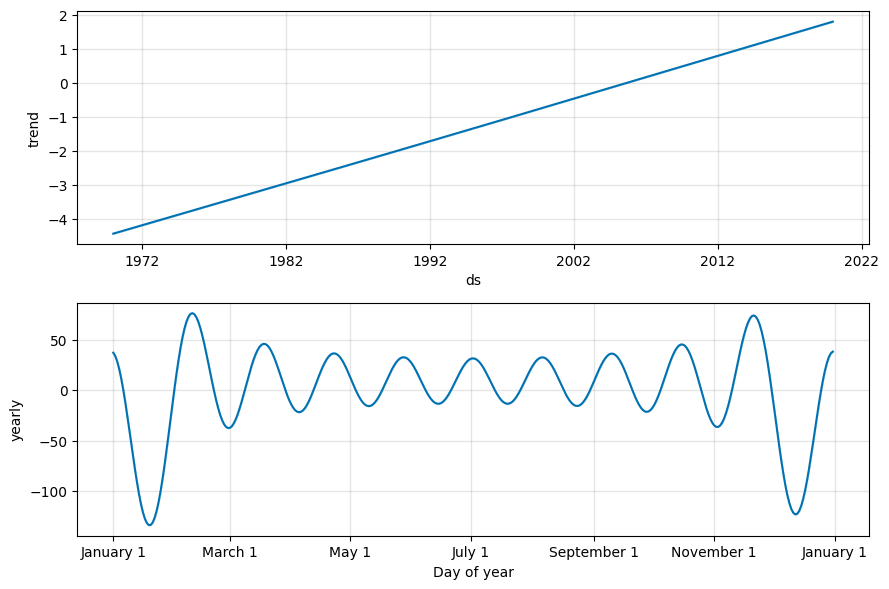

04:10:59 - cmdstanpy - INFO - Chain [1] start processing
04:11:00 - cmdstanpy - INFO - Chain [1] done processing


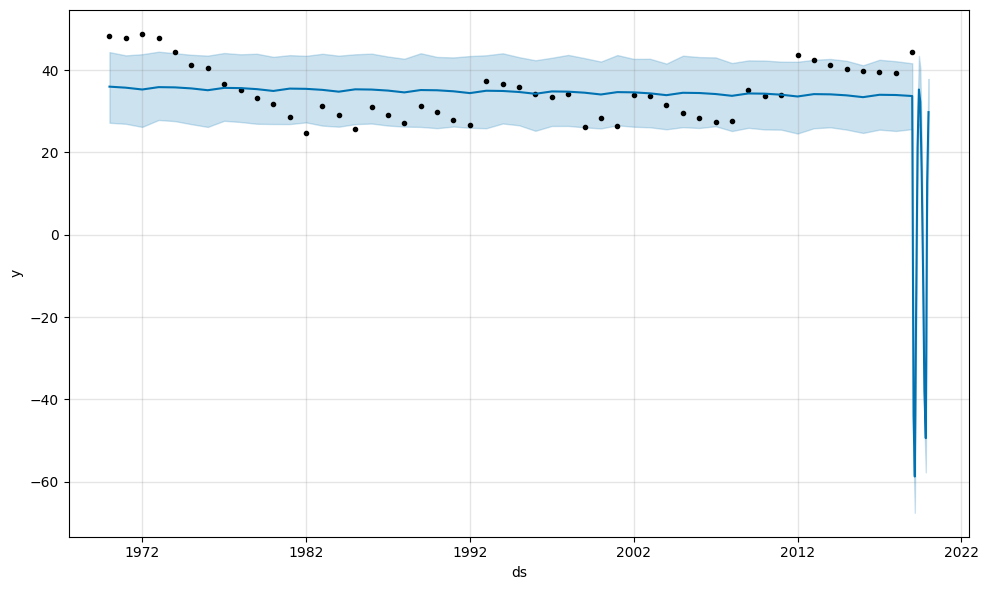

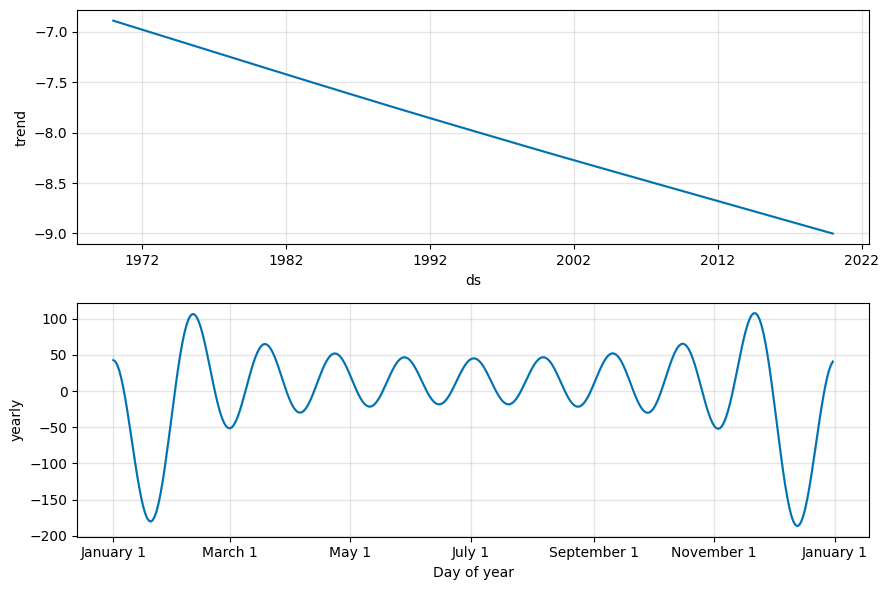

04:11:00 - cmdstanpy - INFO - Chain [1] start processing
04:11:00 - cmdstanpy - INFO - Chain [1] done processing


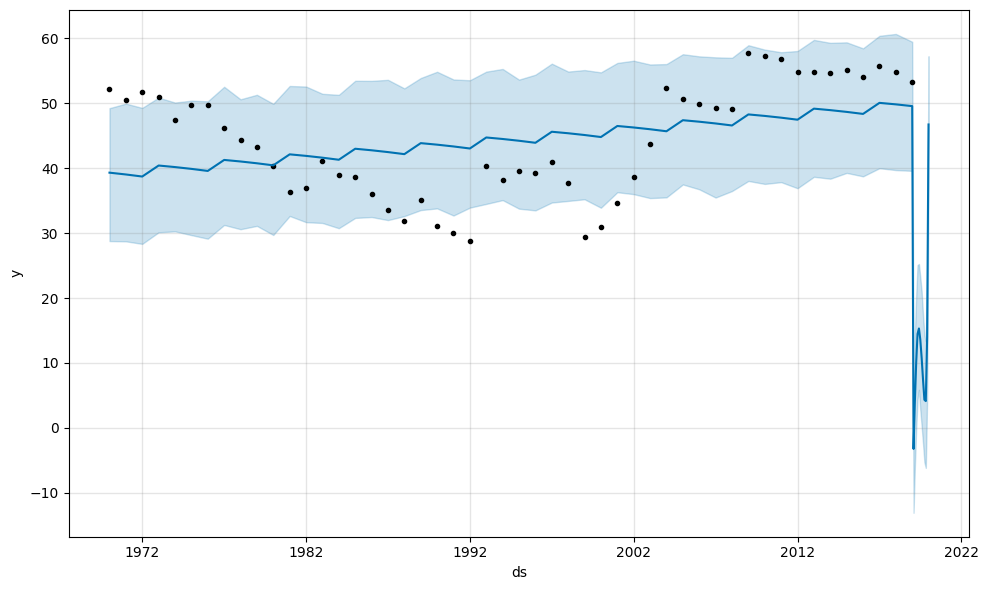

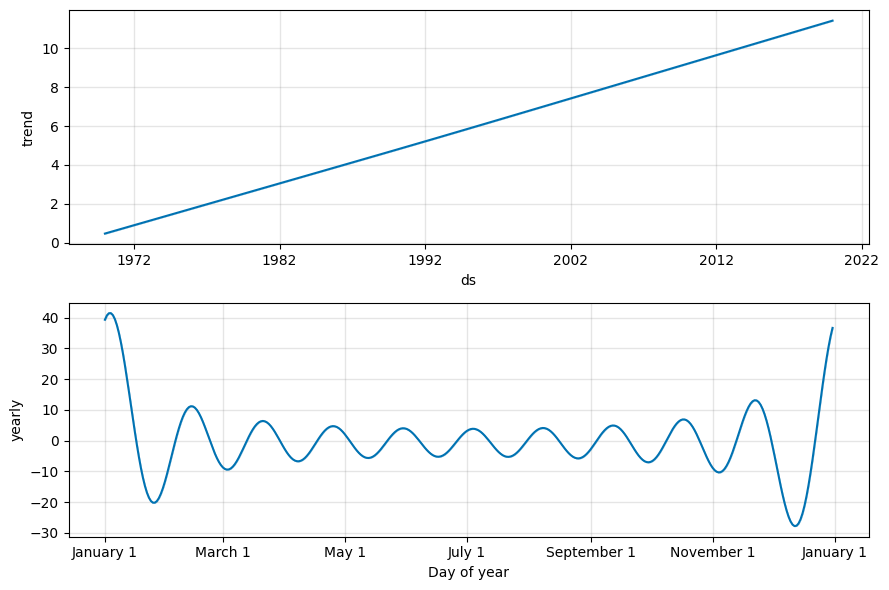

04:11:01 - cmdstanpy - INFO - Chain [1] start processing
04:11:01 - cmdstanpy - INFO - Chain [1] done processing


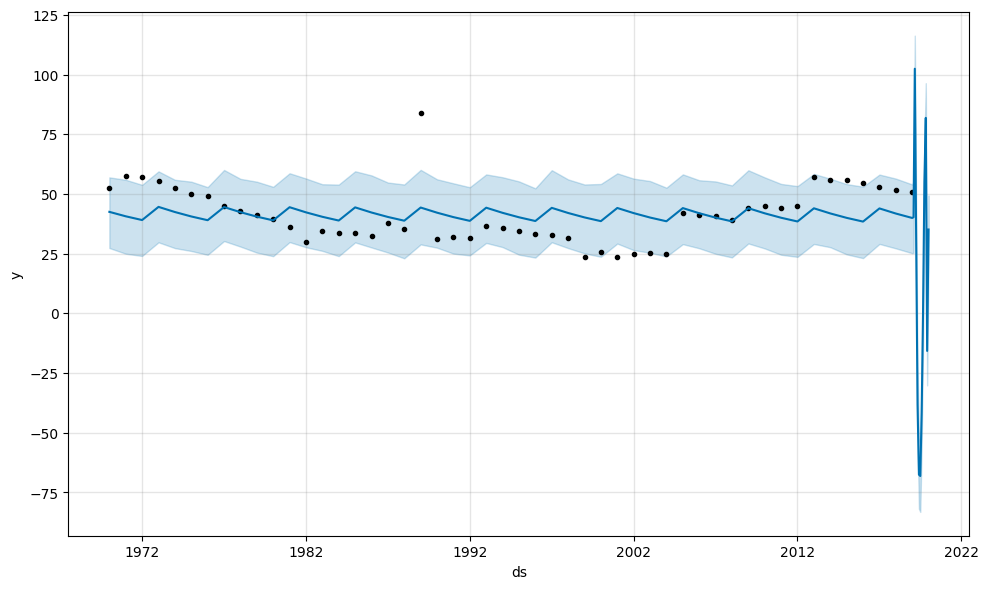

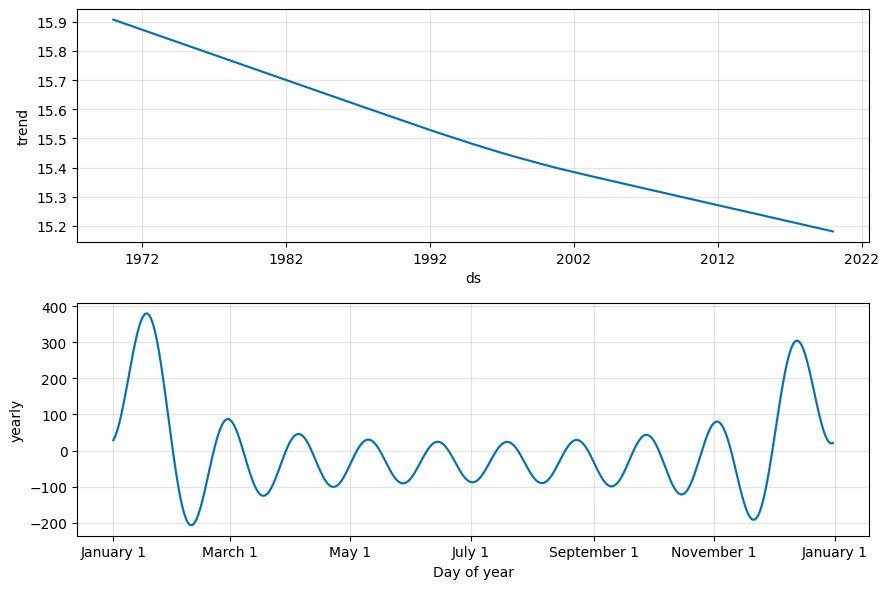

04:11:01 - cmdstanpy - INFO - Chain [1] start processing
04:11:02 - cmdstanpy - INFO - Chain [1] done processing


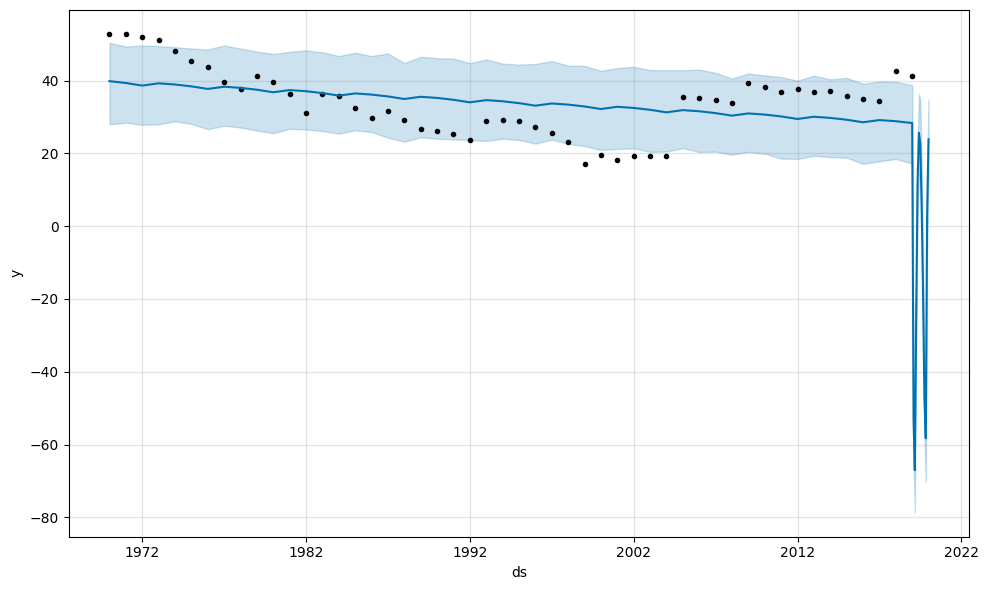

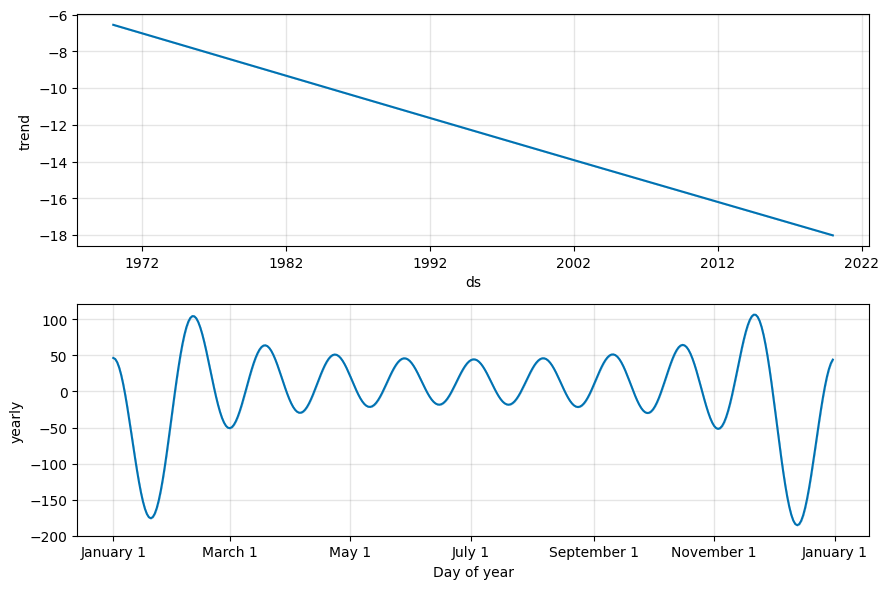

04:11:02 - cmdstanpy - INFO - Chain [1] start processing
04:11:02 - cmdstanpy - INFO - Chain [1] done processing


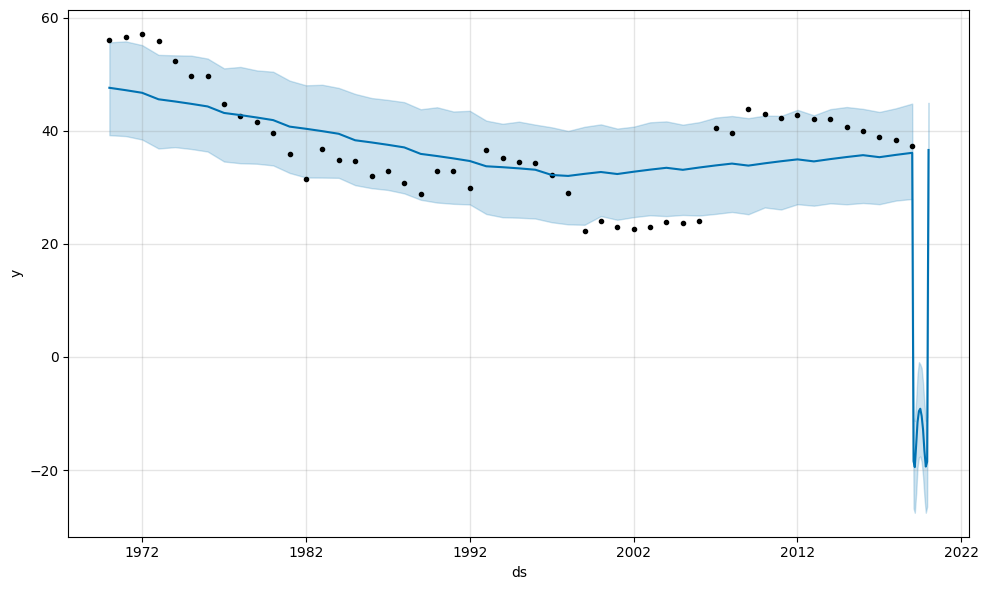

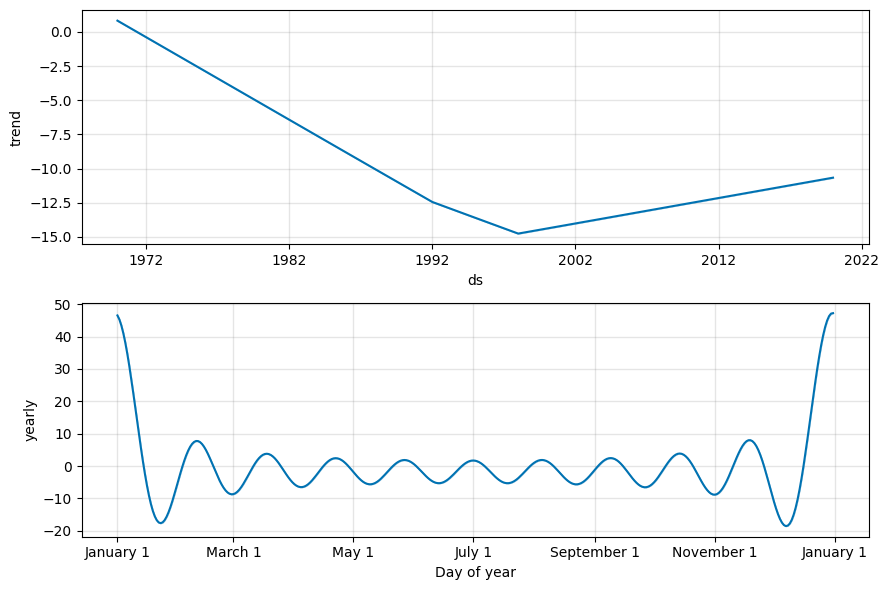

04:11:03 - cmdstanpy - INFO - Chain [1] start processing
04:11:03 - cmdstanpy - INFO - Chain [1] done processing


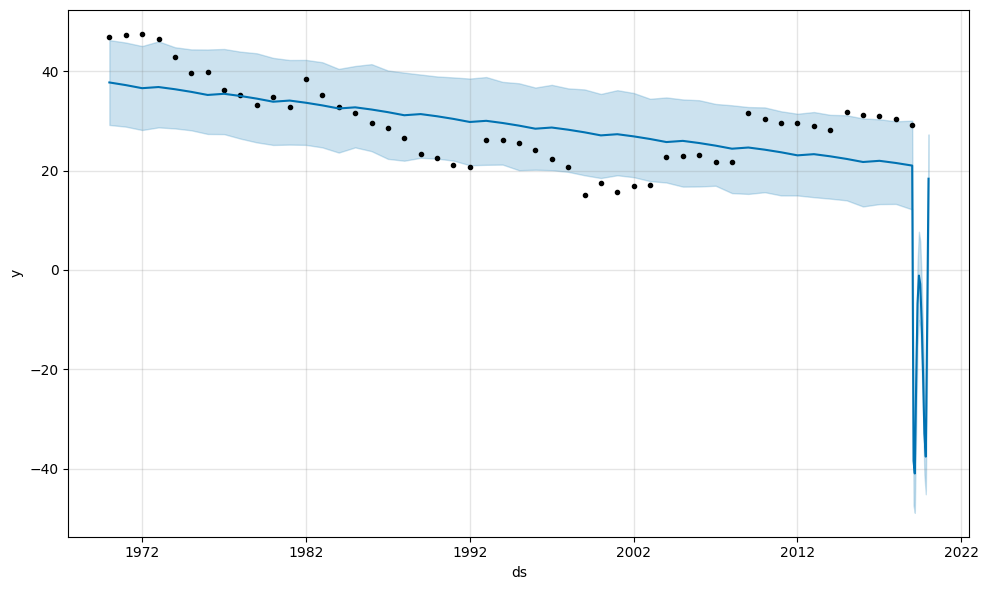

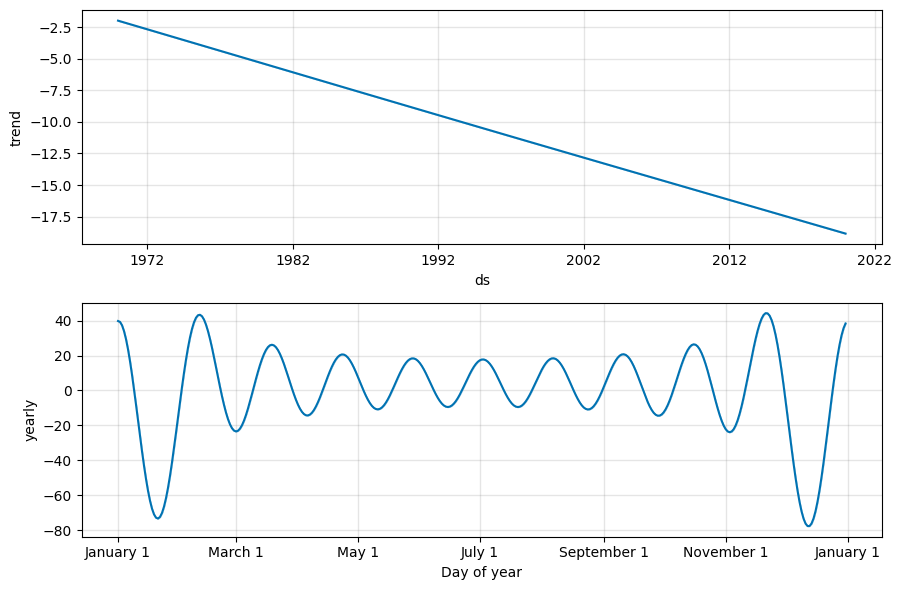

04:11:03 - cmdstanpy - INFO - Chain [1] start processing
04:11:04 - cmdstanpy - INFO - Chain [1] done processing


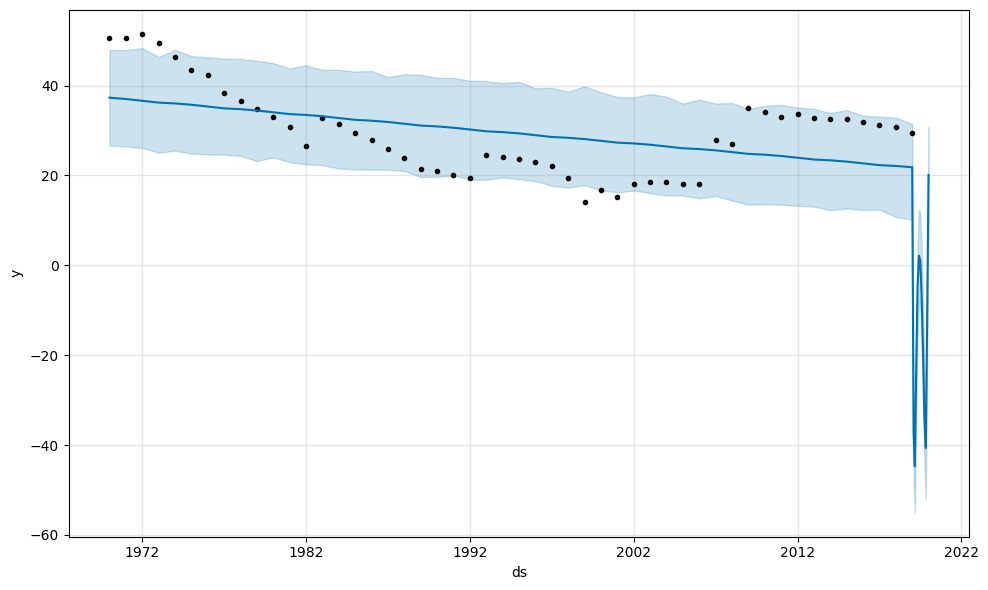

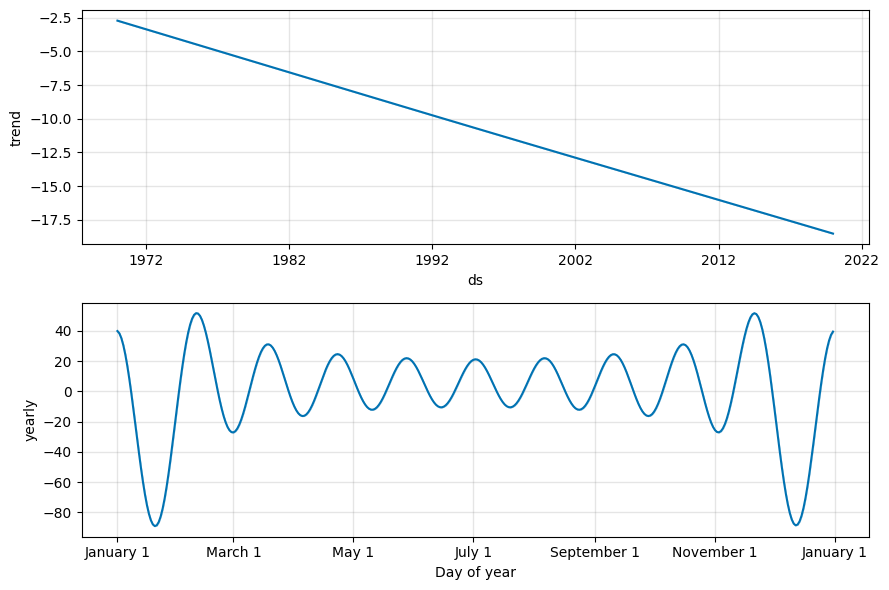

04:11:04 - cmdstanpy - INFO - Chain [1] start processing
04:11:05 - cmdstanpy - INFO - Chain [1] done processing


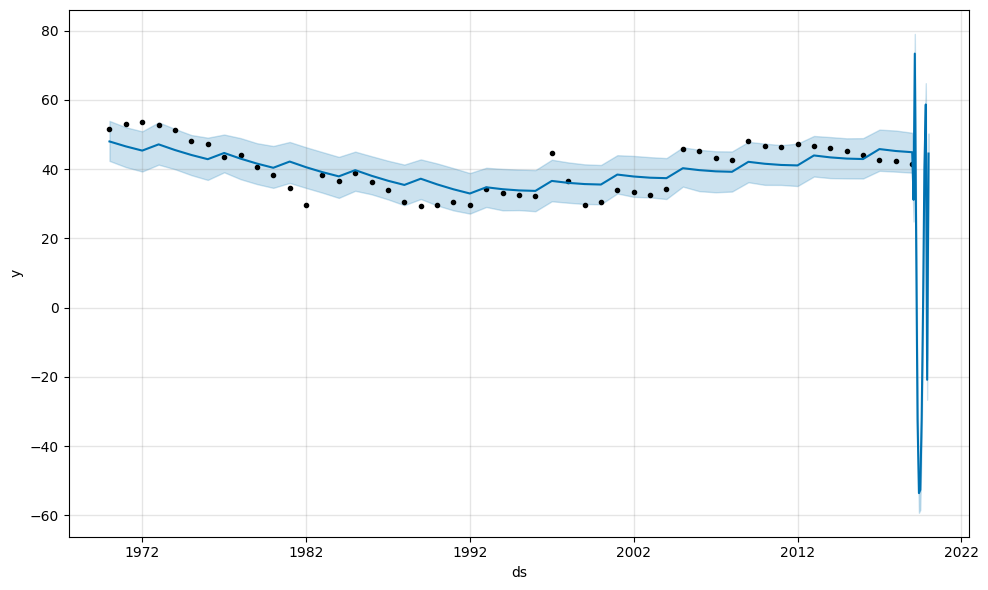

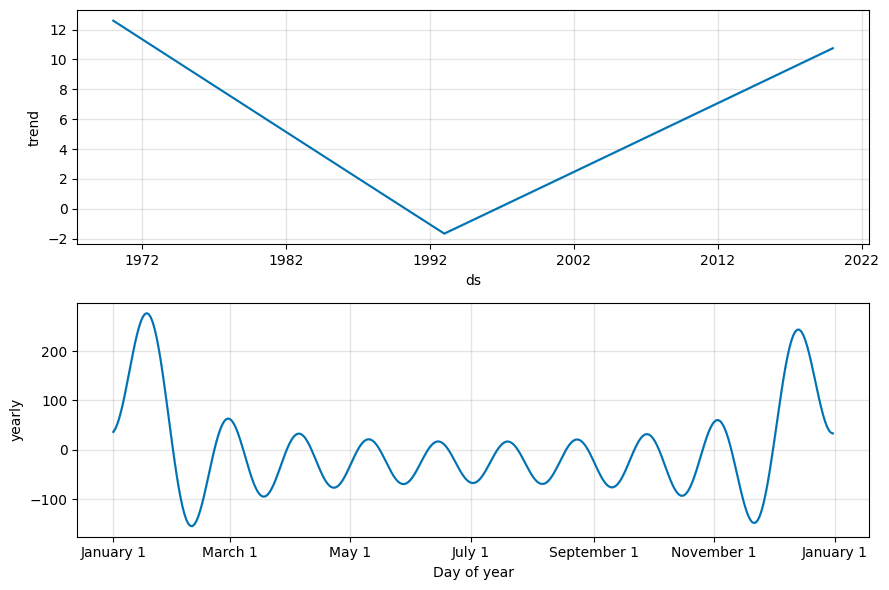

04:11:05 - cmdstanpy - INFO - Chain [1] start processing
04:11:05 - cmdstanpy - INFO - Chain [1] done processing


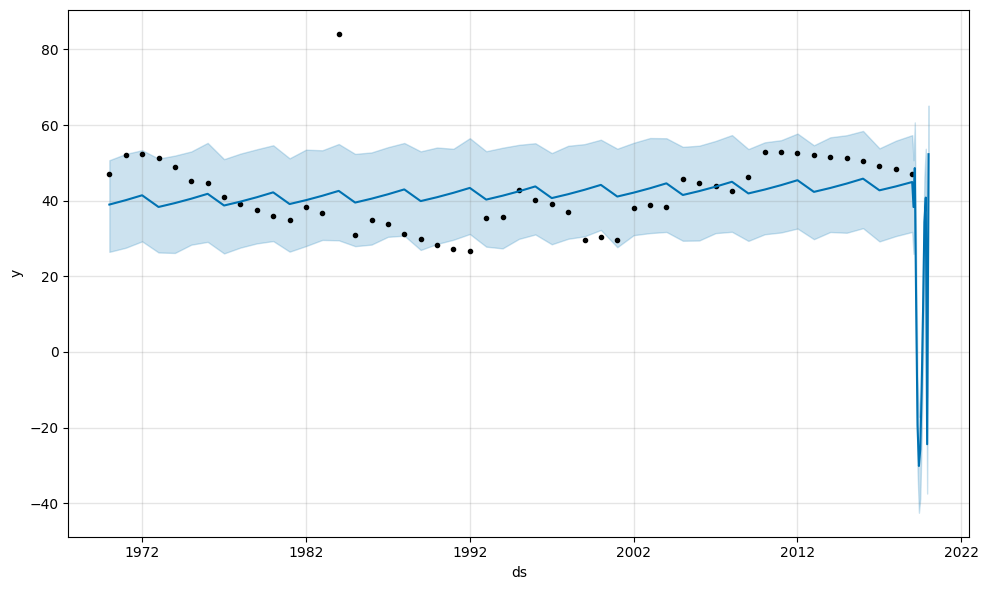

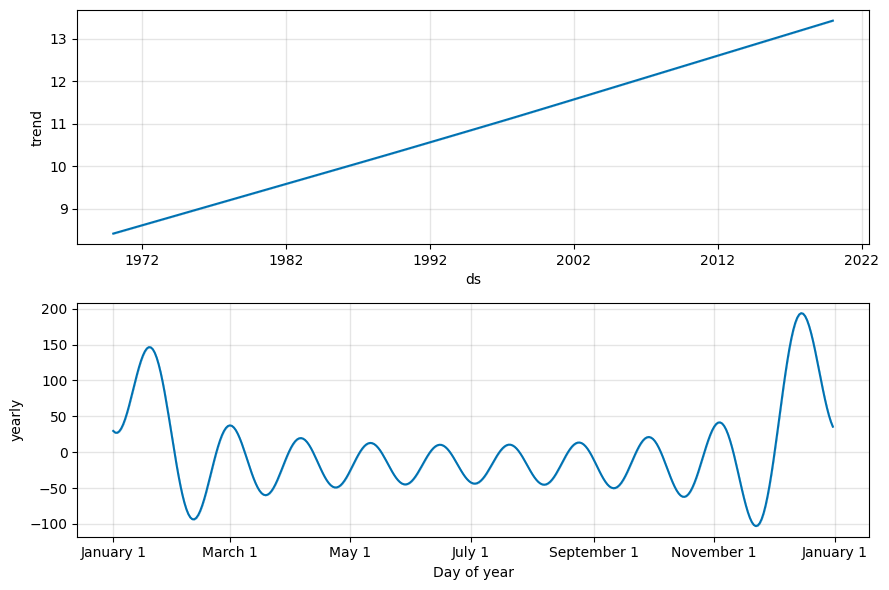

Forecast for Massachusetts:
           ds        yhat  yhat_lower  yhat_upper
0  1970-01-01   41.745294   28.951952   55.476148
1  1971-01-01   40.352923   27.378487   53.846201
2  1972-01-01   39.482036   26.753014   52.349548
3  1973-01-01   43.721559   28.573604   58.504692
4  1974-01-01   41.809385   27.773777   55.251009
..        ...         ...         ...         ...
57 2019-08-31   10.509796   -2.863134   24.674418
58 2019-09-30  102.335055   88.960513  115.805685
59 2019-10-31  143.257042  129.690982  156.899938
60 2019-11-30  -40.434614  -53.387258  -26.099986
61 2019-12-31   41.984654   28.967642   55.623106

[62 rows x 4 columns]


In [13]:
from prophet import Prophet

# Tax prediction on Tobacco Tax using Prophet
forecast_results = {}
merged_data['Year'] = pd.to_datetime(merged_data['Year'], format='%Y')
for location in merged_data['LocationDesc'].unique():
    location_data = merged_data[merged_data['LocationDesc'] == location][['Year', 'Tax_Percentage']].dropna()
    location_data = location_data.sort_values('Year')
    location_data = location_data.rename(columns={'Year': 'ds', 'Tax_Percentage': 'y'})
    model = Prophet()
    model.fit(location_data)
    future = model.make_future_dataframe(periods=12, freq='ME')  
    forecast = model.predict(future)
    forecast_results[location] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    model.plot(forecast)
    model.plot_components(forecast)
    plt.show() 
sample_location = "Massachusetts"
print(f"Forecast for {sample_location}:")
print(forecast_results[sample_location])